# Исследование интернет-магазина "Стримчик"

Предоставлены данные о продаже компьютерных игр в интернет-магазине "Стримчик", который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Данные представлены до 2016 г. Необходимо спланировать компанию на 2017 г.

<font size=+1><b>Описание данных:</b></font><br>

В основных данных есть необходимая информация об игре, продажи по разным странам и рейтинге пользователей и критиков: games_project.csv

- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

<font size=+1><b>План работы:</b></font><br>
- Загрузить данные и изучить общую информацию.
- Выполнить предобработку данных.
- Посмотреть выпуски игр за разные годы.
- Посмотреть продажи по платформам, выбрать платформы с наибольшими продажами.
- Выявить, за какой характерный срок появляются новый и исчезают старые платформы.
- Выбрать актуальный период, за который будет происходить анализ данных для последующего прогноза.
- Выбрать несколько потенциально прибыльных платформ.
- Оценить, как влияют на продажи внутри платформы отзывы пользователей и критиков.
- Оценить самые прибыльные жанры игр.
- Составить портрет пользователя для каждого региона.
    - Определить топ-5 платформ.
    - Определить топ-5 жанров.
    - Оценить влияние рейтинга ESRB на продажи.
- Проверить гипотезы:
    - одинаковы ли средние пользовательские рейтинги платформ Xbox One и PC
    - разные ли средние пользовательские рейтинги жанров Action и Sports
- Подвести общий итог исследования.

## Загрузка данных

### Используемые библиотеки и функции

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.style.use('fivethirtyeight')
plt.rc('figure', figsize=(20, 8))

In [3]:
# функция для загрузки данных
def main_info (dataset):
    data = pd.read_csv(dataset, sep=',')
    pd.set_option('max_colwidth', 200)
    display(data.head())
    print('------------------------------------------')
    display('Основная информация по столбцам таблицы:')
    display(data.info())
    print('-------------------------------------')
    display('Доля пропусков по столбцам таблицы:')
    display(pd.DataFrame(round(data.isna().mean()\
                               .sort_values(ascending=False), 3))\
                        .style.format('{:.1%}')\
                        .background_gradient('coolwarm'))
    print('---------------------------------')
    display('Основная информация по таблице:')
    display(data.describe().style.format('{:.2f}'))
    print('----------------------------------------')
    display('Количество явных дубликатов в таблице:')
    display(data.duplicated().sum())
    print('--------------')
    display('Гистограммы:')
    data.hist(figsize=(20, 8))
    plt.show();
    return data

In [4]:
# функция для создания сводной таблицы
def table_pivot(data, col_group, values, func):
    return data.groupby(by=col_group, as_index=False)\
               .agg(total = (values, func))

In [5]:
# функция для подписи на графике
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i]), ha = 'center')

In [6]:
# функция для построения продаж по всем платформам
def bar_plot(data, col_group):
    return data.plot(x=col_group,
                     kind='bar',
                     legend=False)

In [7]:
# Функция для построения графиков по отдельным платформам
def top_platform_sale(data, list_col):
    fig = plt.figure()
    total_axes = len(list_col) # общее количество графиков
    rows_axes = round(total_axes / 3) # количество рядов графиков
    subplt = 1 # номер начального axes

    for name in list_col:
        ax = fig.add_subplot(rows_axes, 3, subplt)
        df = table_pivot(data=data.query('platform == @name'), 
                         col_group='year_of_release', 
                         values='sales', func='sum')
        df.plot(x='year_of_release',
                kind='bar',
                title=f'Платформа {name}',
                xlabel='Год выпуска игры',
                ylabel='Кол-во проданных копий, млн',
                figsize=(20, 3*rows_axes + 4),
                ax=ax,
                legend=False)
        plt.xticks(rotation=0)
        plt.xticks(plt.xticks()[0][::2])
        addlabels(df['year_of_release'], df['total'])
        subplt += 1

    plt.tight_layout()
    plt.show()

In [8]:
# функция для корреляции между продажами и оценками критиков и пользователей
def corr_score(data, platform_name):
    df = data.query('platform == @platform_name')
    display(df[df.columns[1:4]].corr().style.format('{:.2f}').background_gradient('Blues'))
    pd.plotting.scatter_matrix(df[df.columns[1:4]])
    plt.title(f'Платформа {platform_name}')
    plt.show;

In [9]:
# Функция для рейтинга топ-5 платформам по кол-ву проданных копий
def top_region(data, col_group, list_col, col_name, list_name):
    fig = plt.figure()
    subplt = 1 # номер начального axes
    i = 0
    for name in list_col:
        ax = fig.add_subplot(1, 3, subplt)
        df = table_pivot(data, col_group, name, 'sum')\
                        .sort_values(by='total', ascending=False)\
                        .reset_index(drop=True)
        df_5 = df.loc[4, 'total']
        big_df = df[df['total'] >= df_5].reset_index(drop=True)
        big_df.loc[len(big_df.index)] = ['Other', df.loc[df['total'] < df_5, 'total'].sum()]
        big_df['total'].plot(kind='pie', 
                             autopct='%1.1f%%', 
                             label='', 
                             labels=big_df[col_group],
                             ax=ax)
        plt.title(f'Продажи для топ-5 {col_name} для {list_name[i]}')
        i += 1
        subplt += 1
        
    plt.tight_layout()
    plt.show()

### Загрузка данных и основная информация

Посмотрим на основную информацию из таблицы с данными.

Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN

------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

---------------------------------


'Основная информация по таблице:'

----------------------------------------


'Количество явных дубликатов в таблице:'

0

--------------


'Гистограммы:'

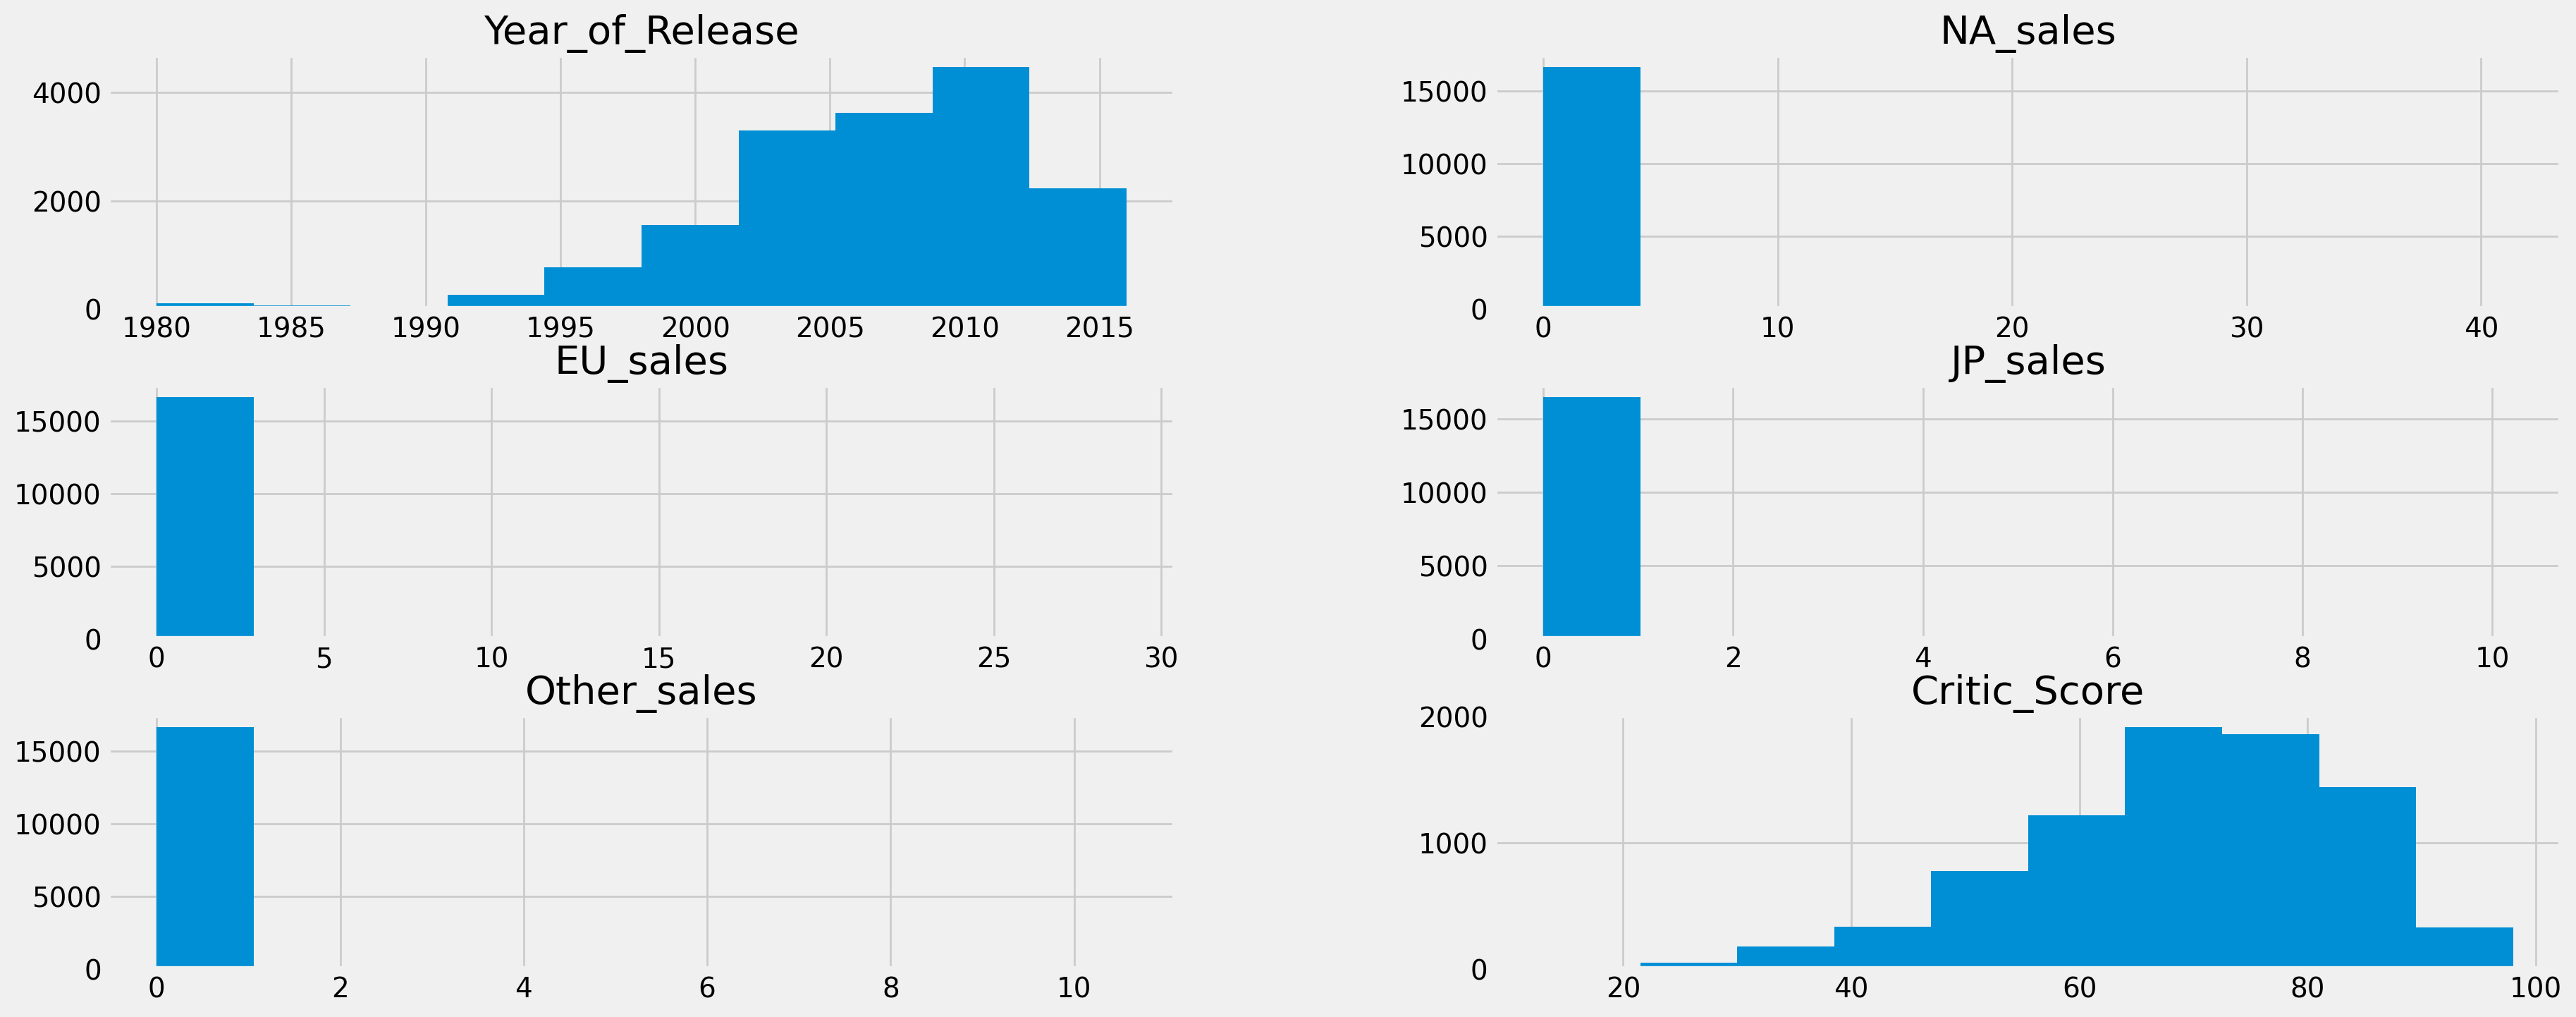

In [10]:
games = main_info('games_project.csv')

### Промежуточные выводы:

- В таблице 11 столбцов и 16715 записей с информацией об играх.
- В таблице нет явных дубликатов, но зато есть пропуски значений в 4 столбцах. 
- Доля пропусков в трёх столбцах занимает более 40 % от общего количества строк в датафрейме.
- Есть пропуски в названии игры: 2 штуки, и в годе выпуска игры: 1.6 % от строк датафрема.
- Представлен промежуток с 1980 по 2016 года.
- Больше всего выпущенных игр пришлось на года около 2010 года.
- Столбец с годом игры имеет тип данных - объект вместо целочисленного типа. 
- Больше всего продаж Северной Америке, так как вся масса игр приходится на столбец от 0 до 5 млн копий.
- В Европе, несмотря на выбросы, основное количество продаж приходится на столбец от 0 до 2.5 млн копий.
- В Японии и других стран основное количество продаж приходится на столбец до до 1 млн.
- Средняя оценка критиков по всем играх находится в области 70 из 100.

## Предобработка данных

Посмотрим на названия столбцов.

In [11]:
games.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

Заменим название столбцов согласно PEP-8:

In [12]:
games.columns = games.columns.str.lower()

Посмотрим на строчки с пропущенными значениями с названием игры и годом выпуска

In [13]:
games[games['name'].isna()]

name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN

Всего 2 строчки с пропущенным названием игры, причём это игры за 1993 год. Их можно спокойно удалить из датафрейма.

В датафрейме пропущено 1.6% данных с годом релиза игры. Заполнить такие пропуски нечем, поэтому их можно удалить из датафрейма, так как они составляют малую долю от общего количества данных, что не скажется на дальнейших расчётах.

In [14]:
# Переменная для контроля % удалённых значений
del_value = [0, games.shape[0]]

In [15]:
games = games.dropna(subset=['year_of_release']).reset_index(drop=True)
games = games.dropna(subset=['name']).reset_index(drop=True)
del_value[0] = games.shape[0]

Преобразуем данные к нужному типу:

In [16]:
games['year_of_release'] = games['year_of_release'].astype('int64')

Преобразование было необходимо в столбце с годом выпуска игры, так как год - целое число.

Столбец с рейтингом от пользователей имеет строчный тип данных, так как в этом слолбце находится аббревиатура TBD , которая обозначает «To Be Determined» (англ. «будет определено»). Это выражение означает, что некоторые детали еще не известны или не определены. Соответственно, все подобные значения из столбца можно заменить на NaN, чтобы со значениями из столбца можно было бы работать, как с числами.

In [17]:
games['user_score'] = pd.to_numeric(games['user_score'].replace('tbd', np.nan), downcast='float')

В данных используется рейтинговая система ESRB, которая принята в основном в США, Мексике и Канаде. В Европе действует другая рейтинговая система - PEGI. ESRB была основана в 1994 году. По данным из Википедии расшифровка обозначений такая:
- «EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры.
- «E» («Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов (ранее с 6 лет). Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первоначально "K-A" ("Kids to Adults"), что является устаревшим названием.
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. Рейтинг был принят ESRB 2 марта 2005 года.
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.
- «M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет. Проекты с данным рейтингом могут содержать жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику.
- «AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое.
- «RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу:
- «RP 17+» («Rating Pending») — «Рейтинг ожидается - примерно 17+»: Продукт отправлен ESRB на оценку, но примерное содержание близко к рейтингу «M». Данная маркировка была введена с 2021 г. и распространяется на демо или презентационный вариант.

Посмотрим на пропуски в столбце с возрастным рейтингом и на то, какие рейтинги представлены в данных.

In [18]:
games['rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

Видно, что большинство рейтингов соответствует системе ESRB, но устаревшее `K-A` необходимо будет заменить на актуальное `E`. Также пропуски могли быть для игр, которые были выпущены не в США и были согласованы для другой рейтинговой системы. Такие пропуски можно заменить на значение `no_ESRB`.

In [19]:
games['rating'] = games['rating'].fillna('no_ESRB')
games.loc[games['rating'] == 'K-A', 'rating'] = games.replace('K-A', 'E')

Проверим неявные дубликаты, которые могли оказаться в колонке с названиями игры. Приведём все названия к строчному шрифту:

In [20]:
games['name'] = games['name'].str.lower()
print('Количество явных дубликатов: ', games.duplicated().sum())

Количество явных дубликатов:  0


Посмотрим наличие дубликатов по ключевым столбцам: названию игры, платформе и году выпуска: 

In [21]:
print('Количество дубликатов: ',
      games[games[['name', 'platform', 'year_of_release']].duplicated()]['name'].count())

Количество дубликатов:  1


Такой дубликат всего 1, но по столбцам с суммарными продажами по разным регионам, у него могут быть разные значения. ПОэтому вначале посмотрим на то, что это за игра и какие у неё продажи по регионам.

In [22]:
games[games[['name', 'platform', 'year_of_release']].duplicated()]

name platform  year_of_release   genre  na_sales  eu_sales  \
15969  madden nfl 13      PS3             2012  Sports       0.0      0.01   

       jp_sales  other_sales  critic_score  user_score rating  
15969       0.0          0.0          83.0         5.5      E

In [23]:
games.query('name == "madden nfl 13" & platform == "PS3" & year_of_release == 2012')

name platform  year_of_release   genre  na_sales  eu_sales  \
600    madden nfl 13      PS3             2012  Sports      2.11      0.22   
15969  madden nfl 13      PS3             2012  Sports      0.00      0.01   

       jp_sales  other_sales  critic_score  user_score rating  
600         0.0         0.23          83.0         5.5      E  
15969       0.0         0.00          83.0         5.5      E

Для дубликата есть продажи в Европе. Для объединения данных строк с неявными дубликатами требуется значение `eu_sales` из строки 15969 прибавить к значению `eu_sales` в строке 600. После этого строку 15969 требуется удалить.

In [24]:
ind_replace = games.query('name == "madden nfl 13" & platform == "PS3" \
                          & year_of_release == 2012').index.to_list()
games.loc[ind_replace[0], 'eu_sales'] = games.loc[[ind_replace[0], ind_replace[1]], 'eu_sales'].sum()
games = games.loc[games.index != ind_replace[1]].reset_index(drop=True)
# Проверка наличия дубликата
games.query('name == "madden nfl 13" & platform == "PS3" & year_of_release == 2012')

name platform  year_of_release   genre  na_sales  eu_sales  \
600  madden nfl 13      PS3             2012  Sports      2.11      0.23   

     jp_sales  other_sales  critic_score  user_score rating  
600       0.0         0.23          83.0         5.5      E

Продажи в Европе были учтены, дубликат из данных удалён.

Сделаем проверку на наличие неявных дубликатов в других столбцах:

In [25]:
print('Уникальные названия платформ для игр: ',
      games['platform'].sort_values().unique())
print('Уникальные названия жанров игр: ',
      games['genre'].sort_values().unique())
print('Уникальные названия возрастного рейтинга игр: ',
      games['rating'].sort_values().unique())

Уникальные названия платформ для игр:  ['2600' '3DO' '3DS' 'DC' 'DS' 'GB' 'GBA' 'GC' 'GEN' 'GG' 'N64' 'NES' 'NG'
 'PC' 'PCFX' 'PS' 'PS2' 'PS3' 'PS4' 'PSP' 'PSV' 'SAT' 'SCD' 'SNES' 'TG16'
 'WS' 'Wii' 'WiiU' 'X360' 'XB' 'XOne']
Уникальные названия жанров игр:  ['Action' 'Adventure' 'Fighting' 'Misc' 'Platform' 'Puzzle' 'Racing'
 'Role-Playing' 'Shooter' 'Simulation' 'Sports' 'Strategy']
Уникальные названия возрастного рейтинга игр:  ['AO' 'E' 'E10+' 'EC' 'M' 'RP' 'T' 'no_ESRB']


Как видно, неявных дубликатов нет в данных столбцах нет. В других столбцах наличие неявных дубликатов не представляется возможным.

Посчитаем суммарные продажи для игры по всем регионам:

In [26]:
games['sales'] = games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1)

In [27]:
print('Процент удалённых значений: ', 
      "{0:.1%}".format((del_value[1] - del_value[0]) / del_value[1]))

Процент удалённых значений:  1.6%


Получим общую информацию о данных. Убедимся, что предобработка выполнена успешно.

In [28]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float32
 10  rating           16443 non-null  object 
 11  sales            16443 non-null  float64
dtypes: float32(1), float64(6), int64(1), object(4)
memory usage: 1.4+ MB


### Промежуточные выводы:

Была проведена предобработка данных.
- В данных не было явных дубликатов.
- Был только 1 неявный дубликат по названию игры, платформе и году релиза. Было принято решение оставить его, так как его удаление может повлиять на рассчёт суммарных продаж по всем регионам.
- Были удалены строчки с пропусками в названии игры и годах релиза, так как восстановить такие данные не предоставляется возможным. 
- Удалённые данные составили 1.6 % от всех данных в таблице.
- Пропуски в столбцах с оценкой критиков и пользователей не заполнялись, так как оценка этих категорий пользователей могла зависеть от разных параметров, таких как: качество самой игры, её тип, год релиза, распространённость. А пропуски в этих столбцах могли означать, что эксперты и пользователи не оставили свои отзывы. 
- В столбце с оценкой пользователей встречалась такая аббревиатура, как `tbd` (детали не известны или не определены). Все значения с `tbd` были заменены на `NaN`.
- В столбце с возрастным рейтингом от ESRB устаревшее `K-A` было заменено на актуальное `E`.
- В столбце с возрастным рейтингом от ESRB пропуски были заменены на значение `no_ESRB`.
- Тип данных в столбце с годом был преобразован к целочисленному типу.
- Был создан отдельный столбец с суммарными продажами по всем регионам.
- Данные подготовлены для дальнейшего анализа.

## Исследовательский анализ данных

### Количество игр в разные годы

Посмотрим, за какой период времени предоставлены данные.

In [29]:
print('Минимальная дата:', games['year_of_release'].min())
print('Максимальная дата:', games['year_of_release'].max())

Минимальная дата: 1980
Максимальная дата: 2016


Посмотрим подробнее на годы выпусков и количество игр в эти годы:

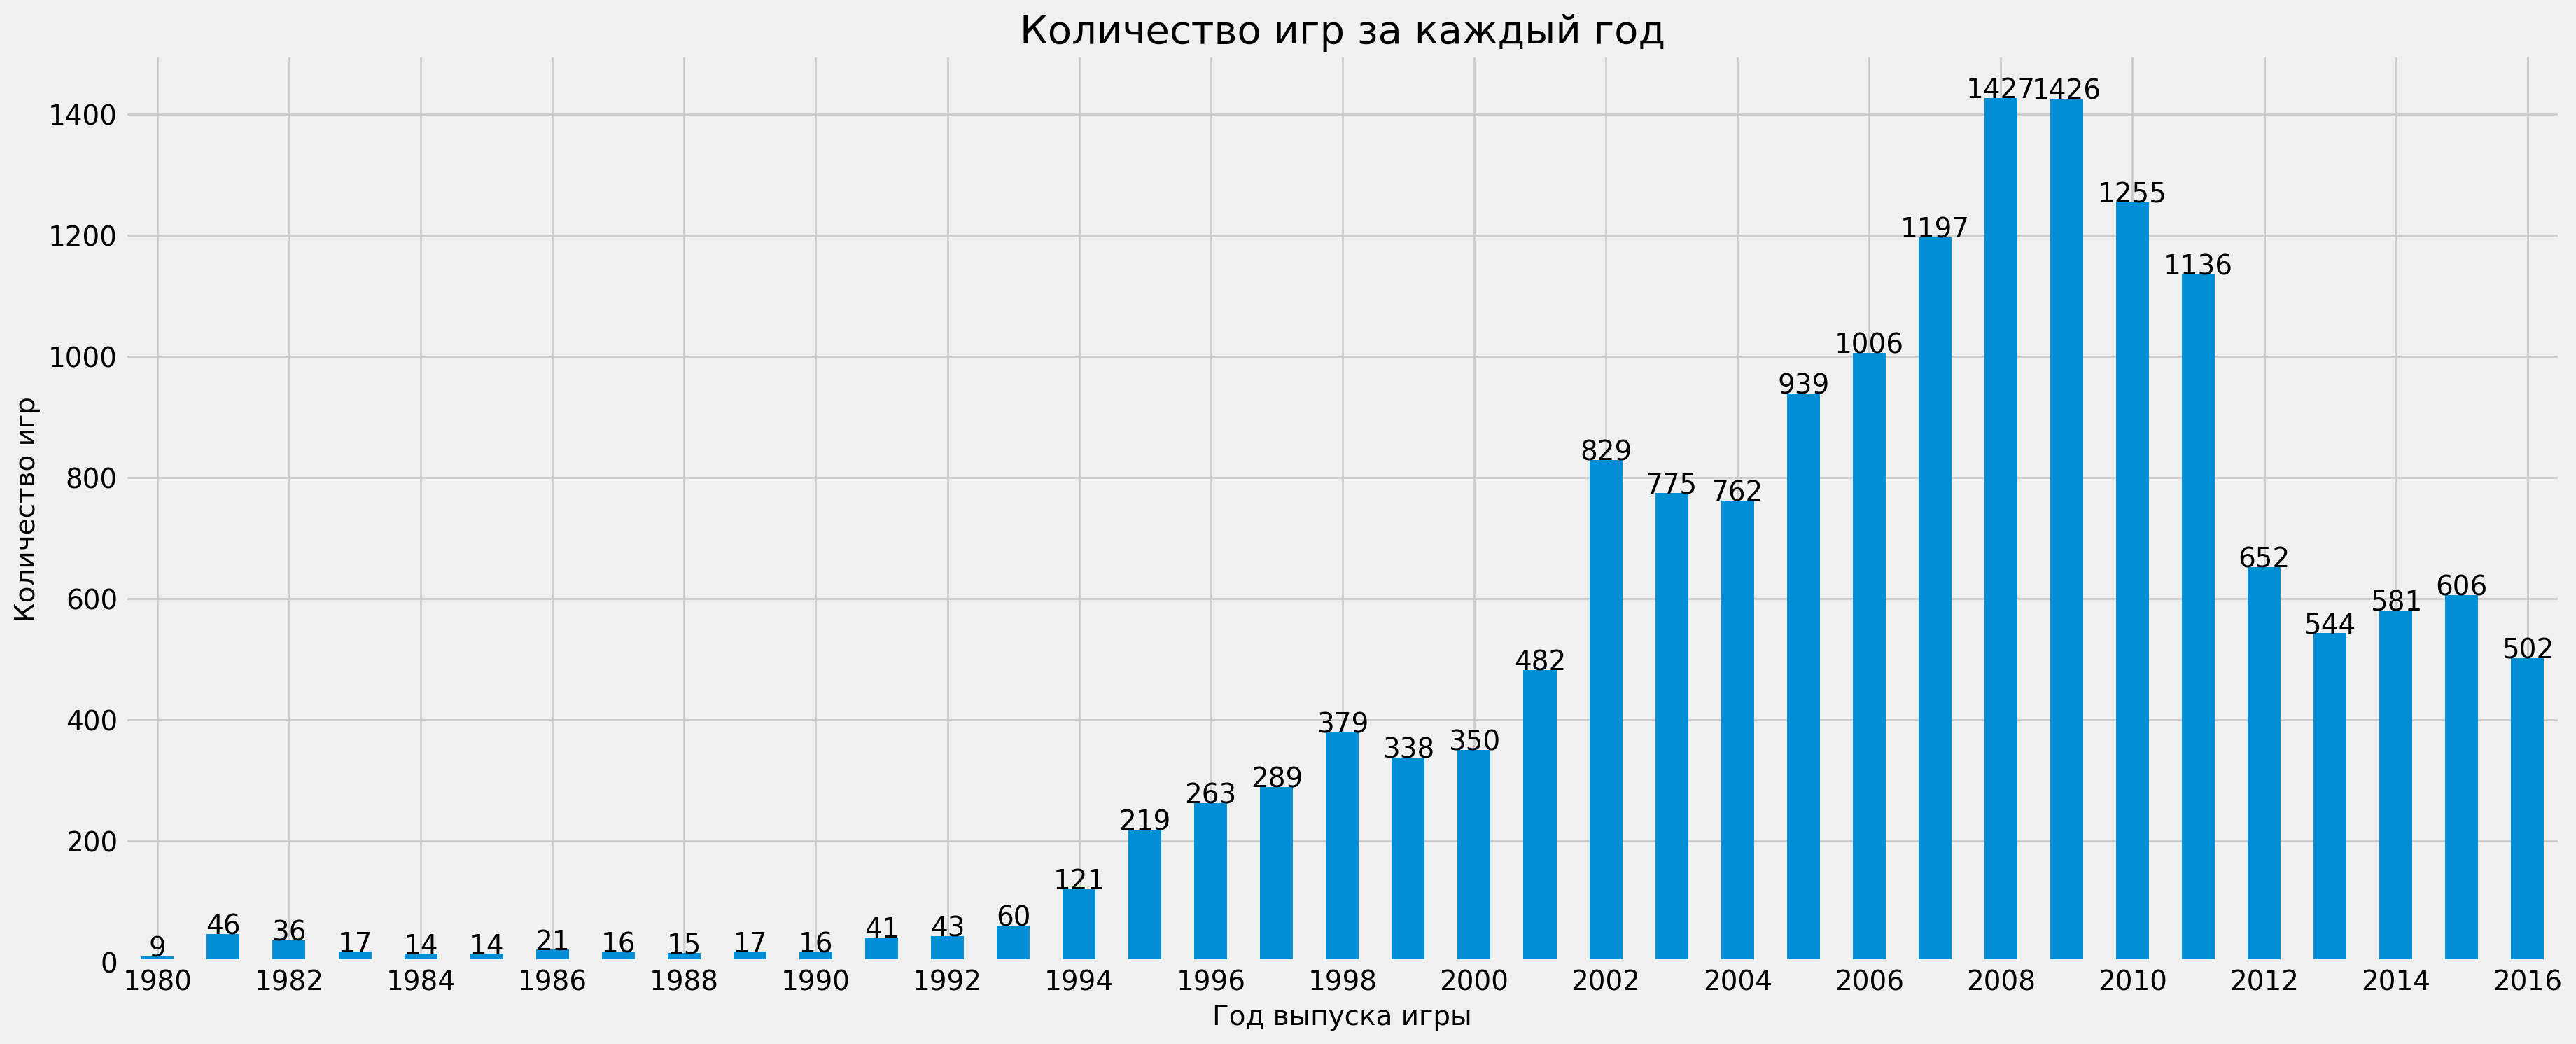

In [30]:
df = table_pivot(games, 'year_of_release', 'year_of_release', 'count')
fig = bar_plot(df, 'year_of_release')
plt.xticks(rotation=0)
plt.xticks(plt.xticks()[0][::2])
addlabels(df['year_of_release'], df['total'])
plt.xlabel('Год выпуска игры')
plt.ylabel('Количество игр')
plt.title('Количество игр за каждый год')
plt.show();

Данные представлены с 1980 по 2016 года выпуска. До 1993 года игр производилось мало, менее 60 в год, но после после 1993 года их значение стало линейно расти с каждым годом. Этот рост продолжался до 1998 года, дальше наступило недолгое затишье (даже небольшое снижение) до 2001 года, и в 2002 году произошёл резкий скачок более, чем в 2 раза. С 2005 года снова произошло резкое увеличение количества выходящих игр вплоть до 2008-2009 годов. После этого наступило такое же резкое снижение, более чем в 2 раза до 2013 года, и далее, вроде как, снова наблюдается небольшая тенденция на увеличение количества релиза новых игр. Данные за 2016 год являются неполными, поэтому на графике количество вышедших игр немного проседает по отношению к предыдущим годам.

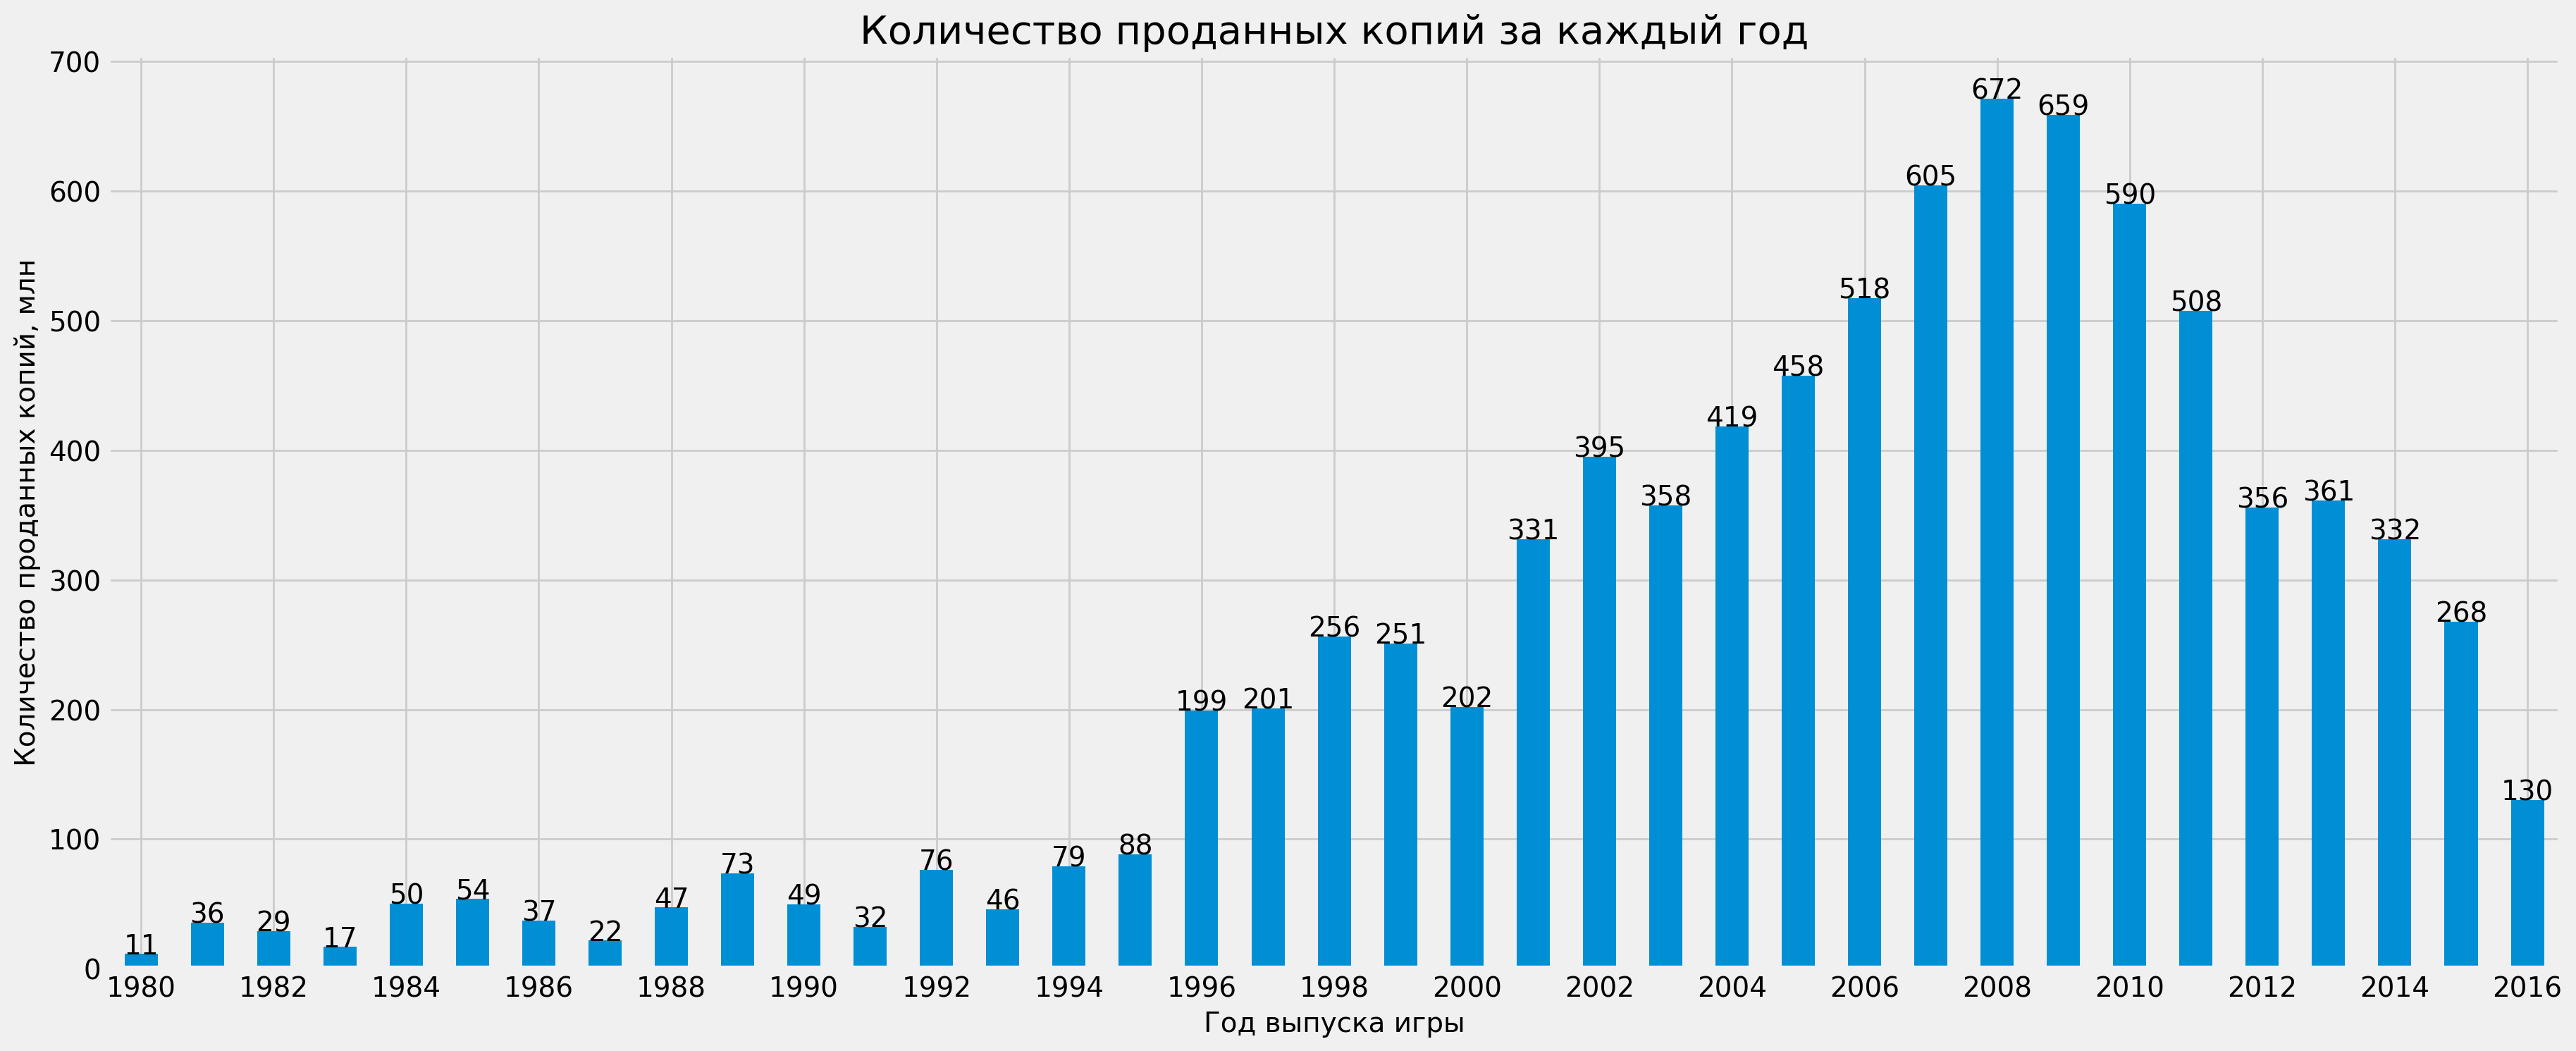

In [31]:
df = table_pivot(games, 'year_of_release', 'sales', 'sum')
fig = bar_plot(df, 'year_of_release')
plt.xticks(rotation=0)
plt.xticks(plt.xticks()[0][::2])
addlabels(df['year_of_release'], df['total'])
plt.xlabel('Год выпуска игры')
plt.ylabel('Количество проданных копий, млн')
plt.title('Количество проданных копий за каждый год')
plt.show();

На графике зависимости проданных копий игр от года релиза игры видно, что распределение имеет более плавные границы, чем рапределение количества игр от года выпуска. Но в целом, распределения имеют одинаковые тенденции.

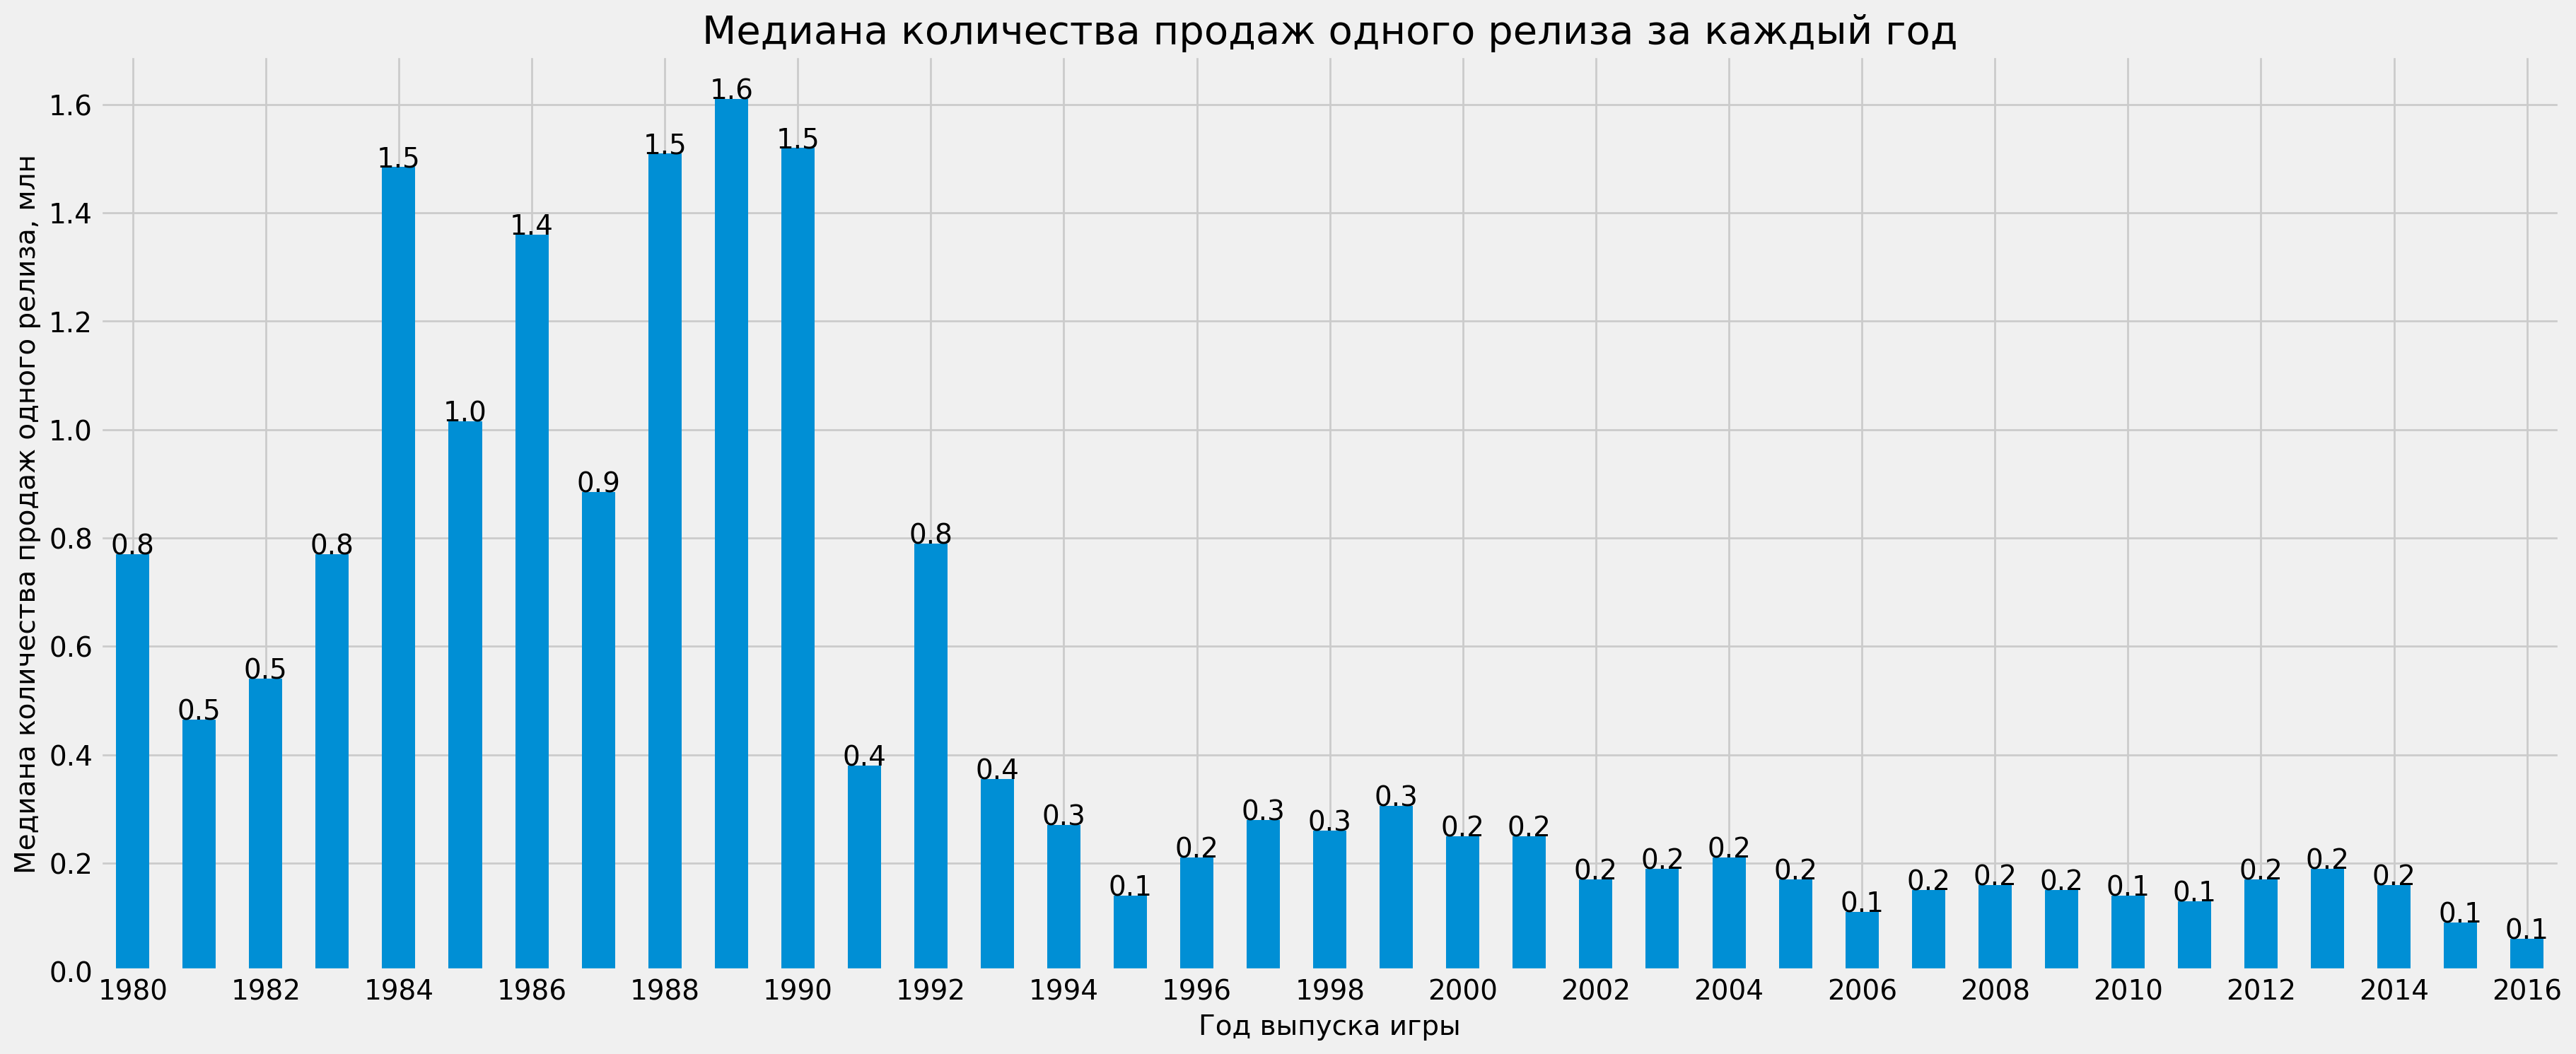

In [32]:
df = table_pivot(games, 'year_of_release', 'sales', 'median')
fig = bar_plot(df, 'year_of_release')
plt.xticks(rotation=0)
plt.xticks(plt.xticks()[0][::2])
for i in range(len(df['year_of_release'])):
    plt.text(i, df.loc[i, 'total'], round(df.loc[i, 'total'], 1), ha = 'center')
plt.xlabel('Год выпуска игры')
plt.ylabel('Медиана количества продаж одного релиза, млн')
plt.title('Медиана количества продаж одного релиза за каждый год')
plt.show();

Тенденции, которые прослеживались для количества выпускаемых игр и суммарных продаж за каждый год, не видны для медианных продаж. Можно отметить, что с 1980 до 1990 шло увеличение медианных продаж, а затем произошёл резкий спад, и с 1993 года идёт слабое уменьшение медианных продаж одного релиза за каждый год. Это можно объяснить тем, что до 1994 года количество игр, выпускаемых каждый год, было маленьким. Затем с каждым годом происходило увеличения роста количества выпускаемых игр, при том, что не все из них, видимо, имели достаточное количество общих продаж по регионам. Отсюда и такой график медианных продаж. Количество не равно качество. 

#### Промежуточный вывод:

- До 1993 года данные об выпущенных играх не особо интересны, так как таких игр было очень мало. 
- Интерес представляют продажи с 2002 года, так как там произошёл резкий скачок вверх по количеству выпускаемых игр. 
- Для прогноза продаж на 2017 год можно взять период с 2012 по 2016 года, так как за это время выпущено примерно одинаковое количество игр, и наблюдается небольшая тенденция к увеличению количества игр.

### Суммарная выручка с разных платформ

Посмотрим на распределение выручки по платформам для игр:

In [33]:
print('Количество уникальных платформ для игр: ', games['platform'].nunique())

Количество уникальных платформ для игр:  31


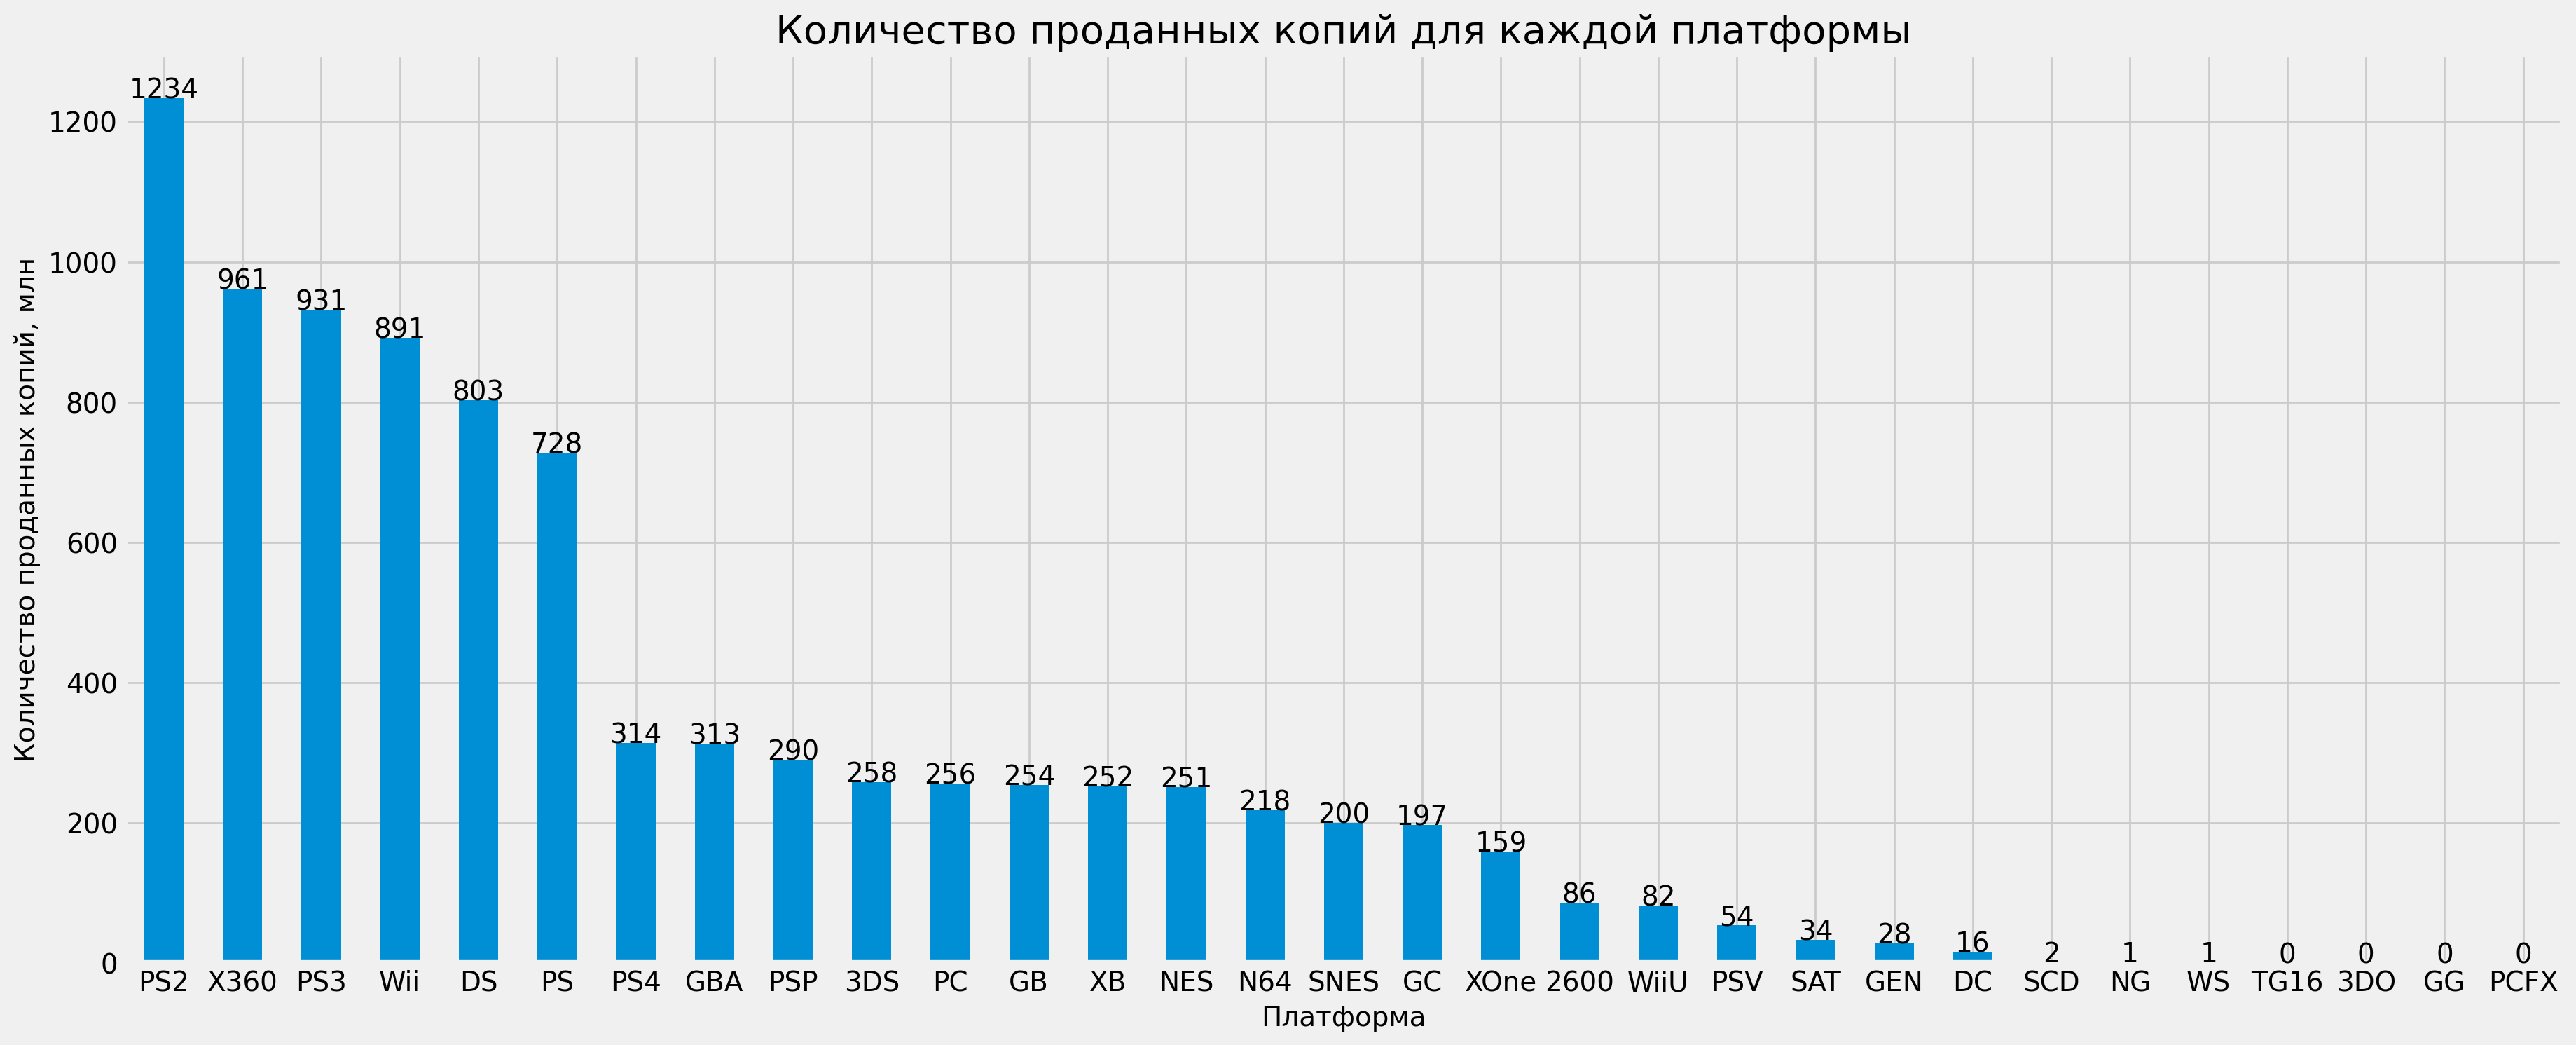

In [34]:
df = table_pivot(games, 'platform', 'sales', 'sum')\
                .sort_values(by='total', ascending=False)\
                .reset_index(drop=True)
fig = bar_plot(df, 'platform')
plt.xticks(rotation=0)
addlabels(df['platform'], df['total'])
plt.xlabel('Платформа')
plt.ylabel('Количество проданных копий, млн')
plt.title('Количество проданных копий для каждой платформы')
plt.show();

Есть топ-6 лидеров по количеству проданных копий игр: PS2, X360, PS3, Wii, DS, PS. Для них количество проданных копий игр по всем странам больше 700 млн копий. На 12 платформах количество продаж меньше 350 млн копий, но выше 150 млн копий по всем странам. На остальных платформах количество продаж меньше 100 млн копий по всем странам.

Посмотрим на время существования каждой платформы:

In [35]:
platform_total = games.groupby(by='platform', as_index=False)\
                      .agg(games = ('sales', 'count'),
                           total_sales = ('sales', 'sum'),
                           median_sales = ('sales', 'median'),
                           first_year = ('year_of_release', 'min'),
                           last_year = ('year_of_release', 'max'))
platform_total['lifetime'] = platform_total['last_year'] - platform_total['first_year']
platform_total.sort_values(by='first_year', ascending=False)

platform  games  total_sales  median_sales  first_year  last_year  lifetime
30     XOne    247       159.32         0.220        2013       2016         3
18      PS4    392       314.14         0.200        2013       2016         3
27     WiiU    147        82.19         0.220        2012       2016         4
2       3DS    512       257.81         0.120        2011       2016         5
20      PSV    429        53.81         0.050        2011       2016         5
17      PS3   1305       931.34         0.280        2006       2016        10
26      Wii   1286       891.18         0.190        2006       2016        10
28     X360   1232       961.24         0.280        2005       2016        11
19      PSP   1193       289.53         0.090        2004       2015        11
7        GC    542       196.73         0.150        2001       2007         6
6       GBA    811       312.88         0.160        2000       2007         7
16      PS2   2127      1233.56         0.230        2000       2011        11
29       XB    803       251.57         0.150        2000       2008         8
25       WS      6         1.42         0.215        1999       2001         2
3        DC     52        15.95         0.135        1998       2008        10
14     PCFX      1         0.03         0.030        1996       1996         0
10      N64    316       218.01         0.270        1996       2002         6
24     TG16      2         0.16         0.080        1995       1995         0
21      SAT    173        33.59         0.120        1994       1999         5
15       PS   1190       727.58         0.260        1994       2003         9
1       3DO      3         0.10         0.020        1994       1995         1
22      SCD      6         1.86         0.065        1993       1994         1
12       NG     12         1.44         0.100        1993       1996         3
9        GG      1         0.04         0.040        1992       1992         0
23     SNES    239       200.04         0.320        1990       1999         9
8       GEN     27        28.35         0.150        1990       1994         4
5        GB     97       254.43         1.180        1988       2001        13
13       PC    957       255.76         0.050        1985       2016        31
4        DS   2121       802.78         0.110        1985       2013        28
11      NES     98       251.05         1.375        1983       1994        11
0      2600    116        86.48         0.480        1980       1989         9

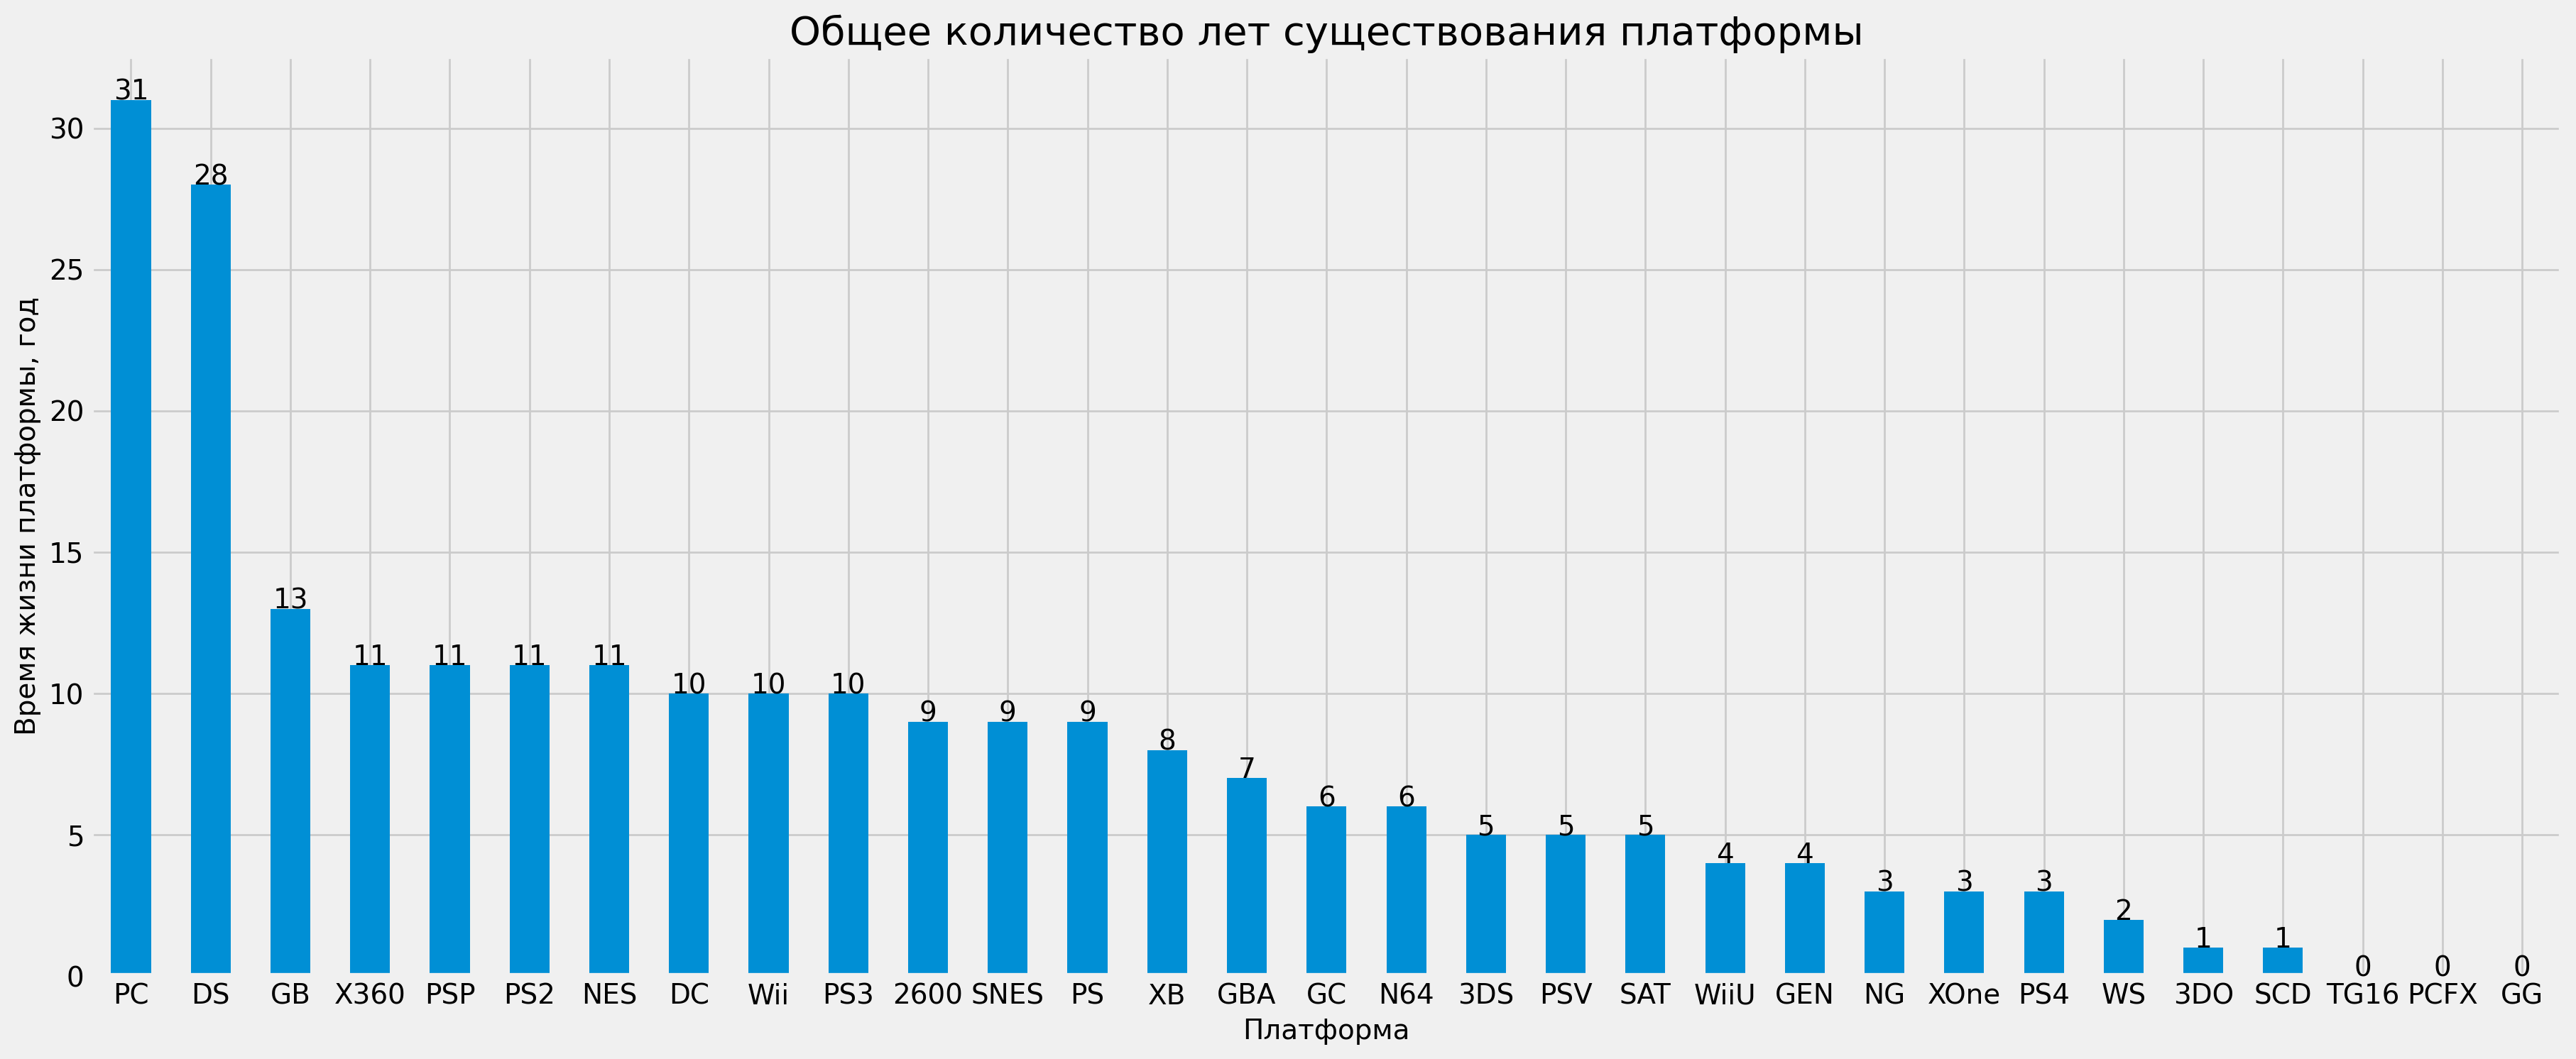

In [36]:
df = platform_total[['platform', 'lifetime']].sort_values(by='lifetime', ascending=False).reset_index(drop=True)
fig = bar_plot(df, 'platform')
plt.xticks(rotation=0)
addlabels(df['platform'], df['lifetime'])
plt.xlabel('Платформа')
plt.ylabel('Время жизни платформы, год')
plt.title('Общее количество лет существования платформы')
plt.show();

Две платформы обладали наибольшим количеством лет своего существования: PC и DS - около 30 лет. Но при этом по медианным продажам эти платформы находятся в самом низу списка. Видимо, с момента их появления в 1985 году, на какое-то время они были забыты, и ближе к 2013 году снова выстрелили с какими-то играми, возможно, обновлением старой игры. В целом, если смотреть на время жизни всех платформ, большинство из них сосредоточена в области 10 лет. Некоторые из них были выпущены после 2006 года и всё ещё активны к моменту 2016.

Посмотрим как менялось количество проданных копий игр по годам по каждой из топ-6 платформ по количеству проданных копий:

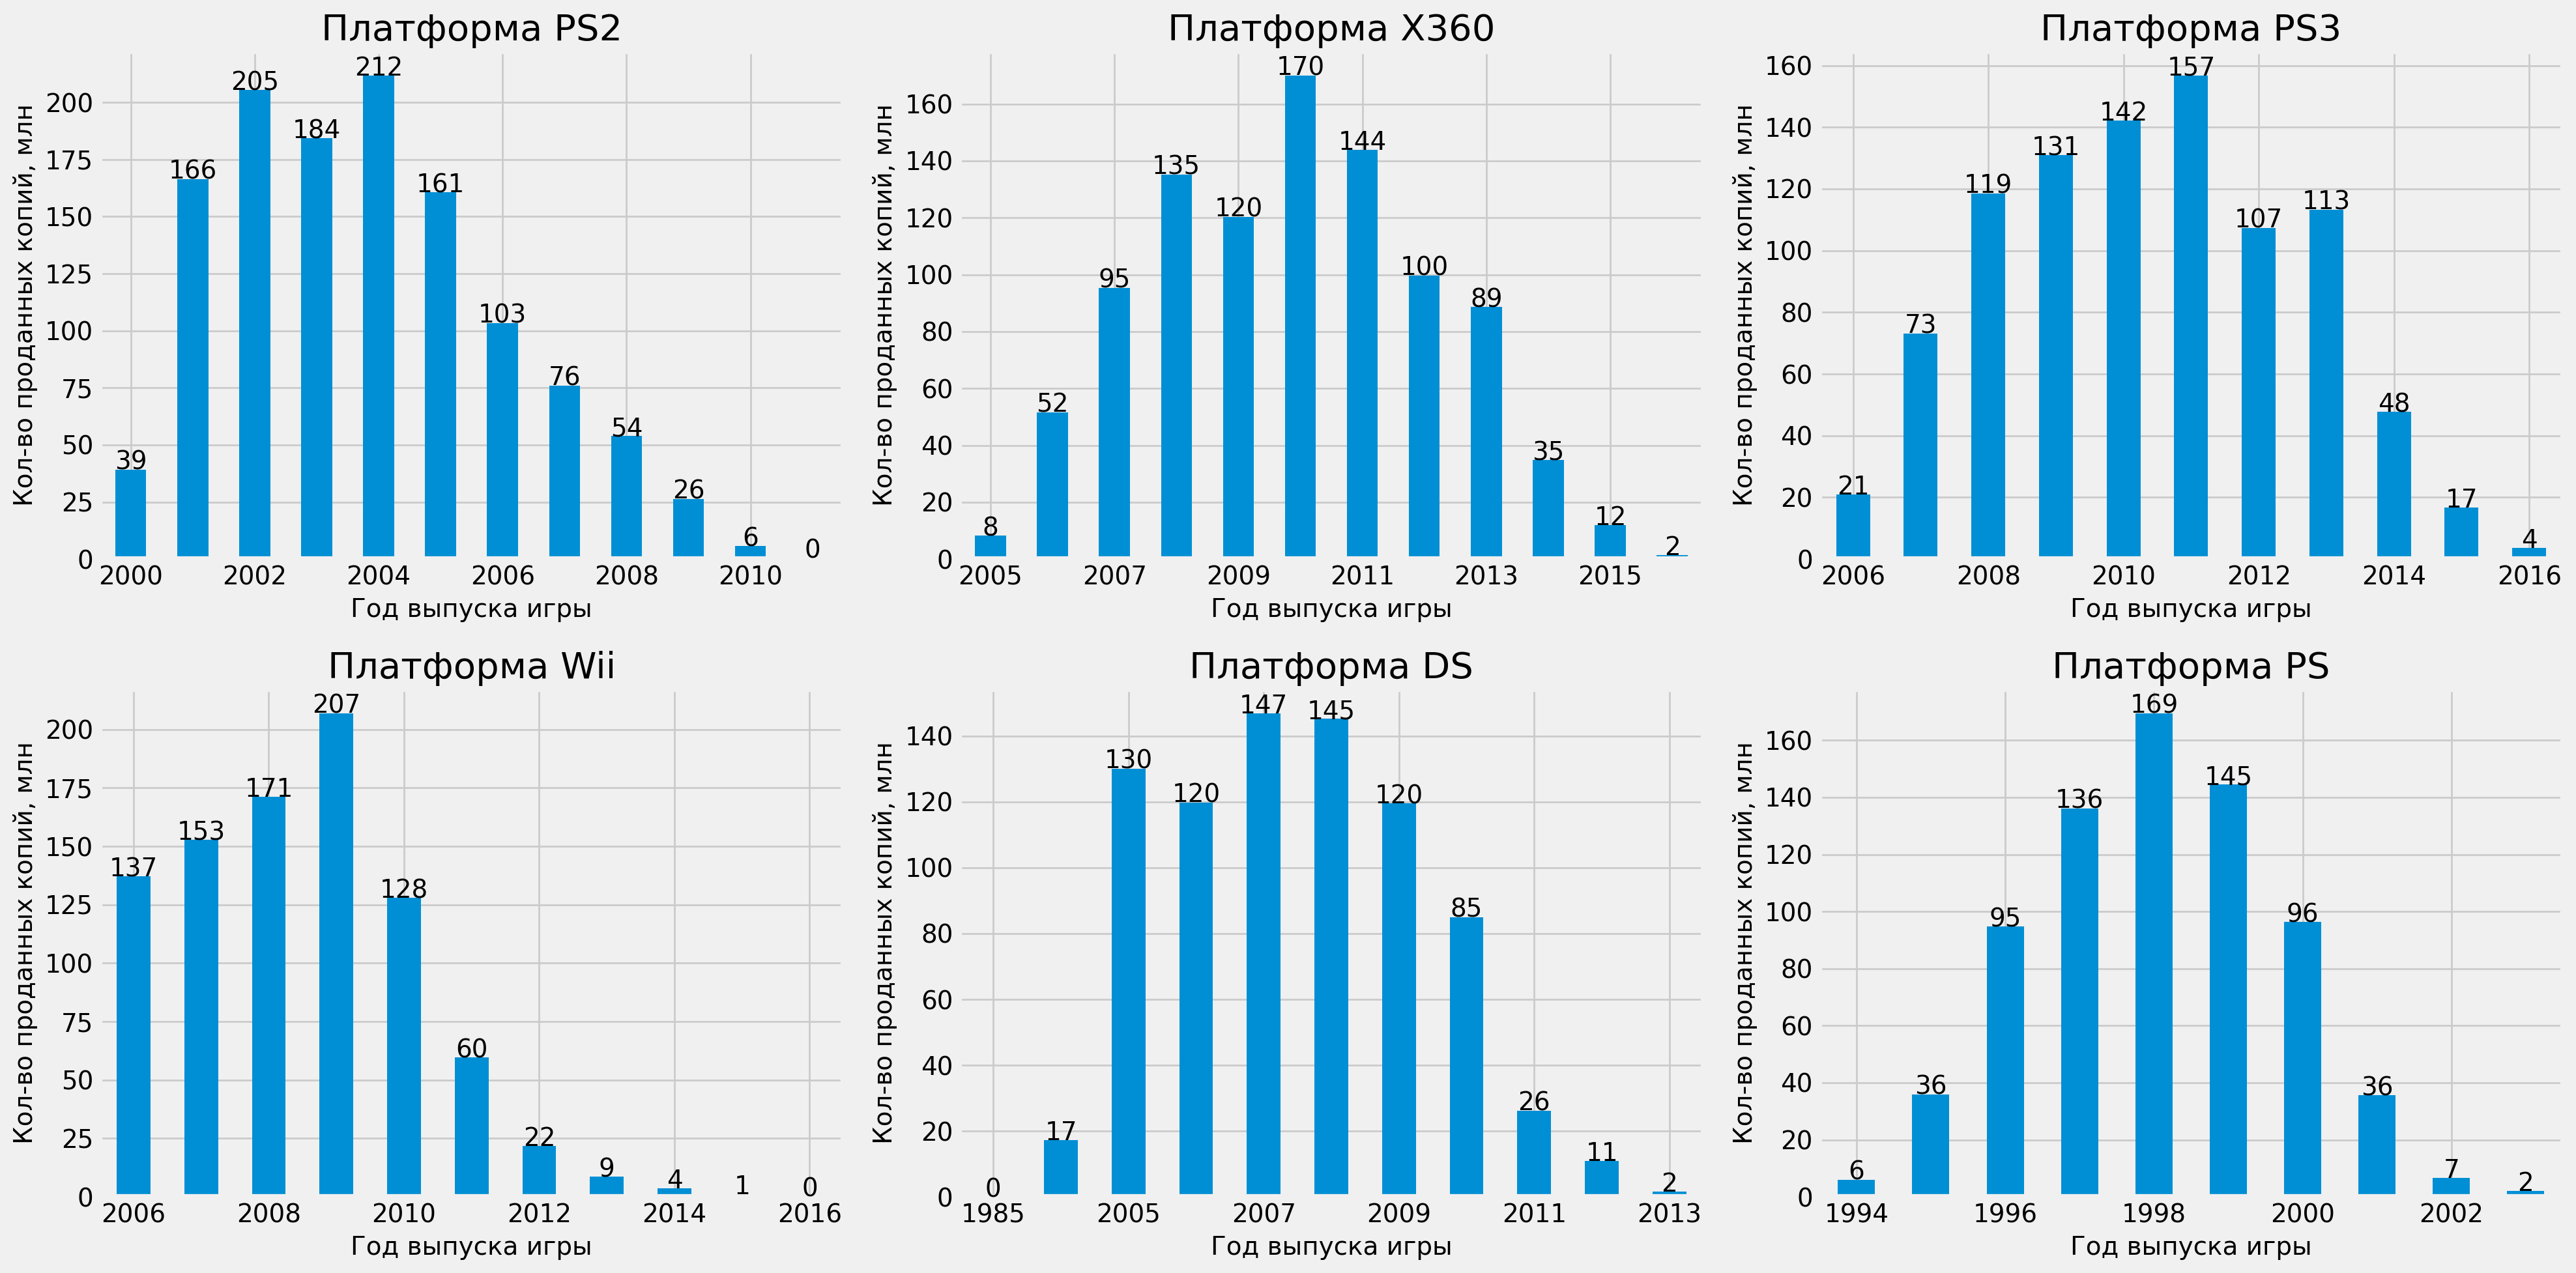

In [37]:
top_platform = table_pivot(games, 'platform', 'sales', 'sum')\
                          .sort_values(by='total', ascending=False)\
                          .reset_index(drop=True)
top_platform_sale(games, top_platform.head(6)['platform'].to_list())

Из графиков видно, что все эти платформы имели активные продажи в разные года. 
- Платформа PS2 (лидер по количеству продаж) начала своё существование в 2000, а закончила в 2011 году. При этом распределение имеет характерный сдвиг в левую сторону: резкий скачок продаж в 2001 году, удержание позиций по 2004 год включительно, и плавный спад до 2011 года.
- Для платформы X360 с 2005 года по 2010 наблюдается плавный рост продаж, максимум приходится на 2010 год, а затем начинается спад вплоть до 2016 года.
- Платформа PS3 существует с 2006 по 2016 год включительно. С 2006 по 2011 года происходило плавное увеличение количества проданных копий, в 2012 году произошёл резкий спад вниз, который продолжился с 2014 по 2016 год.
- Платформа Wii начала свой старт с 2006 года, причём сразу со 130 млн проданных копий. До 2009 года включительно рост продаж увеличивался, а затем резко начал падать вниз. В 2016 году было продано меньше 1 млн копий.
- Платформа DS существовала с 1985 по 2013 года, при этом какие-то существенные продажи начались с 2003 года, резкое возрастание продаж произошло в 2005 году, а пик продаж пришёлся на 2007-2008 года, и после этого начал резко затухать.
- Платформа PS по динамике роста и спада продаж похожа на X360 и существовала с 1994 по 2005 года, пик продаж пришёлся на 1998 год, и до этого моммента возрастал так же, как и затем к 2005 году спадал.

#### Промежуточный вывод:

- Срок жизни платформ составляет 10 лет. При этом у большинства поначалу начинается плавный рост количества продаж, затем доходит до пикового значения и начинается спад вниз.
- Из топ-6 только платформа Wii выстрелила с самого начала существования большим количеством проданных копий игр.
- Пиковые значения максимума продаж игр на платформах приходятся на 5-6 год существования платформы.
- За 2012-2016 года выпущено примерно одно и то же количество игр, наблюдается небольшая тенденция к увечеличению.
- Для прогноза на 2017 год с учётом этих двух факторов для рассмотрения лучше взять именно года с 2012 по 2016, и посмотреть платформы, которые начали своё существования в этот период времени. В таком случае пик жизни платформы придётся примерно на 2017 год.

### Лидеры по продажам среди платформ

Оставим данные для годов, начиная с 2012.

In [38]:
# Выборка за годы начиная с 2012
games_prediction = games.query('year_of_release >= 2012').reset_index(drop=True)
games_prediction.head()

name platform  year_of_release         genre  \
0          grand theft auto v      PS3             2013        Action   
1          grand theft auto v     X360             2013        Action   
2   call of duty: black ops 3      PS4             2015       Shooter   
3         pokemon x/pokemon y      3DS             2013  Role-Playing   
4  call of duty: black ops ii      PS3             2012       Shooter   

   na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
0      7.02      9.09      0.98         3.96          97.0         8.2   
1      9.66      5.14      0.06         1.41          97.0         8.1   
2      6.03      5.86      0.36         2.38           NaN         NaN   
3      5.28      4.19      4.35         0.78           NaN         NaN   
4      4.99      5.73      0.65         2.42          83.0         5.3   

    rating  sales  
0        M  21.05  
1        M  16.27  
2  no_ESRB  14.63  
3  no_ESRB  14.60  
4        M  13.79

In [39]:
top_platform = table_pivot(games_prediction, 'platform', 'sales', 'sum')\
                          .sort_values(by='total', ascending=False)\
                          .reset_index(drop=True)

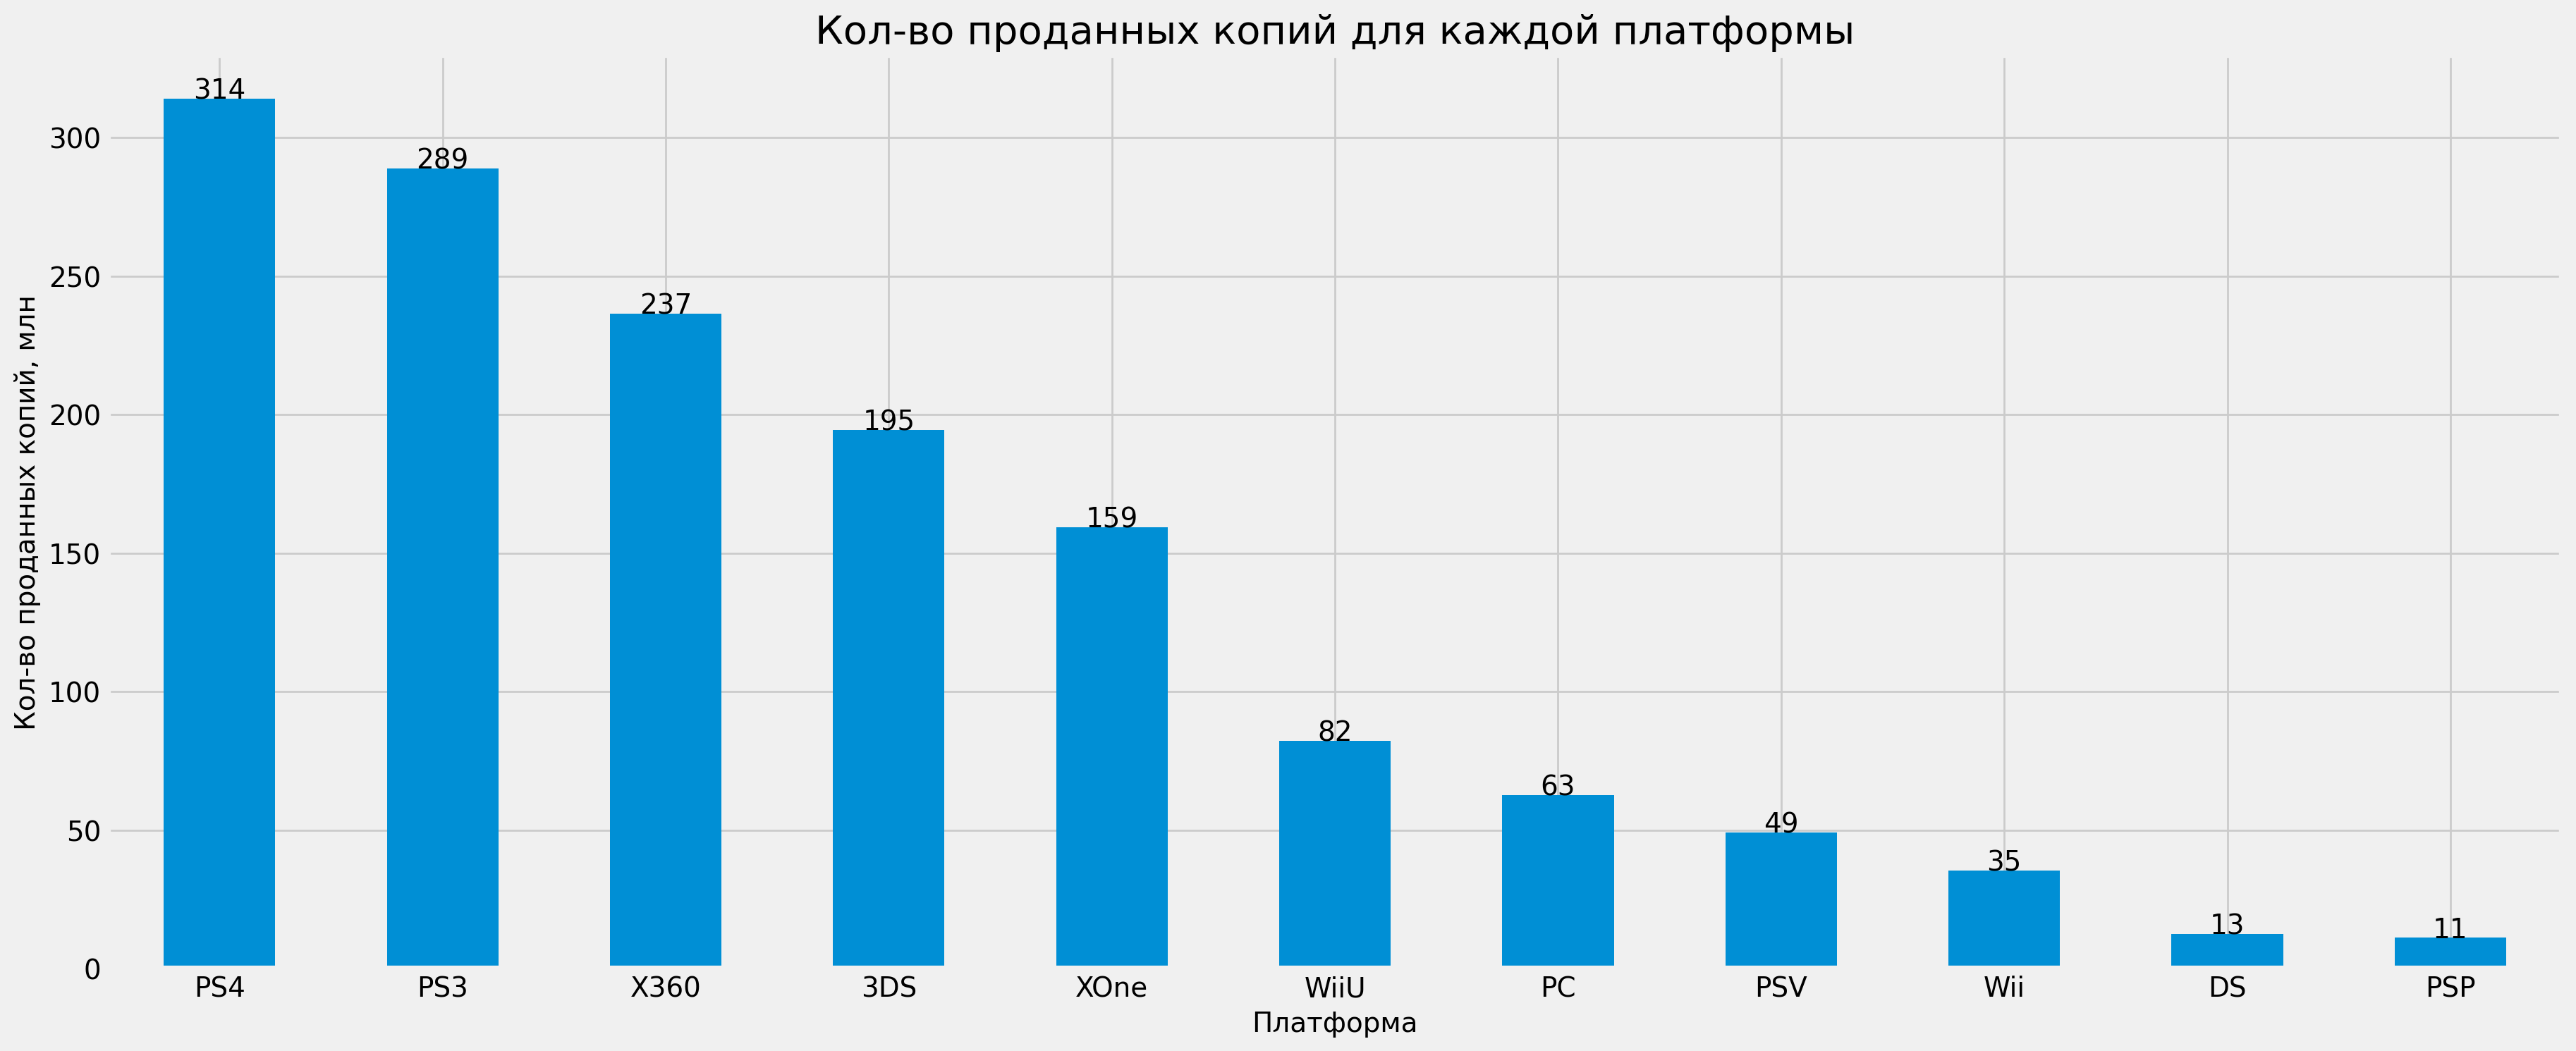

In [40]:
# Суммарная выручка по платформам с 2012 года
df = top_platform
fig = bar_plot(df, 'platform')
plt.xticks(rotation=0)
addlabels(df['platform'], df['total'])
plt.xlabel('Платформа')
plt.ylabel('Кол-во проданных копий, млн')
plt.title('Кол-во проданных копий для каждой платформы')
plt.show();

Первое место по продажам занимает PS4, но от неё недалеко ушла PS3. Ещё в топ-5 платформ по прибыльности входят X360, 3DS и XOne.

Посмотрим глобальные продажи игр в разбивке по платформам:

In [41]:
fig = px.box(games_prediction,
             x='platform', 
             y='sales',
             color='platform',
             category_orders={'platform': games_prediction.groupby(by=['platform'])['sales'] \
                                                          .median()\
                                                          .sort_values(ascending=False)\
                                                          .index.to_list()})
fig.update_layout(title='Глобальные продажи игр в разбивке по платформам',
                  xaxis=dict(title='Платформа'),
                  yaxis=dict(title='Количество проданных копий, млн',
                             range=[0, 2]),
                  showlegend=False)
fig.show()

Наибольшое количество проданных копий игр имеют такие платформы, как: X360, PS4, PS3, XOne, Wii и WiiU. У них помимо широкого окна основной массы проданных игр медианное значение находится на уровне 250 тыс продаж. Наименьшее количество продаж приходится на такие платформы, как: PSV, PSP и DS. Для этих платформы значения выше 500 тыс копий считаются единичными выбросами. На счёт PC (персональный компьютер) можно отметить, что небольшие показатели с этой платформы могут означать, что для пользователя проще найти пиратскую версию игры, чем для приставок. Отсюда и такие небольшие продажи игр по всему миру относительно других платформ.

Посмотрим на распределение продаж по выбранным годам для каждой платформы:

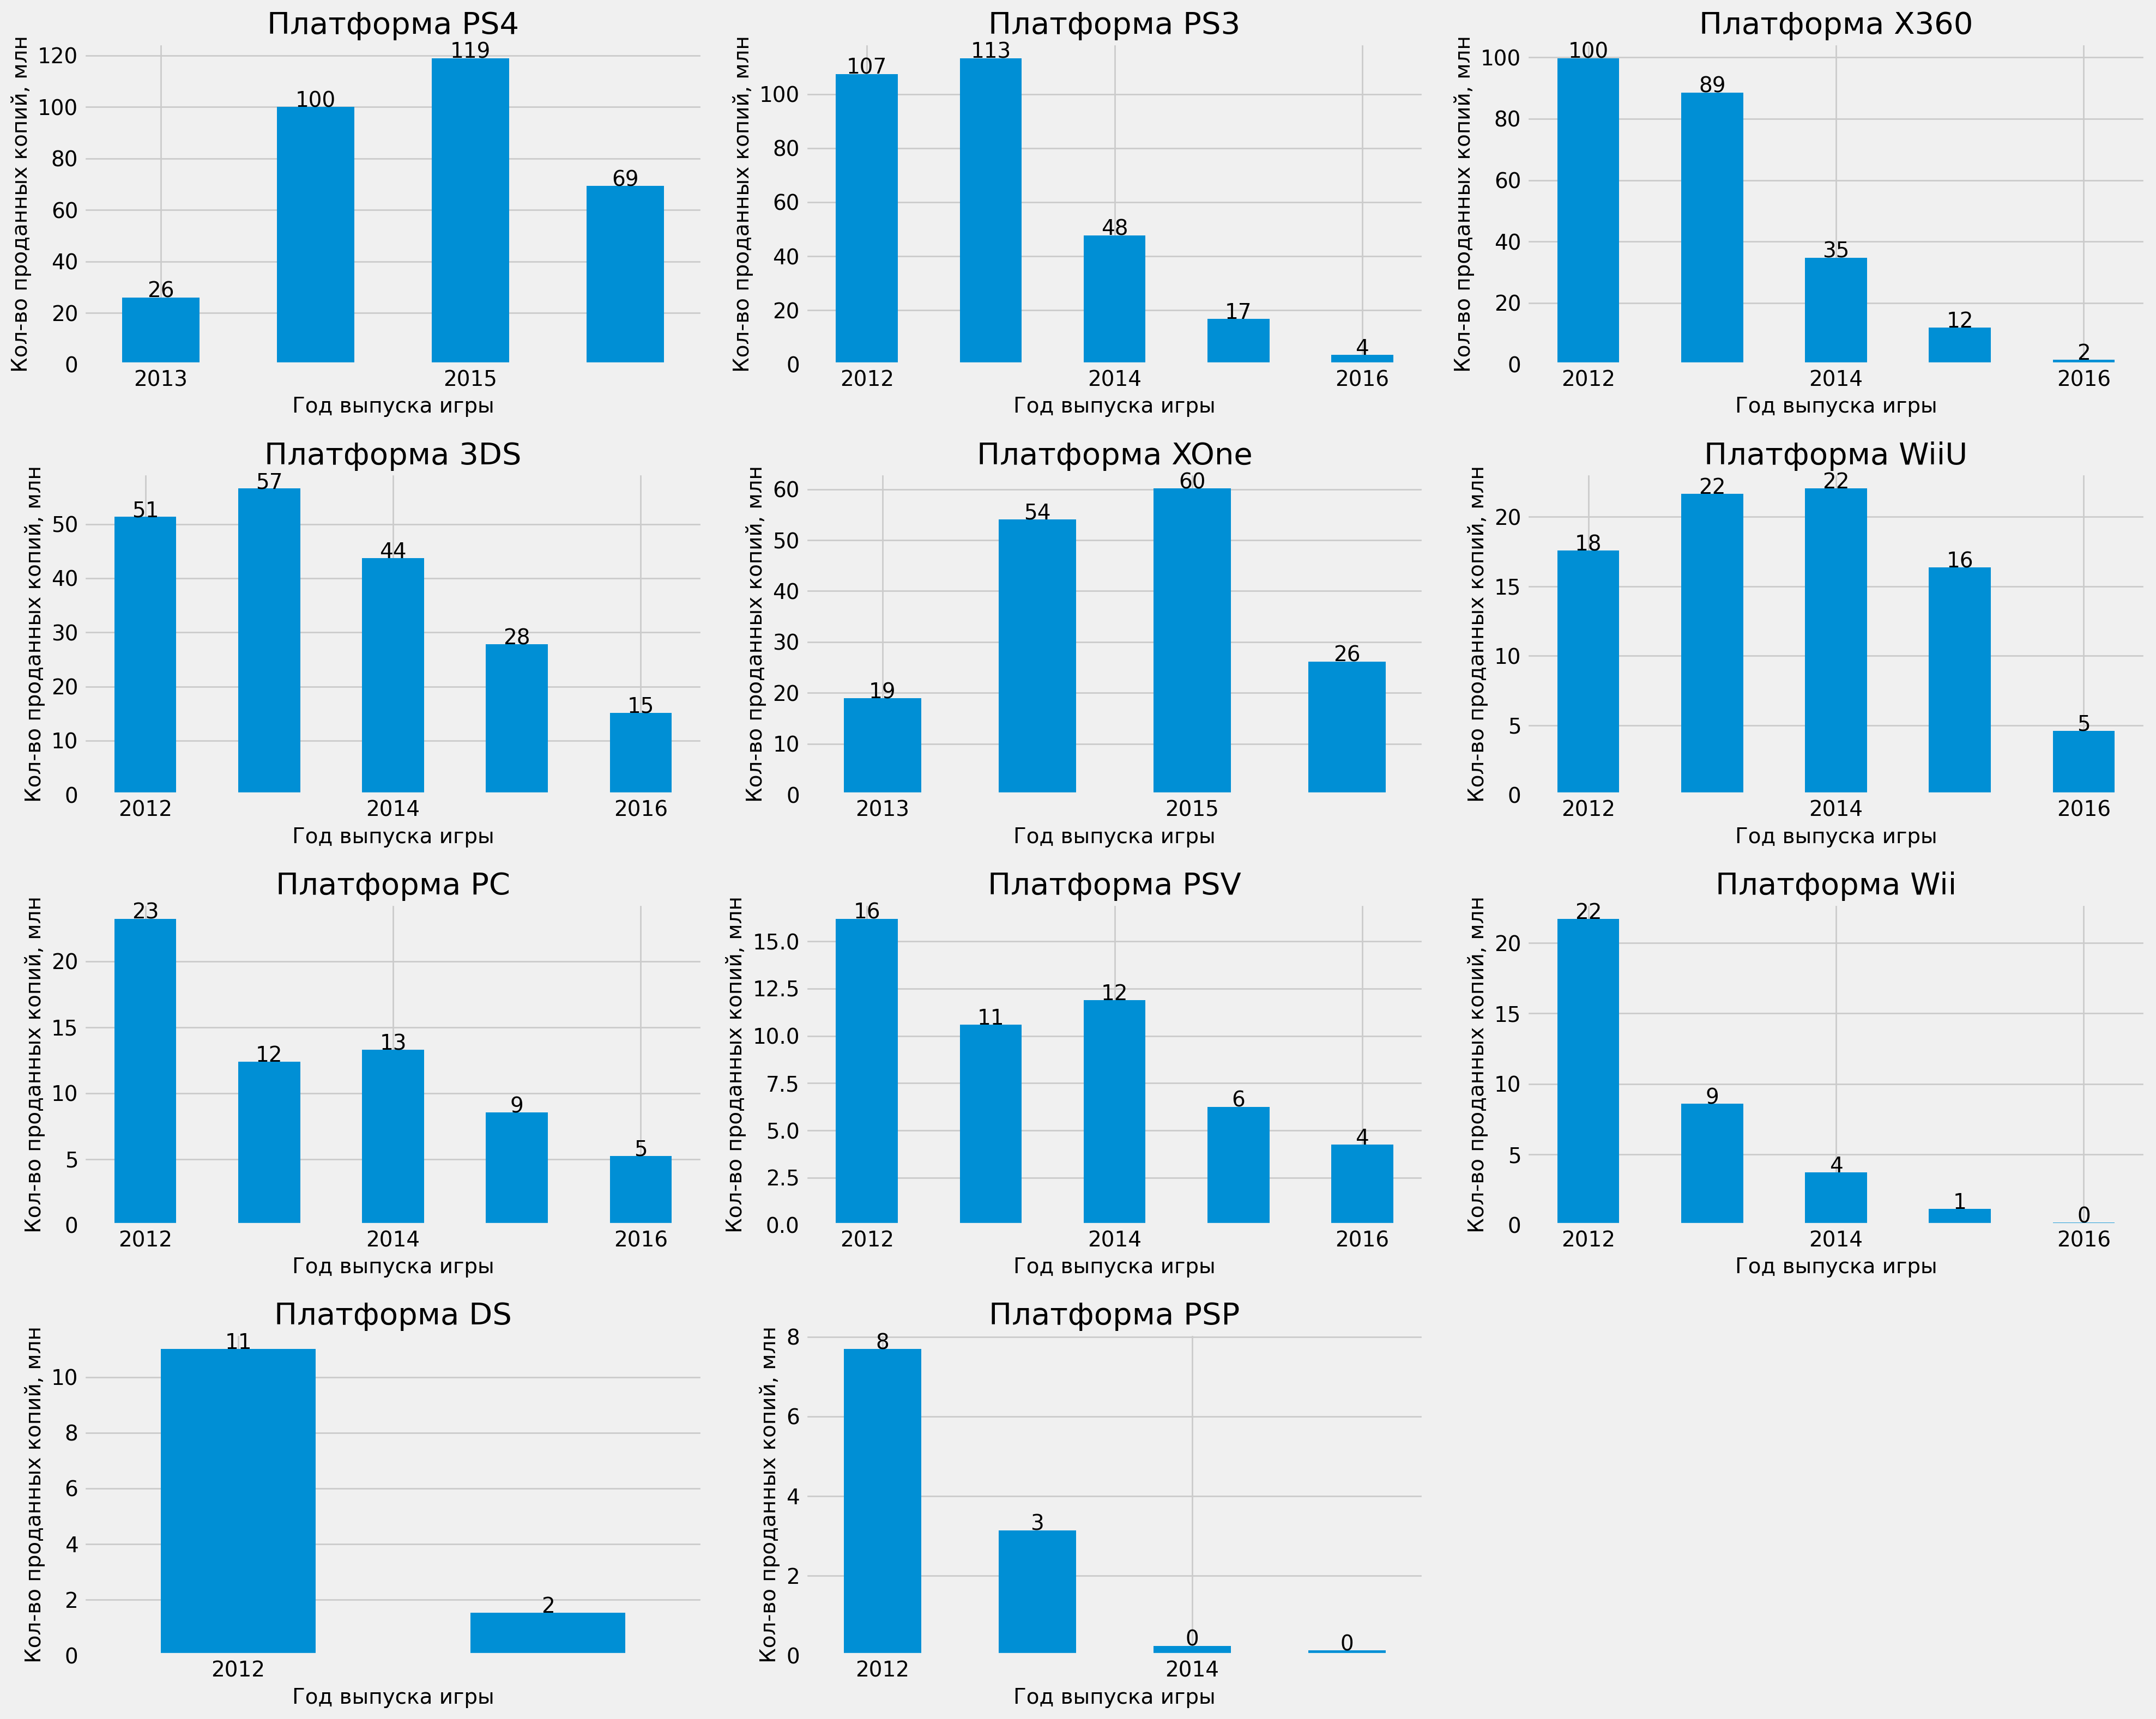

In [42]:
top_platform_sale(games_prediction, top_platform['platform'].to_list())

Из графиков видно, что некоторые платформы, несмотря на большое количество суммарных продаж в выбранные годы, подходят к завершению своего срока существования. Это можно определить по спаду количества проданных копий с 2012 по 2016 года. 
* К платформам, которые набирают популярность относятся: PS4, XOne (начали старт в 2013 году, резкий рост продаж в течение последних двух лет)
* Потенциально прибыльной может оказаться ещё WiiU, так как её спад начался только в 2015 году
* Платформы, которые однозначно не стоит рассматривать в качестве прибыльных (срок жизни подходит к концу): DS, PS3, PSP, Wii, X360. У платформы 3DS также наблюдается тенденция к уменьшению продаж с каждым годом
* У остальных двух платформ: PC, PSV нет тенденции к резкому увеличению или снижению продаж в рассматриваемые годы, но количество проданных копий в 2014-2015 годы достаточно мало по отношению к прибыльным платформам (меньше 10 млн)

#### Промежуточные выводы:

- Потенциально прибыльные платформы в 2017 году PS4, XOne, так как старт продаж игр начался в 2013 году и на 2017 придут пиковые значения.
- Спад для платформы WiiU начался только в 2015 году, поэтому она тоже может остаться потенциально прибыльной в 2017.
- Платформы, у которых срок жизни подходит к концу: DS, PS3, PSP, Wii, X360, 3DS. Это несмотря на их суммарную прибыльность за выбранные годы.
- Для крупных платформ среднее значение 250 тыс копий является хорошим показателем.

### Влияние на продажи отзывов пользователей и критиков

Посмотрим, как влияют на продажи игр отзывы пользователей и критиков:

In [43]:
games_for_score = games_prediction.loc[:,['platform', 'sales', 'critic_score', 'user_score']]

In [44]:
games_for_score

platform  sales  critic_score  user_score
0         PS3  21.05          97.0         8.2
1        X360  16.27          97.0         8.1
2         PS4  14.63           NaN         NaN
3         3DS  14.60           NaN         NaN
4         PS3  13.79          83.0         5.3
...       ...    ...           ...         ...
2880      PSV   0.01           NaN         NaN
2881      PSV   0.01           NaN         NaN
2882      PS3   0.01           NaN         NaN
2883      PSV   0.01           NaN         NaN
2884      PSV   0.01           NaN         NaN

[2885 rows x 4 columns]

In [45]:
# корреляция между продажами и оценкой критиков и пользователей
games_for_score[games_for_score.columns[1:4]].corr().style.format('{:.2f}').background_gradient('Blues')

Влияние оценки пользователей не существенно на продажи игры, но вот оценка критиков имеет небольшое влияние. Посмотрим подробнее на влияние для каждой из топа платформ.

In [46]:
top_list = ['PS4', 'XOne', 'WiiU']

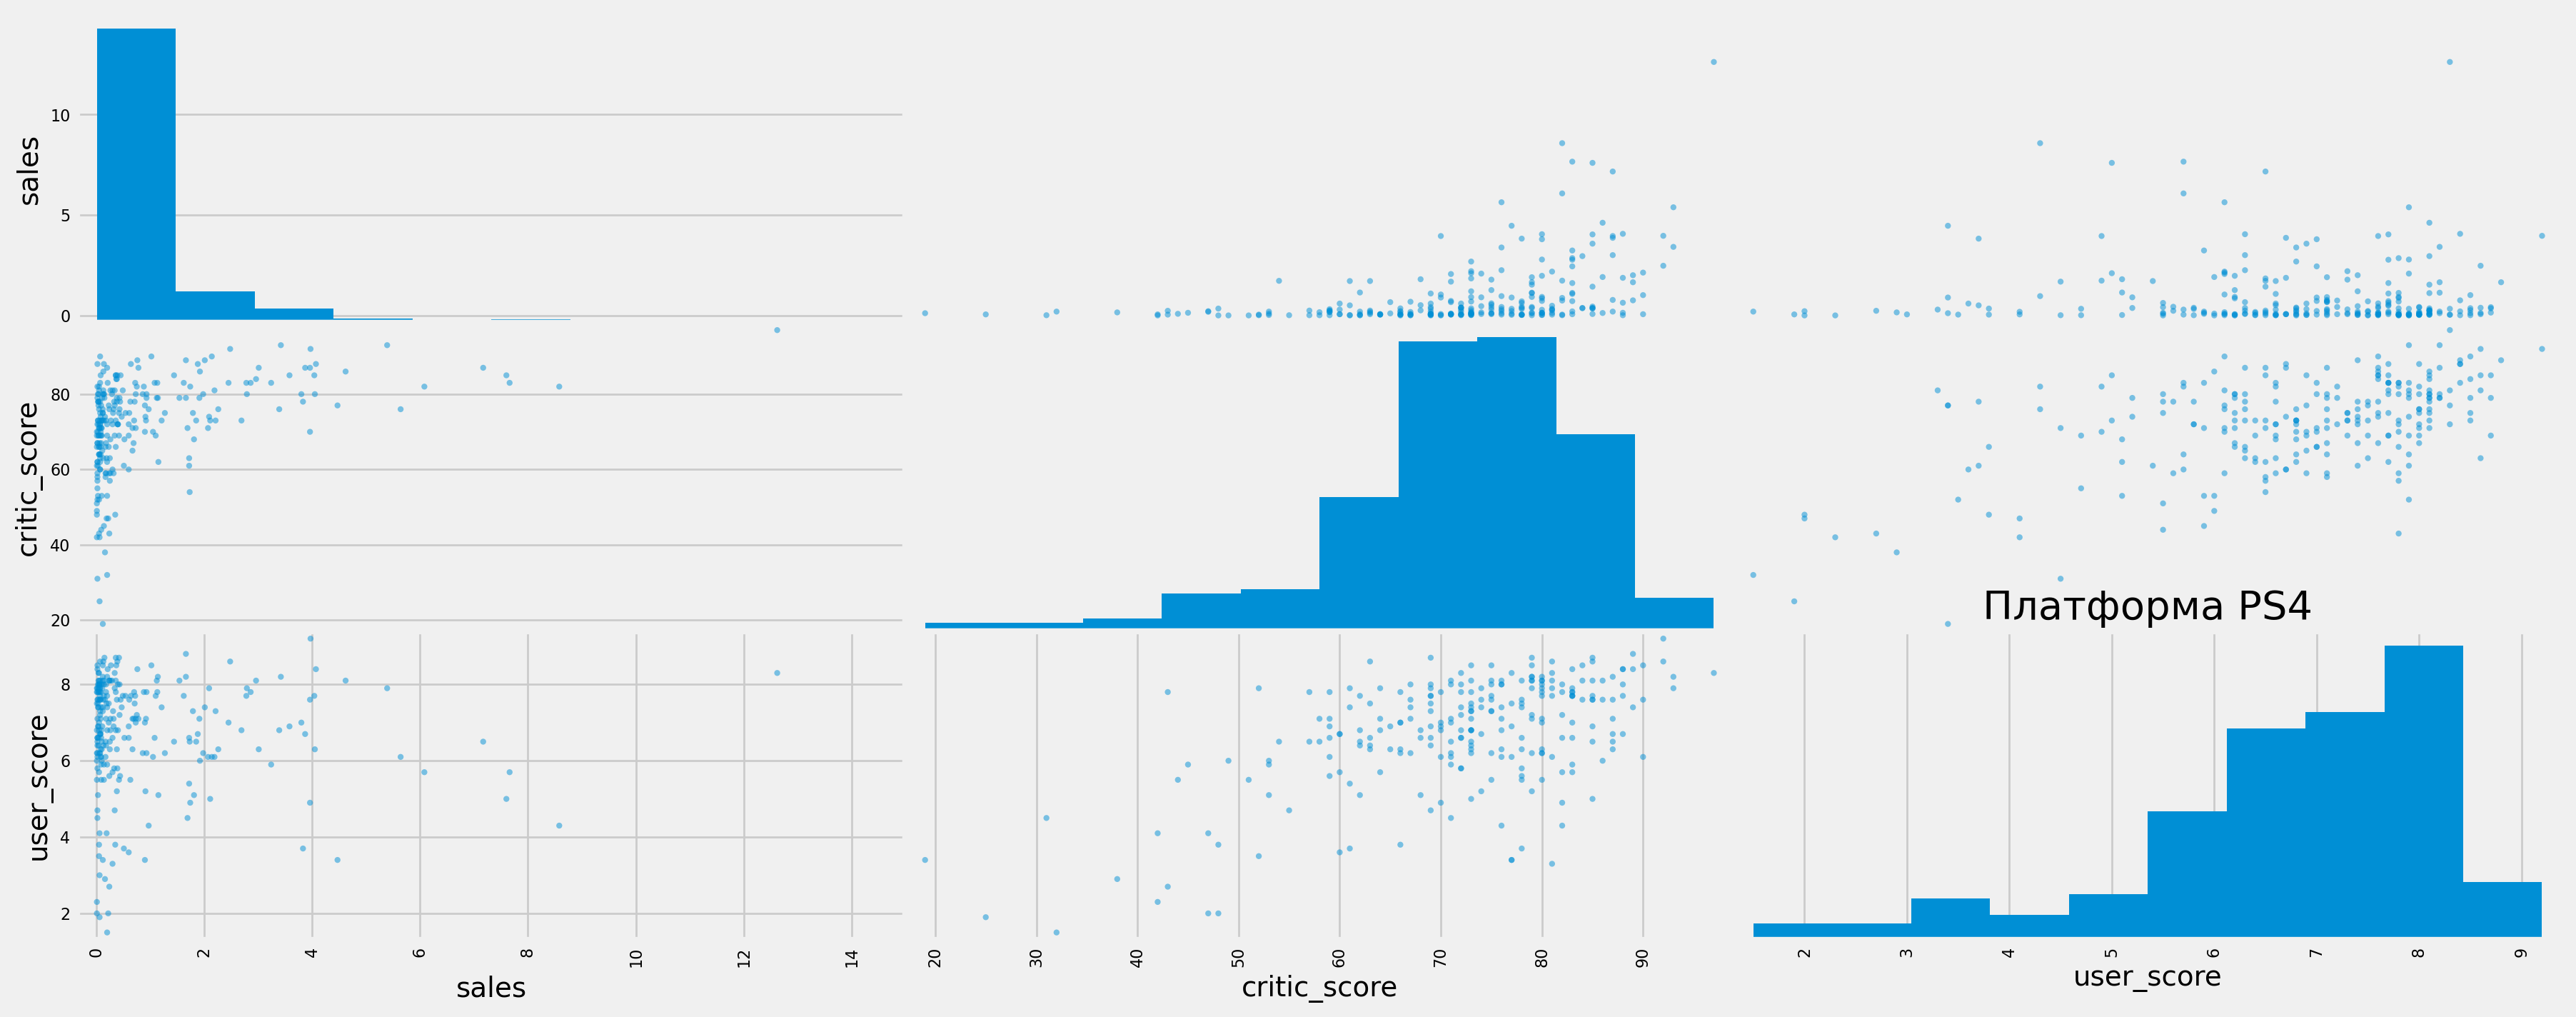

In [47]:
corr_score(games_for_score, top_list[0])

Для самой популярной платформы по продажам PS4 влияние оценки критиков на продажи чуть существеннее, чем мы видели на общем рейтинге для всех платформ сразу.

Из диаграмм рассеяния можно отметить, что для игр на PS4 оценка игроков в основном сосредоточена от 5 до 10. При этом видно, что она имеет бОльший разброс на продажи, чем оценка критиков. И основной пик на гистограммах для оценки критиков приходится на 70-75, а для оценки игроков - на 7.5.

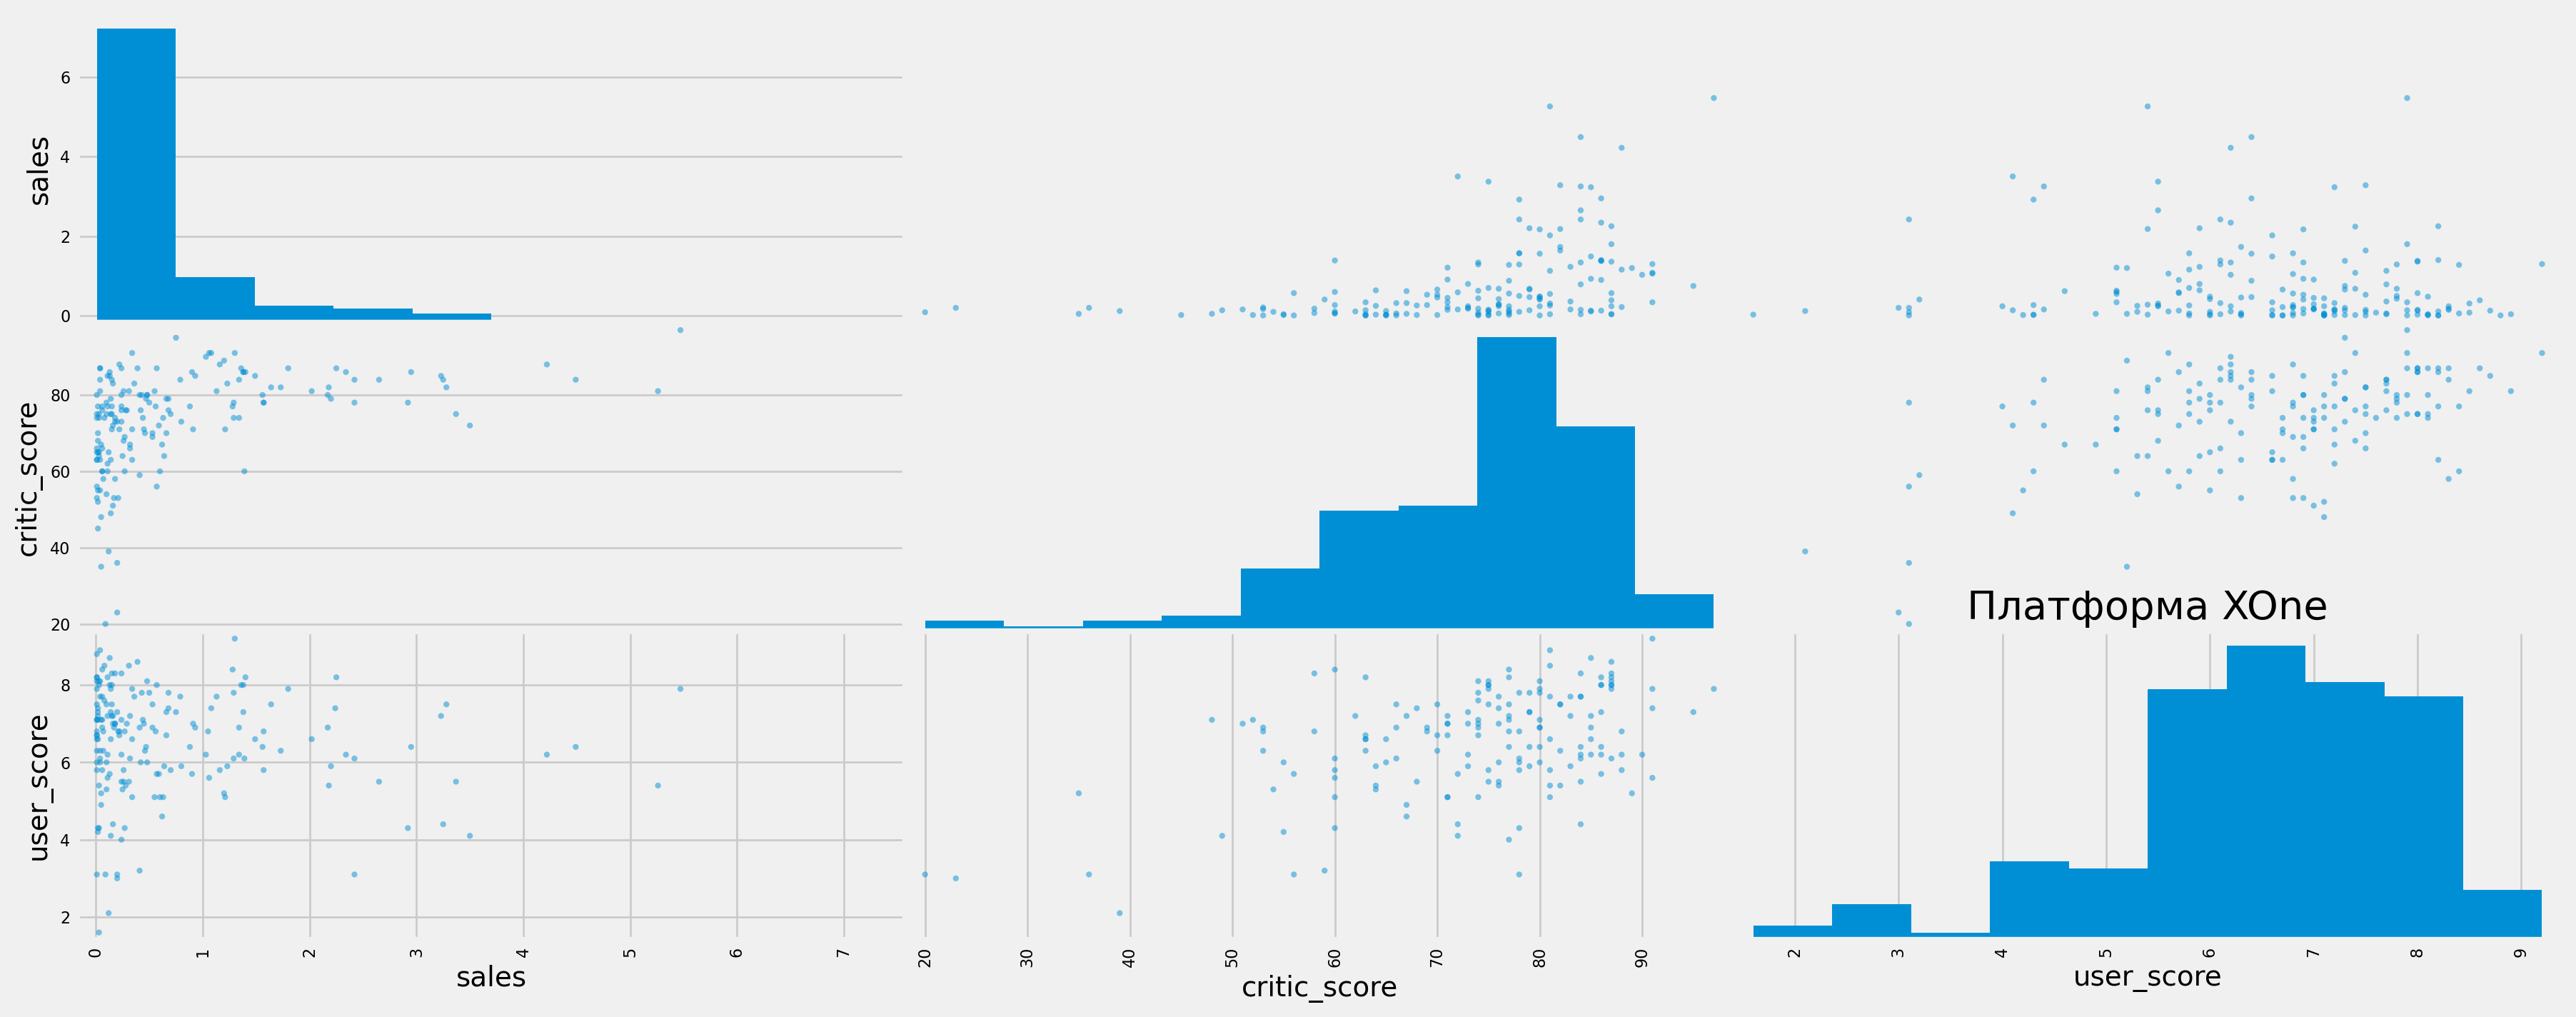

In [48]:
corr_score(games_for_score, top_list[1])

Для XOne, которая набирает обороты за выбранные годы, также получилось, что влияние критиков гораздо существеннее, чем оценка игроков. При этом, оценка критиков осталась примерно на том же уровне, как и для PS4, но оценка игроков стала хуже - в области 6-7.

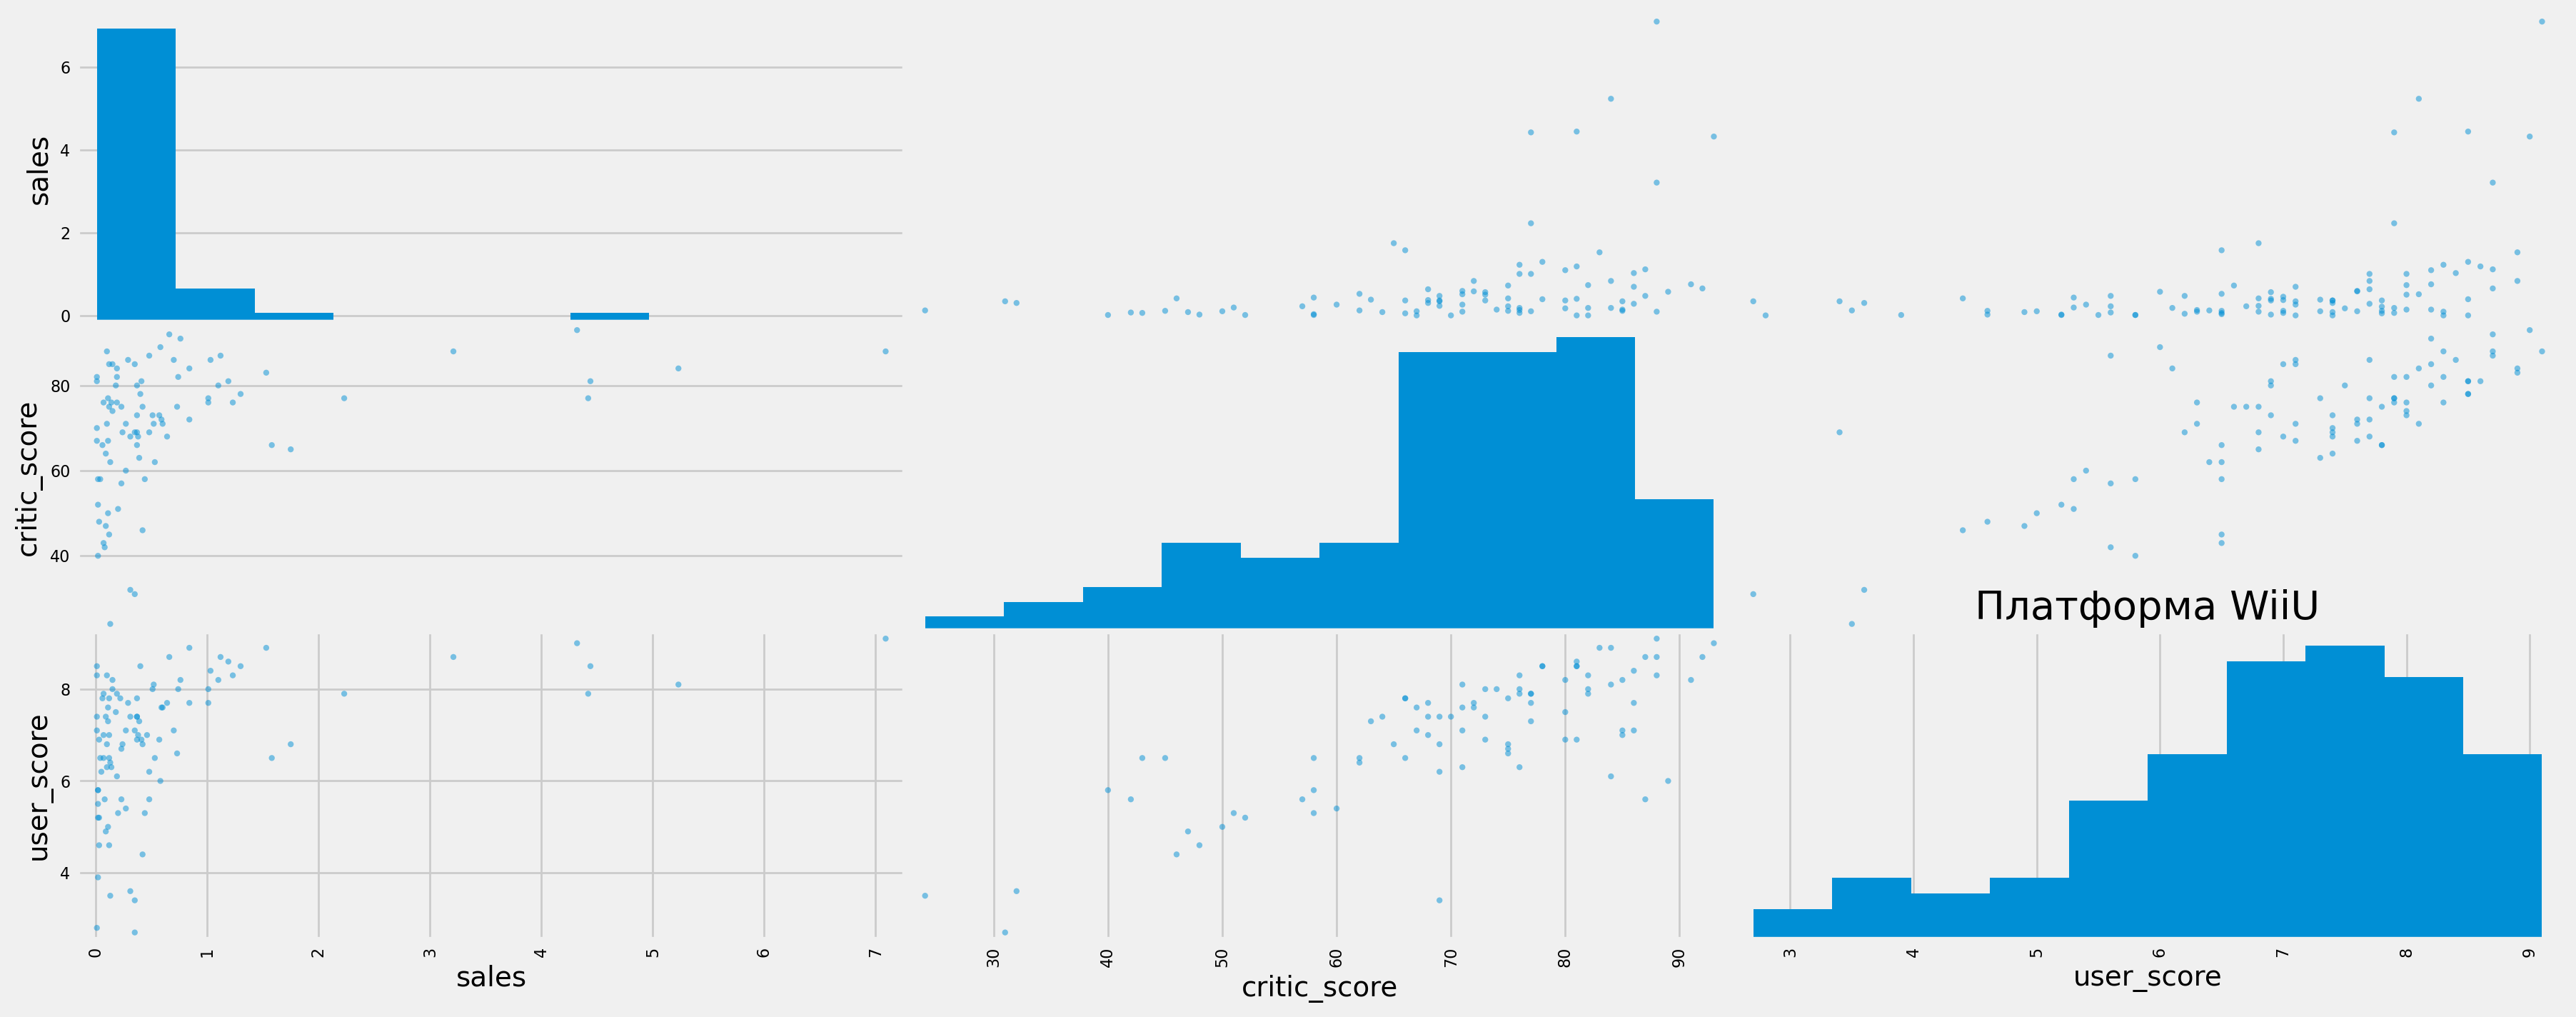

In [49]:
corr_score(games_for_score, top_list[2])

А вот для третьей перспективной платформы WiiU наблюдается другая картина: влияние клитиков всё ещё существенно, но при этом оно меньше влияния оценки игроков. Для объяснения этого эффекта можно посмотреть на количество оценок зрителей и критиков по каждой из платформ.

In [50]:
games_score = games_for_score.groupby(by='platform', as_index=False)\
                             .agg(total = ('sales', 'sum'),
                                  sales = ('sales', 'count'),
                                  critic_score = ('critic_score', 'count'),
                                  user_score = ('user_score', 'count'))\
                             .sort_values(by='total', ascending=False)\
                             .reset_index(drop=True)
games_score['critic_score'] = games_score['critic_score'] / games_score['sales']
games_score['user_score'] = games_score['user_score'] / games_score['sales']
games_score = games_score.loc[:, ['platform', 'critic_score', 'user_score']]
games_score.query('platform in @top_list')\
           .style.format({'critic_score': '{:.1%}', 'user_score': '{:.1%}'})\
           .background_gradient('Blues')

Для потенциально прибыльных платформ примерно одинаковое количество оценок критиков и пользователей по отношению к продажам с этой платформы, и составляет оно от 60 до 75 %. Таким образом действительно, по каким-то причинам на продажи с платформы WiiU имеет слабо выраженное влияние оценка игроков, которая, в свою очередь, сильнее зависит от оценки критиков, чем для предыдущих двух платформ.

#### Промежуточный вывод:

- Оценка критиков имеет влияние, но слабовыраженное, а вот оценка зрителей однозначно не влияет. 
- Подобная зависимость наблюдалась для нескольких крупных и потенциально прибыльных в 2017 году платформ, таких как PS4 и XOne. 
- Для платформы WiiU было обнаружено, что на продажи игр стала слабо влиять и оценка зрителей.
- Оценка зрителей для платформы WiiU гораздо сильнее зависела от оценки критиков, чем для других двух платформ.

### Количество игр по жанрам

Посмотрим на распределение игр по жанрам:

In [51]:
# Рейтинг по жанрам по кол-ву выпущенных игр
top_genre = games_prediction.groupby(by='genre', as_index=False)\
                            .agg(total = ('genre', 'count'),
                                 sales = ('sales', 'sum'),
                                 median_sales = ('sales', 'median'))\
                            .sort_values(by='total', ascending=False)\
                            .reset_index(drop=True)
top_genre

genre  total   sales  median_sales
0         Action   1031  441.12         0.120
1   Role-Playing    370  192.80         0.140
2      Adventure    302   29.43         0.030
3         Sports    267  181.07         0.240
4        Shooter    235  304.73         0.440
5           Misc    192   85.04         0.120
6         Racing    115   53.50         0.140
7       Fighting    109   44.49         0.130
8       Platform     85   61.00         0.210
9     Simulation     80   35.12         0.120
10      Strategy     71   13.34         0.080
11        Puzzle     28    4.89         0.045

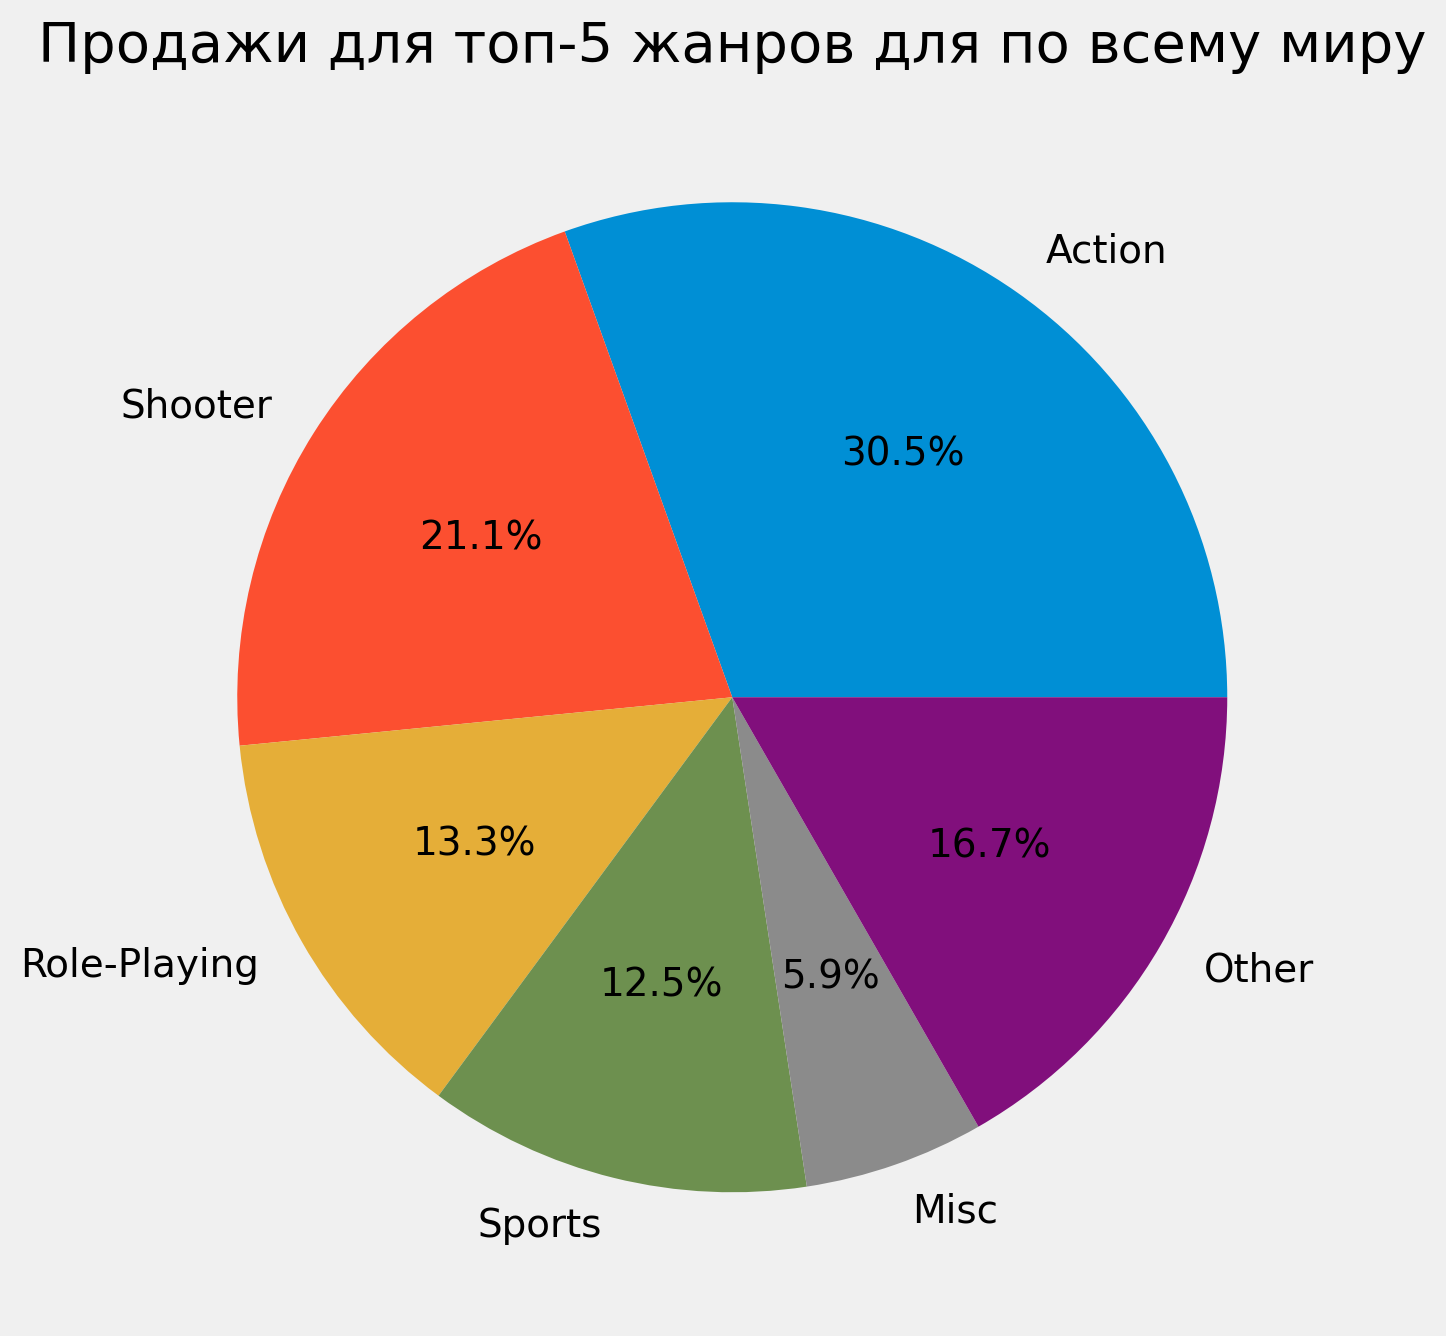

In [52]:
# Рейтинг топ-5 жанров по кол-ву проданных копий для всего мира
top_region(games_prediction, 'genre', ['sales'], 'жанров', ['по всему миру'])

Как видно из графика продаж по всему миру, наиболее продаваемым жанром является Action, его доля составляет 30.5 %. Второе место занимает жанр Shooter, его доля составляет 21.1 %. Вместе эти два жанра занимают 50 % от продаж по всем жанрам.

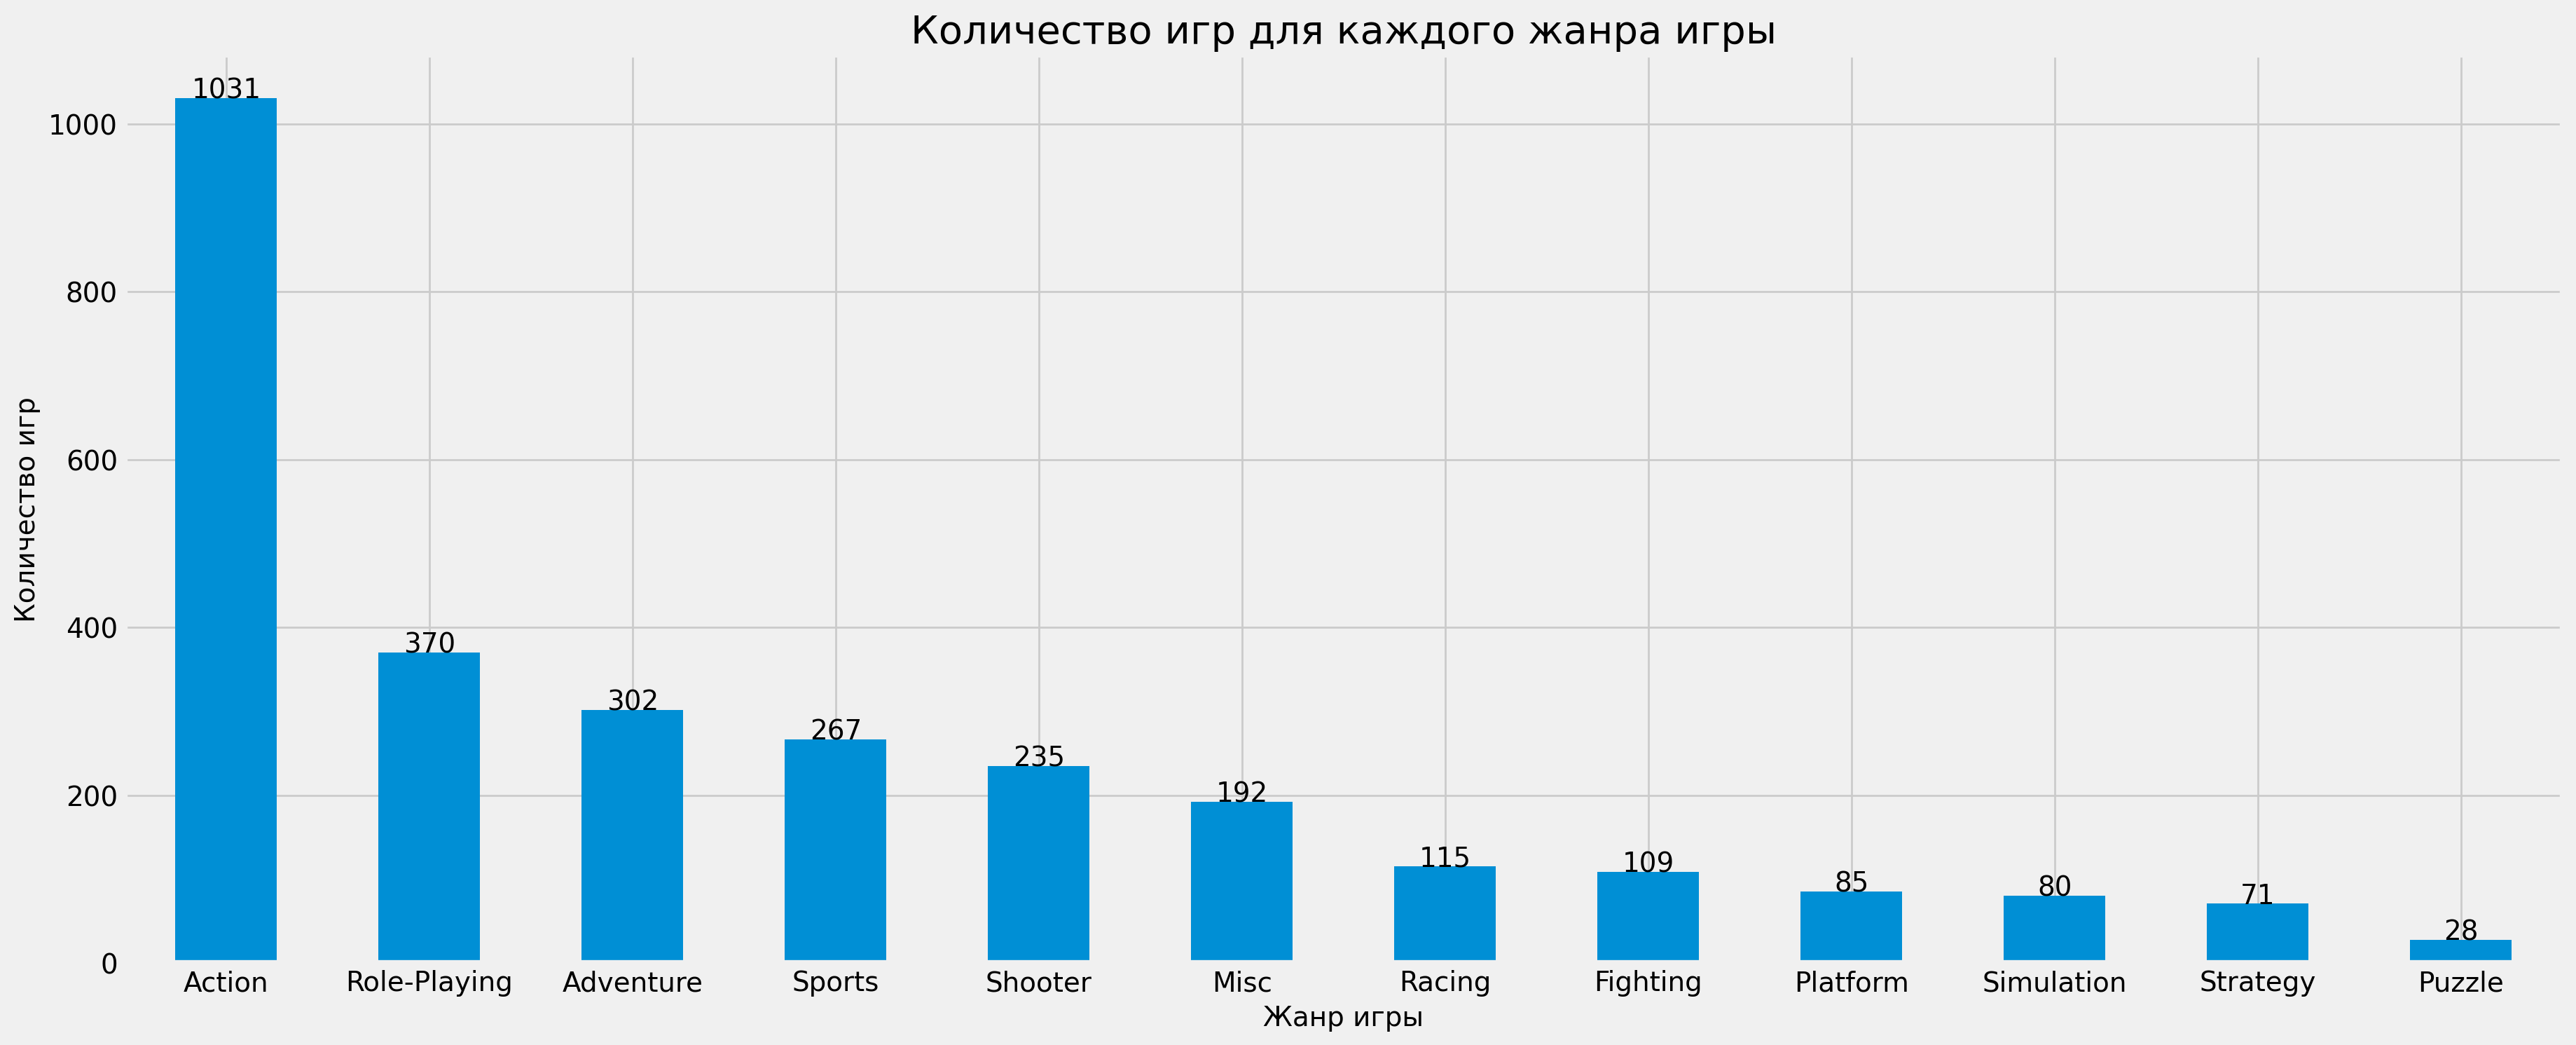

In [53]:
df = top_genre[['genre', 'total']]
fig = bar_plot(df, 'genre')
plt.xticks(rotation=0)
addlabels(df['genre'], df['total'])
plt.xlabel('Жанр игры')
plt.ylabel('Количество игр')
plt.title('Количество игр для каждого жанра игры')
plt.show();

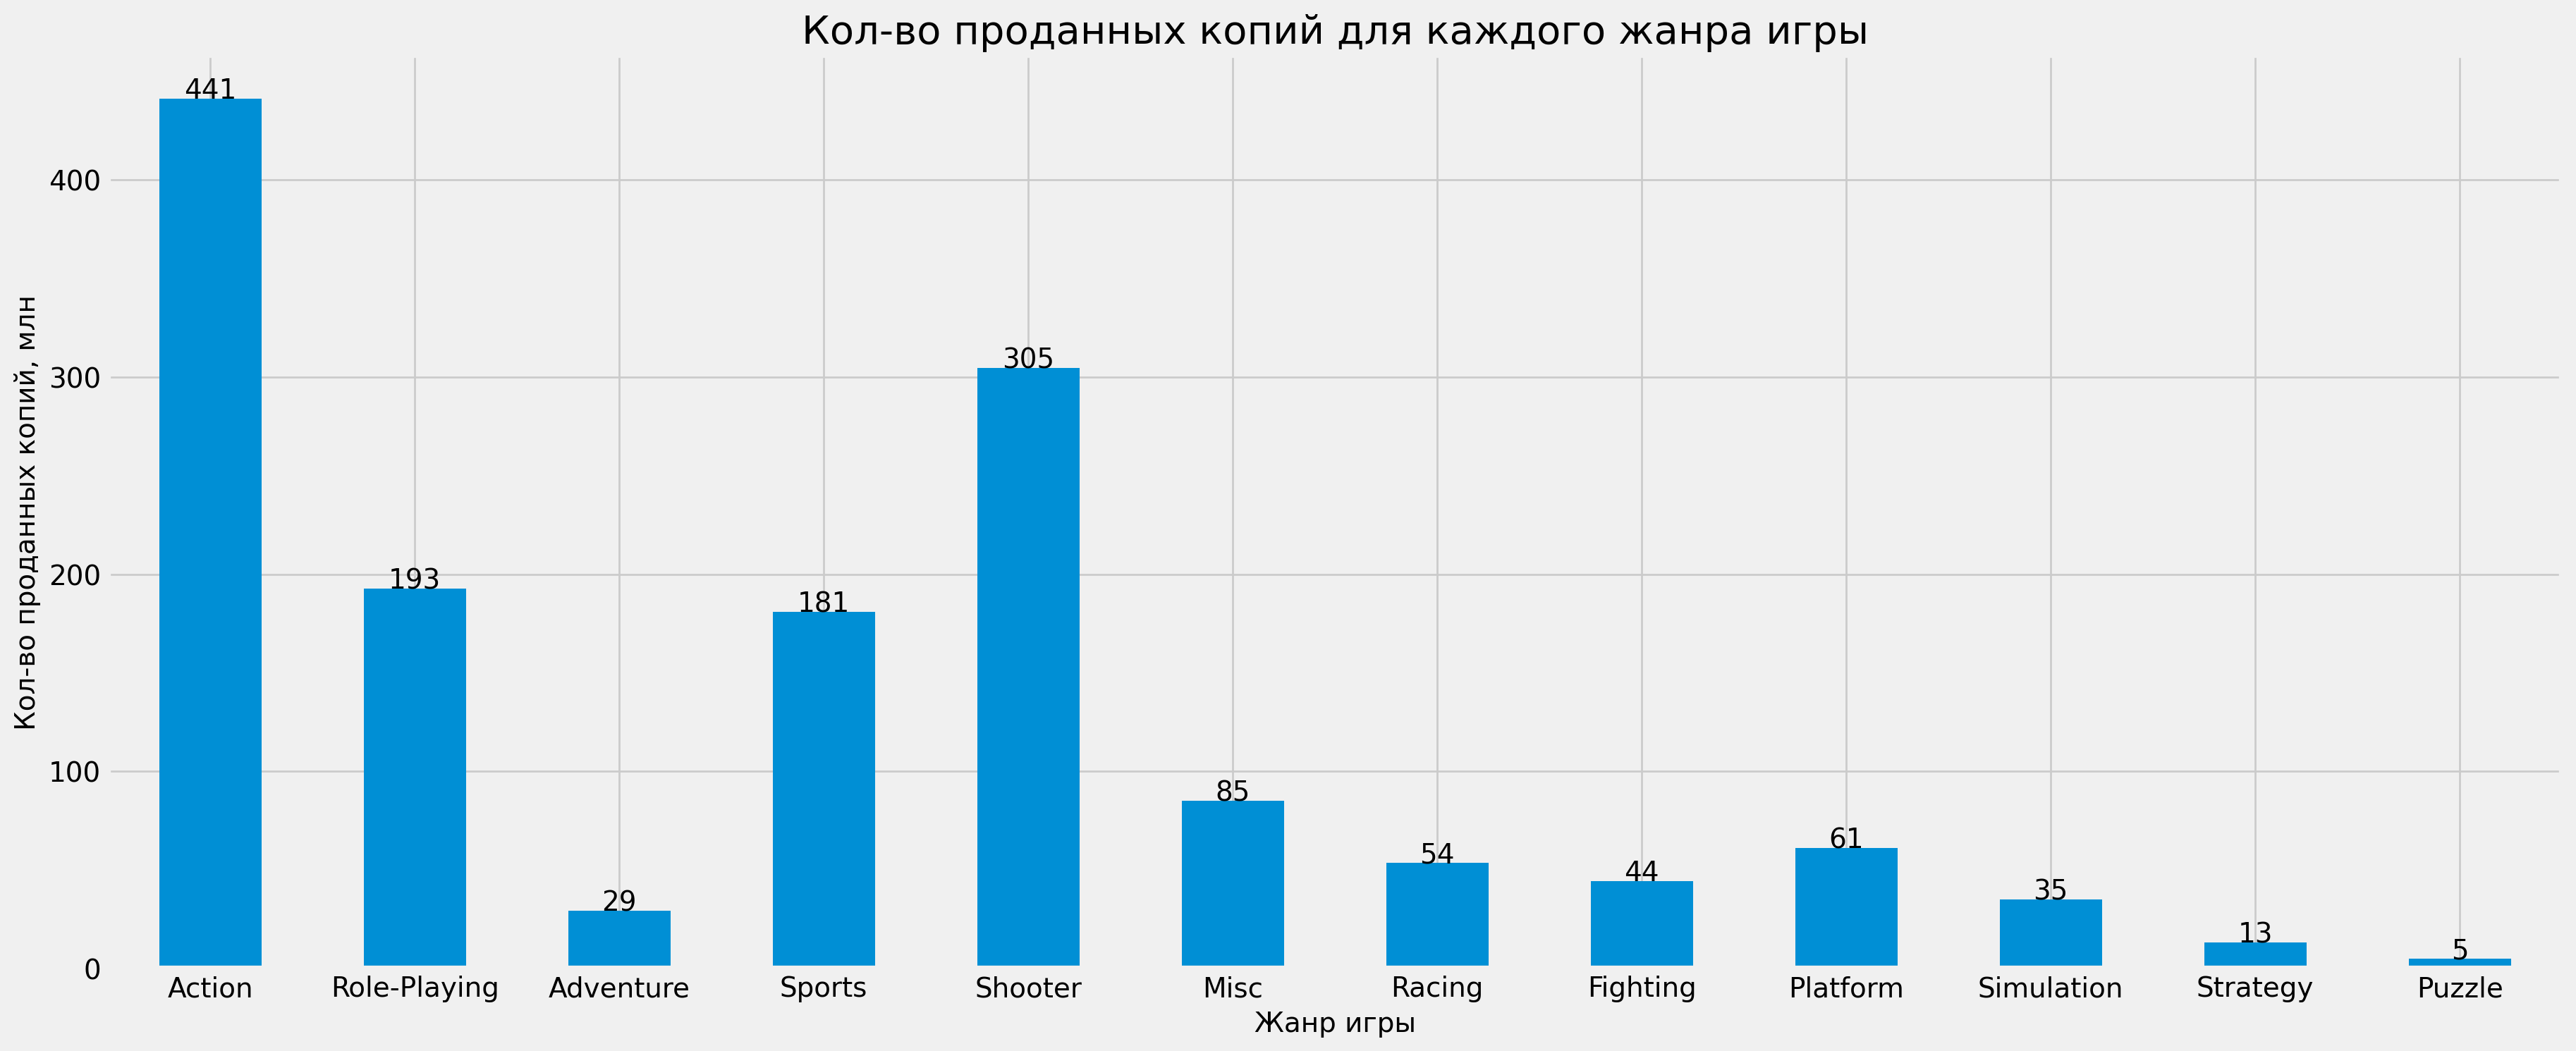

In [54]:
df = top_genre[['genre', 'sales']]
fig = bar_plot(df, 'genre')
plt.xticks(rotation=0)
addlabels(df['genre'], df['sales'])
plt.xlabel('Жанр игры')
plt.ylabel('Кол-во проданных копий, млн')
plt.title('Кол-во проданных копий для каждого жанра игры')
plt.show();

Наиболее популярные жанры игры с 2012 года по 2016 по выпуску игр были: экшен (Action), РПГ (Role-Playing), квесты (Adventure), спортивные (Sports) и шутеры (Shooter). По количеству продаж этот рейтинг несколько отличается. Так, например, игры в жанре квеста продаются не очень активно, в разы меньше, чем их выпускают.

Также можно отметить, что игры в тиле экшен раза в 2.5 больше по количеству выпущенных игр, и раза в 1.5, чем игр остальных жанров. А игры шутеры (Shooter) 5-е по количеству игр, но зато по продажам вторые.

Наименее выпускаемые игры по этому графику: стратегии, симуляторы и пазлы. Но при этом, наименее продаваемые: пазлы, стратегии и квесты.

Посмотрим на жанры игр, которые стабильно приносят высокий доход:

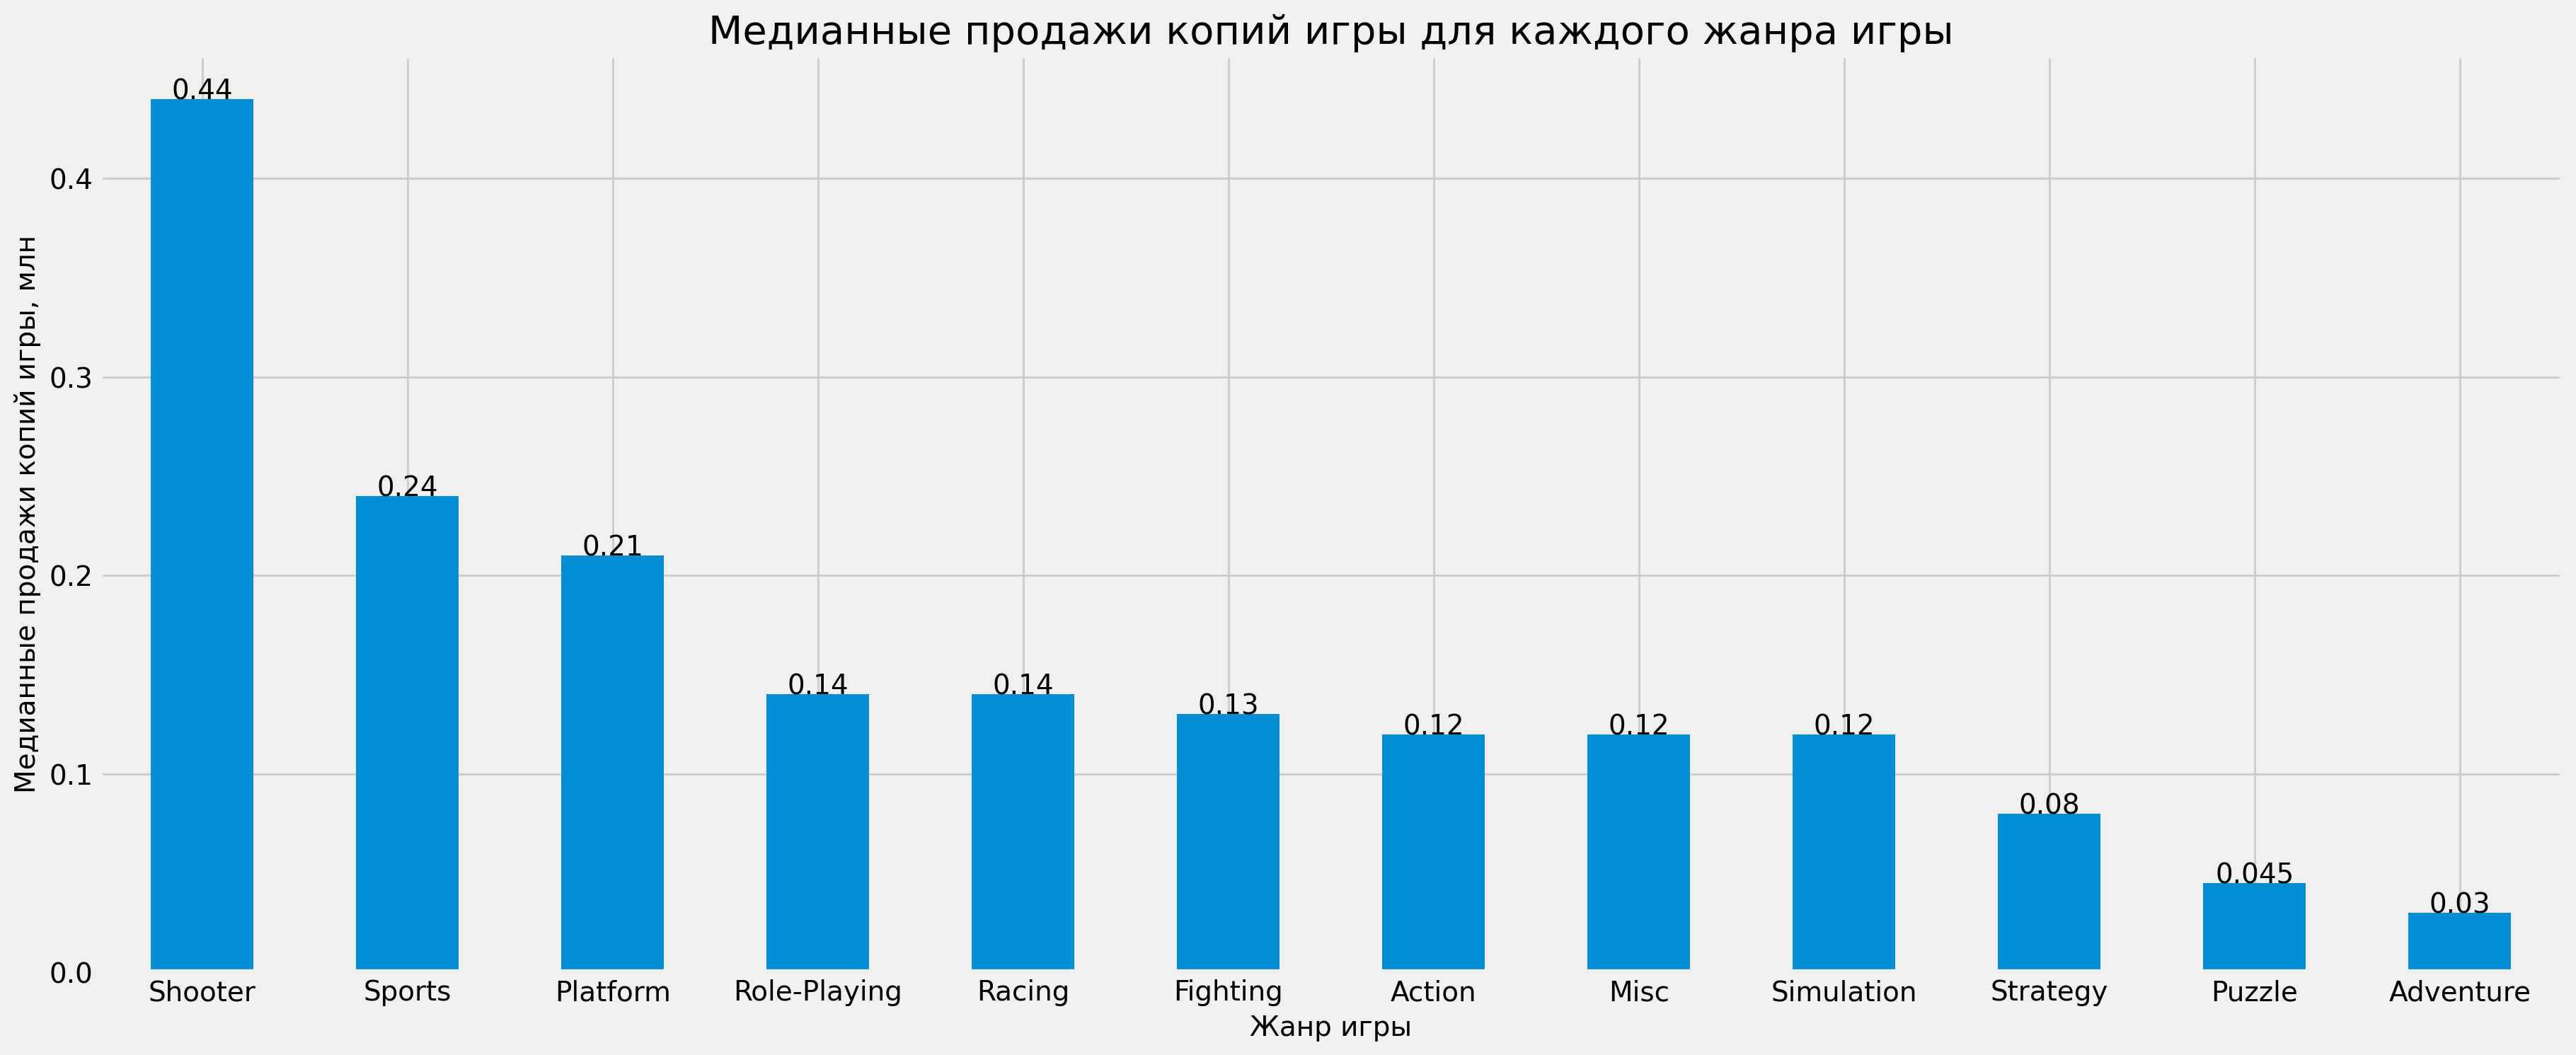

In [55]:
df = top_genre[['genre', 'median_sales']]\
              .sort_values(by='median_sales', ascending=False)\
              .reset_index(drop=True)
fig = bar_plot(df, 'genre')
plt.xticks(rotation=0)
for i in range(len(df['genre'])):
    plt.text(i, df['median_sales'][i], round(df['median_sales'][i], 3), ha = 'center')
plt.xlabel('Жанр игры')
plt.ylabel('Медианные продажи копий игры, млн')
plt.title('Медианные продажи копий игры для каждого жанра игры')
plt.show();

Наиболее стабильно приносят доход жанр шутер: его медианное значение продаж составило 400 тыс копий на игру. При этом экшены, которые суммарно приносят больше всего дохода, имеют не такие хорошие показатели: 120 тыс копий и находятся на 7 месте в топе из 12. На втором и третьем месте по стабильности находятся спортивные игры и платформеры с 240 и 210 тыс копий, соответственно.

**Промежуточные выводы:** 
* Наиболее популярными жанрами по количеству выпущенных игр в период с 2012 по 2016 год являются Action, Adventure, Sports, Shooter и Misc
* Наиболее продаваемыми жанрами являются Action, Shooter, Role-Playing, Sports и Misc
* На первом месте по медианным продажам находятся игры жанра Shooter, на втором и третьем: Platform и Sports, соответственно
* Игры жанра Action находятся на 7 месте из 12 по медианным продажам
* Наименее продаваемым оказался жанр Puzzle, при этом игр в данном жанре также выпускается наименьшее количество
* Игр в жанре Adventure выпускают много, они входят в топ-5 лидеров по количеству игр, но при этом по рейтингу продаж игр этот жанр находится в топ-3 наименее продаваемых, а по медианным продажам они находятся на последнем месте

### Промежуточные выводы:

- Был выбран период с 2012 по 2016 год для дальнейшего рассмотрения, как наиболее интересный.
- Было выявлено, что срок жизни платформ составляет 10 лет, максимальные показатели приходятся на 5-6 год жизни.
- Потенциально прибыльными платформами в 2017 году могут являться PS4 и XOne так как старт продаж игр начался в 2013 году и на 2017 придут пиковые значения.
- Третьей потенциально прибыльной платформой выбрана WiiU, так как для неё спад начался только в 2015 году.
- Среднее значение в 250 тыс проданнных копий игр по миру является хорошим показателем для крупных прибыльных платформ.
- На продажи с платформ имеет слабое влияние оценка критиков, а оценка игроков не оказывает влияния. Только для платформы WiiU появилось слабое влияние оценки от пользователей на продажи.
- Наиболее популярными жанрами по количеству выпущенных игр являются Action, Adventure, Sports, Shooter и Misc.
- Наиболее продаваемыми жанрами по суммарным продажам являются Action, Shooter, Role-Playing, Sports и Misc.
- Жанры, которые по медианным продажам приносят стабильный доход: Shooter (стабильно более 400 тыс копий), Platform и Sports (в области 220 тыс копий). Также в пятёрку лидеров входят Role-Playing и Racing с 140 тыс копиями.
- По медианным продажам Action находится на 7 месте из 12 с 120 тыс проданными копиями.

## Портрет пользователя по регионам

### Продажи для топ-5 платформ

Посмотрим на продажи для топ-5 платформ для пользователей из Северной Америки, Европы и Японии.

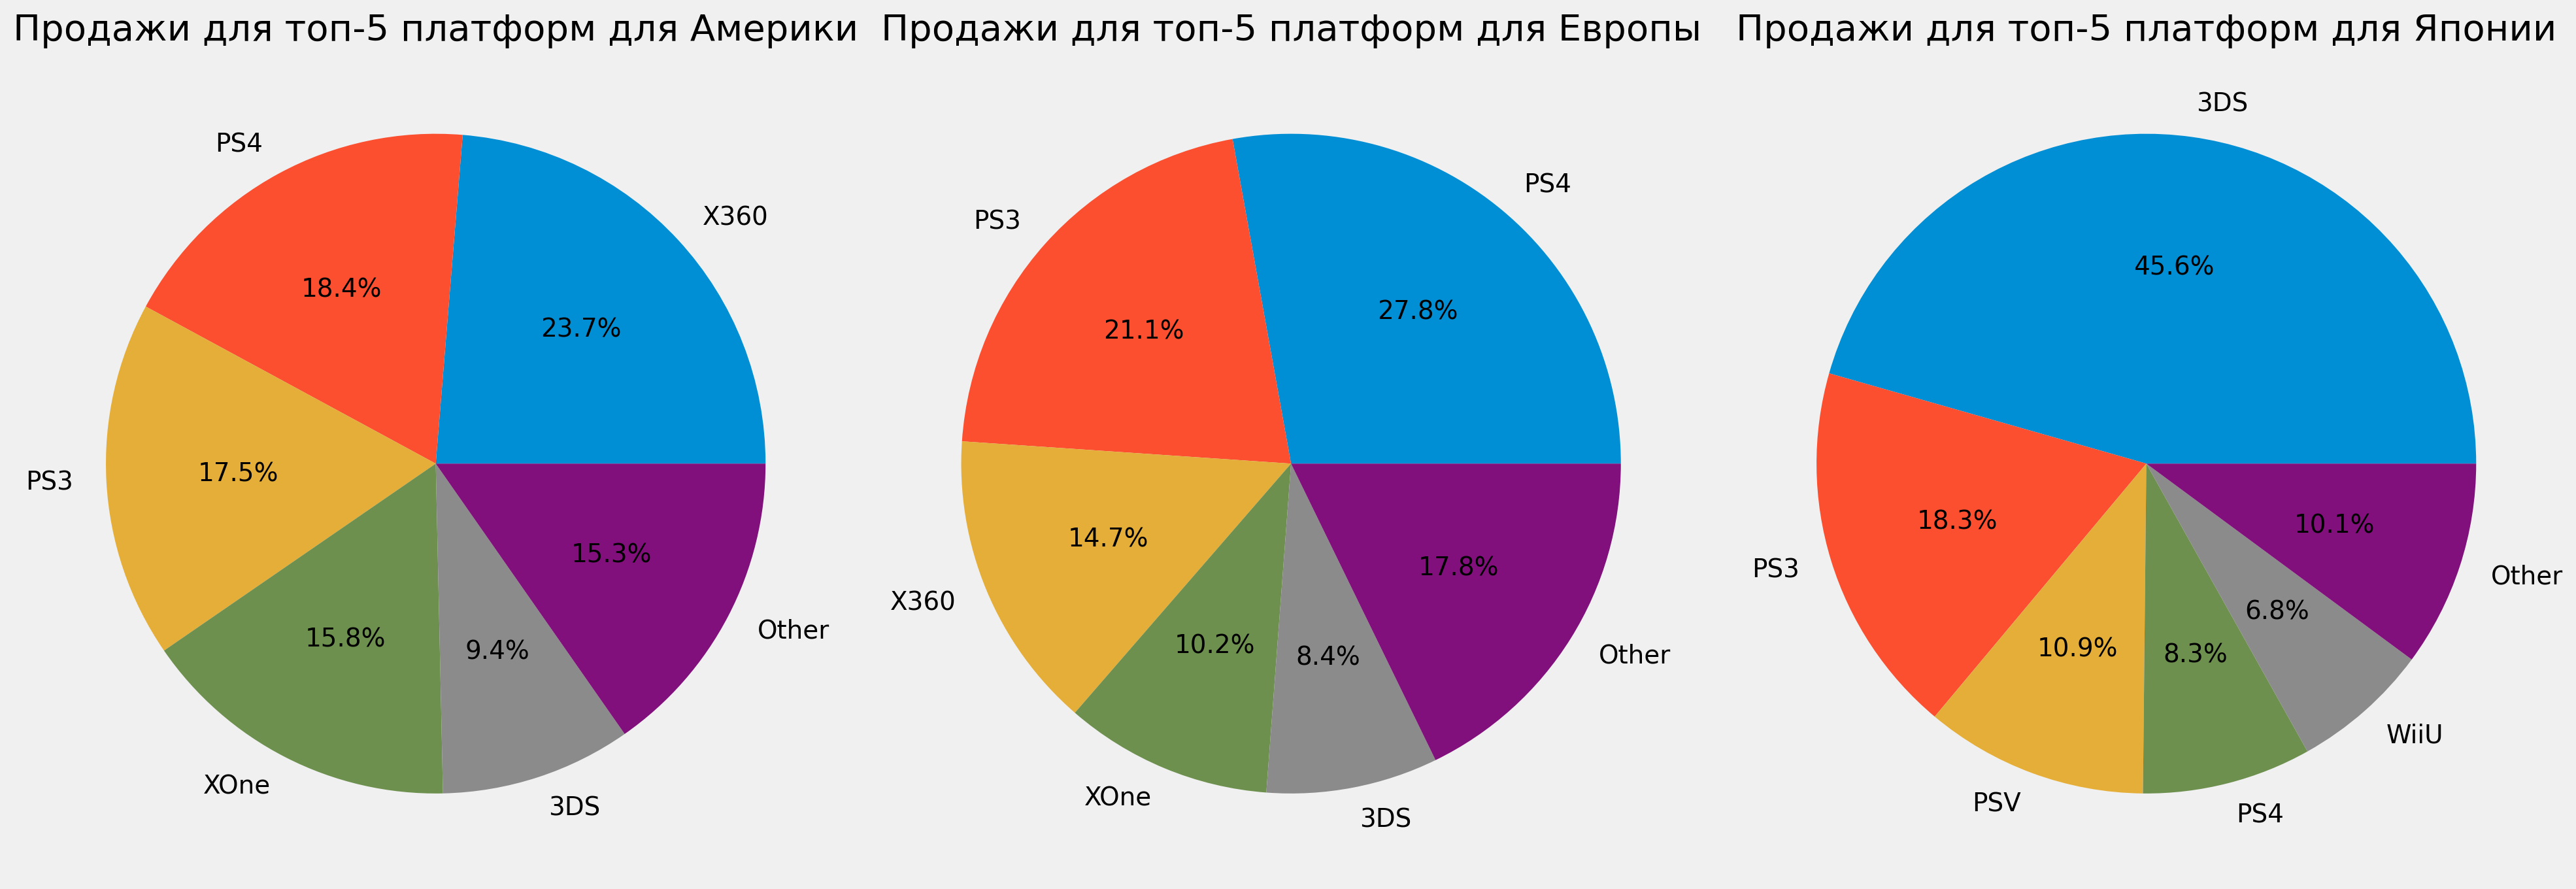

In [56]:
top_region(games_prediction, 'platform', ['na_sales', 'eu_sales', 'jp_sales'], 
           'платформ', ['Америки', 'Европы', 'Японии'])

- Для Северной Америки по количеству продаж первое место занимает платформа Х360 с 23.7%. 
- На втором и третьем местах находятся PS4 и PS3 с 18.4% и 17.5%, соответственно. 
- На четвёртом и пятом местах находятся XOne и 3DS.
- Для Северной Америки топ-3 платформ согласуется с тем, что был получен для всех стран (перспективные платформы, которые набирают обороты по продаже на них игр), только платформы Х360 и PS4 поменялись местами в рейтинге.
- Для Европы наиболее популярной по количеству продаж является платформа PS4 с 27.8% продаж от общего количества.
- Второй по популярности является платформа PS3, продажи для неё составили 21.1%, а на третьем месте находится Х360 с 14.7%.
- На четвёртом и пятом местах, как для Северной Америки, находятся XOne и 3DS.
- Для Европы топ-3 платформ согласуется с топ-5 для всех стран.
- Для Японского рынка есть отличия: самой популярной является 3DS с 45.6%.
- На втором и третьем местах находятся PS3 и PSV с 18.3% и 10.9%, соответственно.
- На четвёртом и пятом местах находятся PS4 и WiiU и имеют менее 10% от общих продаж.
- Перспективные Х360 и XOne для Японского рынка попали в раздел с другими платформами, на которые пришлось 10.1% продаж за выбранные года. Это можно объяснить тем, что платформа 3DS - следующее поколение консоли Nintendo от производителя из Японии. Поэтому она и лидирует по количеству продаж в своей стране. А линейка PS, хотя тоже от разработчиков из Японии, всё равно приобрела большую популярность в мире, чем другие платформы.
- Топ-5 платформ по продажам для Японии сильно отличается от топа-5 для всех стран, в котором лидировали PS4 и PS3, а 3DS была на пятой позиции.

### Продажи для топ-5 жанров

Посмотрим на продажи для топ-5 жанров для пользователей из Северной Америки, Европы и Японии.

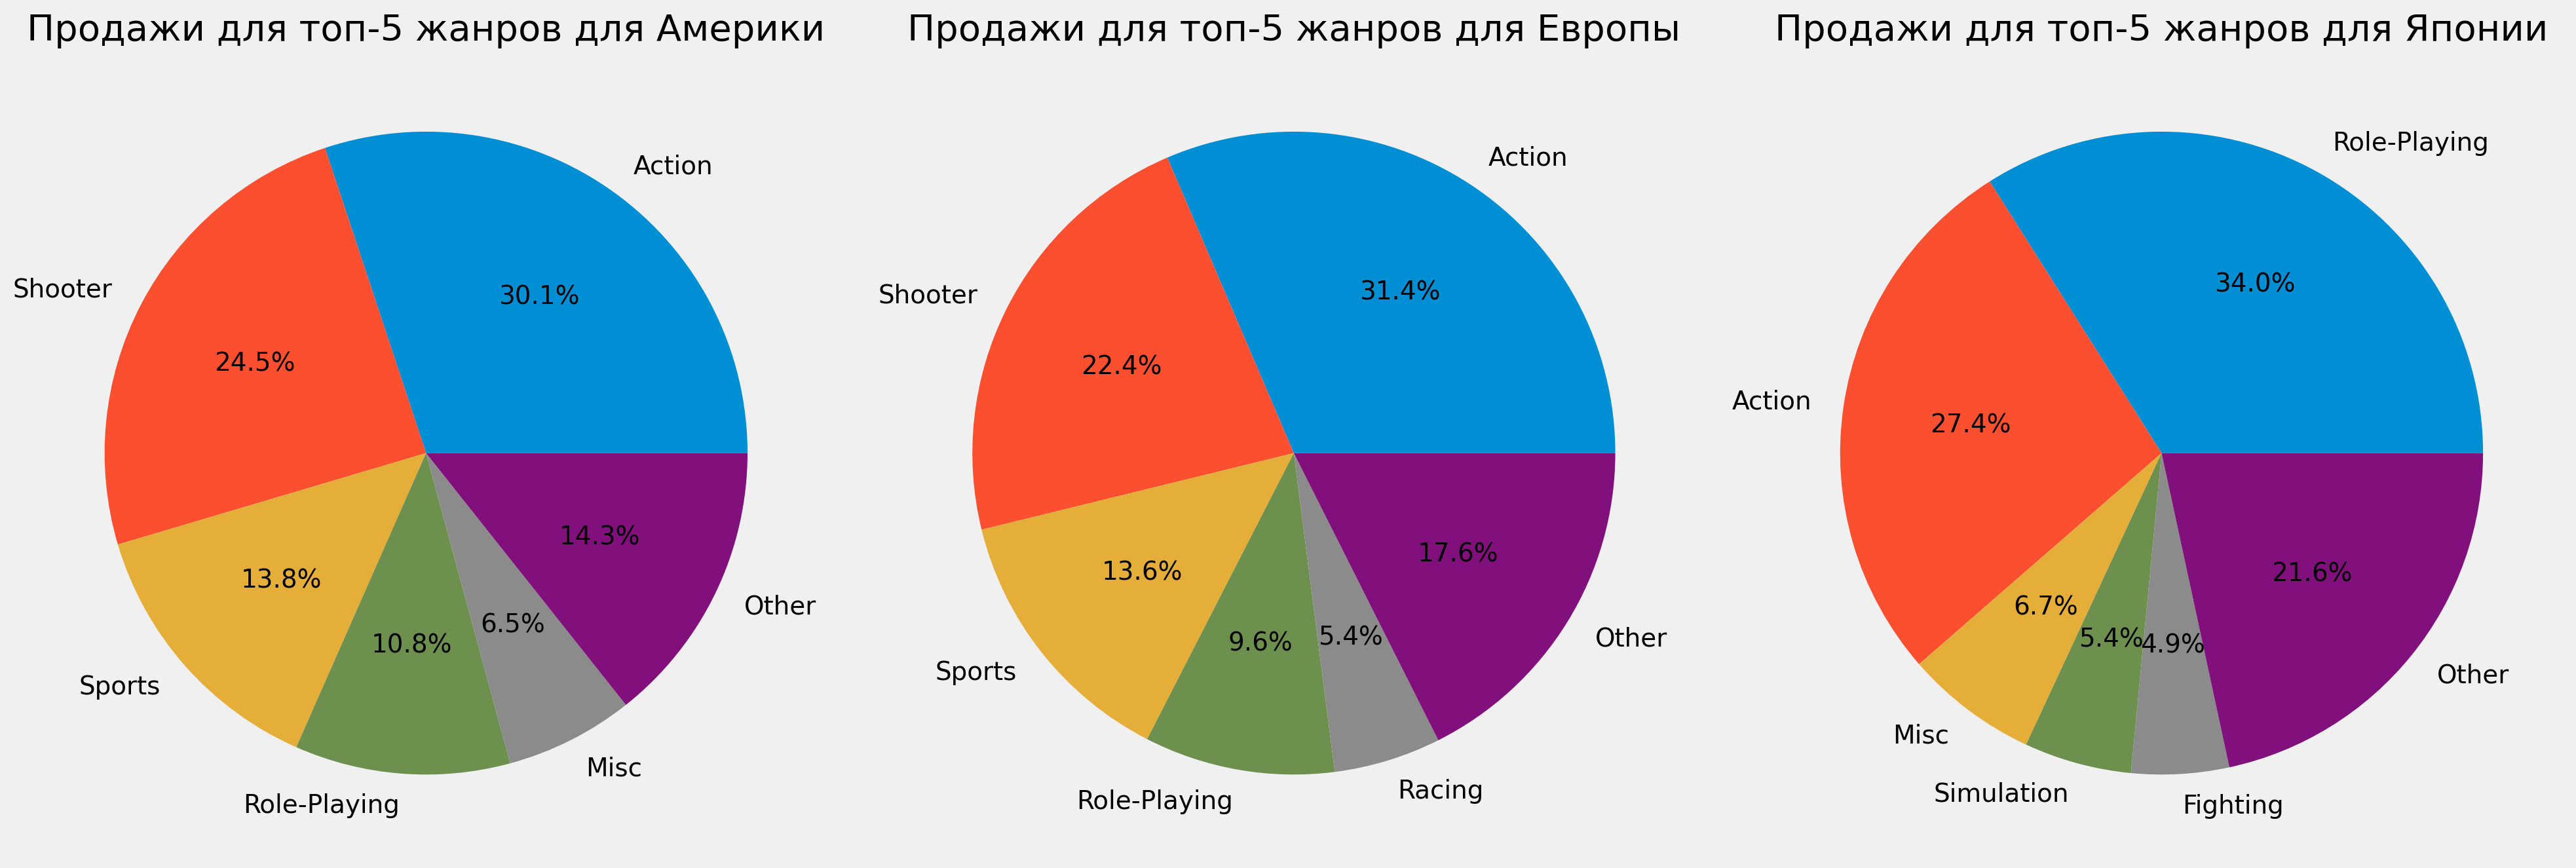

In [57]:
top_region(games_prediction, 'genre', ['na_sales', 'eu_sales', 'jp_sales'], 
           'жанров', ['Америки', 'Европы', 'Японии'])

- Наиболее продаваемым жанром в Северной Америке является Action, на него приходится 30.1 % всех продаж.
- Второе место по продаваемости занимает жанр Shooter, на него приходится 24.5 % всех продаж.
- Жанры RPG, Sports и Misc занимают 3-5 место и их доля составляет 6.5-13.8 %.
- Топ-5 популярных жанров по продажам для Северной Америки согласуется с топ-5 для всех стран.
- Для Европы наблюдается аналогичный топ, как и для Северной Америки, только на пятом месте находится Racing вместо Misc.
- Топ-5 жанров игр в Японии отличается от предпочитаемых в Америке и Европе.
- Лидером в Японии стал RPG с 34% продаж.
- На втором месте находится Action с 27.4%.
- На 3-5 местах находятся жанры Misc, Simulation и Fighting с близкими значениями от 4.9% до 6.7%.
- Топ-5 популярных жанров по продажам для Японии сильно отличается от топа-5 для всех стран.

### Продажи для топ-5 рейтингов игр

Посмотрим на влияение возрастного рейтинга игры на продажи в разных странах.

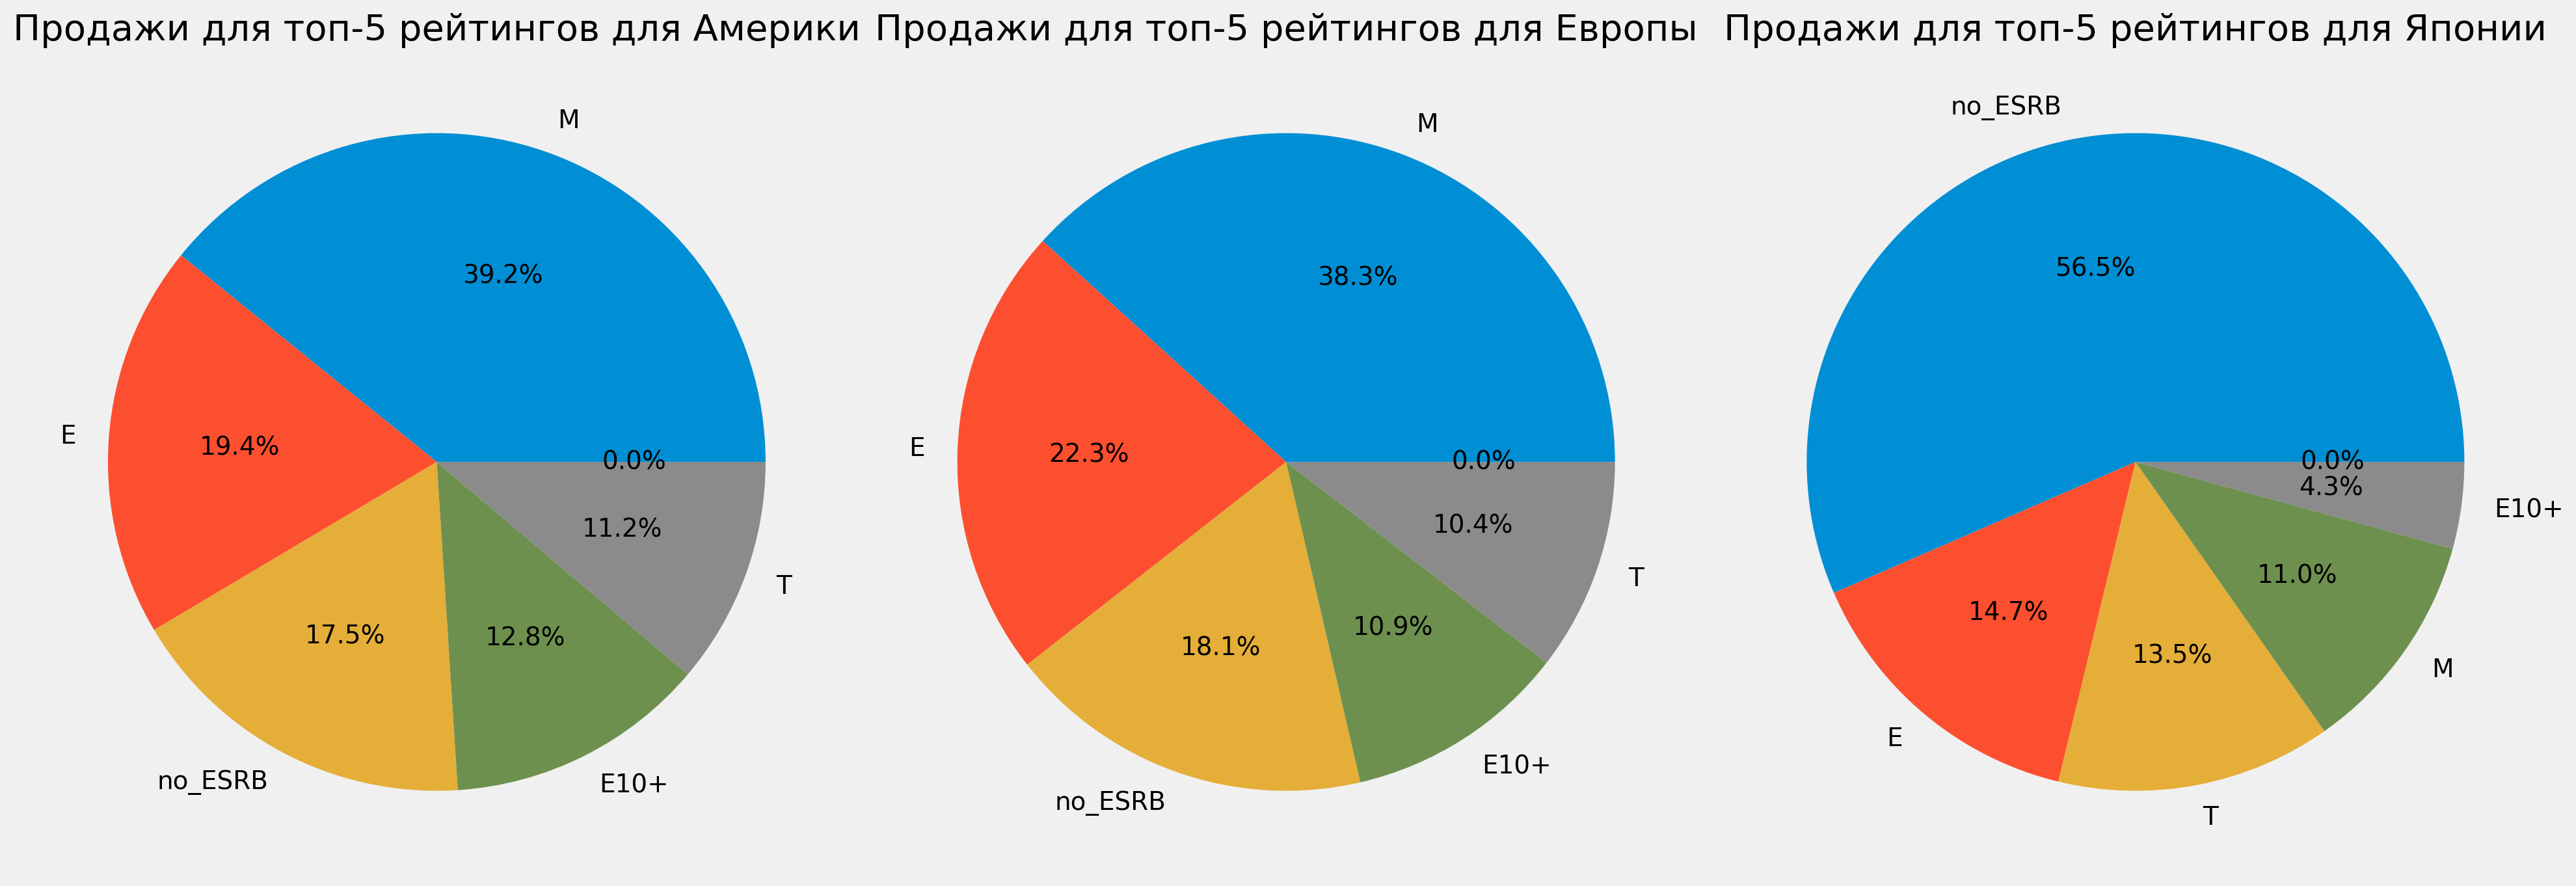

In [58]:
top_region(games_prediction, 'rating', ['na_sales', 'eu_sales', 'jp_sales'], 
           'рейтингов', ['Америки', 'Европы', 'Японии'])

- Для Северной Америки доля игр с рейтингом М (для взрослых с 17 лет) составляет 39.2 % по всем продажам.
- На втором месте находятся игры неопределённого возрастного рейтинга. 
- Следующие по популярности рейтинги Е (для всех возрастов без ограничений) с 19.4%, Е10+ (для возраста с 10 лет) с 12.8% и Т (для подростков) с 11.2%.
- Для Европы наблюдается аналогичный Северной Америке топ-5 по возрастному рейтингу.
- Для Японии более 50% занимают игры неопределённого рейтинга, который либо подразумевает, что доступен для всех возрастов, либо возрастной ценз по ESRB не был проставлен (игра могла быть выпущена в стране, в которой отличается система присваивания игре возрастного рейтинга).
- Близкие доли имеют игры возрастного рейтинга Е (для всех) и Т (для подростков). 
- Игры рейтинга М (для взрослой аудитории) занимают третье место.

### Продажи для каждого региона

Посмотрим долю продаж для каждого региона отдельно, чтобы выявить, какой регион вносит наибольший вклад по продаже игр:

In [59]:
# Сводная таблица по регионам
top_country = games_prediction.groupby(by='year_of_release', as_index=False)\
                              .agg(sales = ('sales', 'sum'),
                                   na_sales = ('na_sales', 'sum'),
                                   eu_sales = ('eu_sales', 'sum'),
                                   jp_sales = ('jp_sales', 'sum')
                                  )
top_country['na_part'] = top_country['na_sales'] / top_country['sales']
top_country['eu_part'] = top_country['eu_sales'] / top_country['sales']
top_country['jp_part'] = top_country['jp_sales'] / top_country['sales']
top_country.style.format({'na_part': '{:.1%}',
                          'eu_part': '{:.1%}',
                          'jp_part': '{:.1%}'})

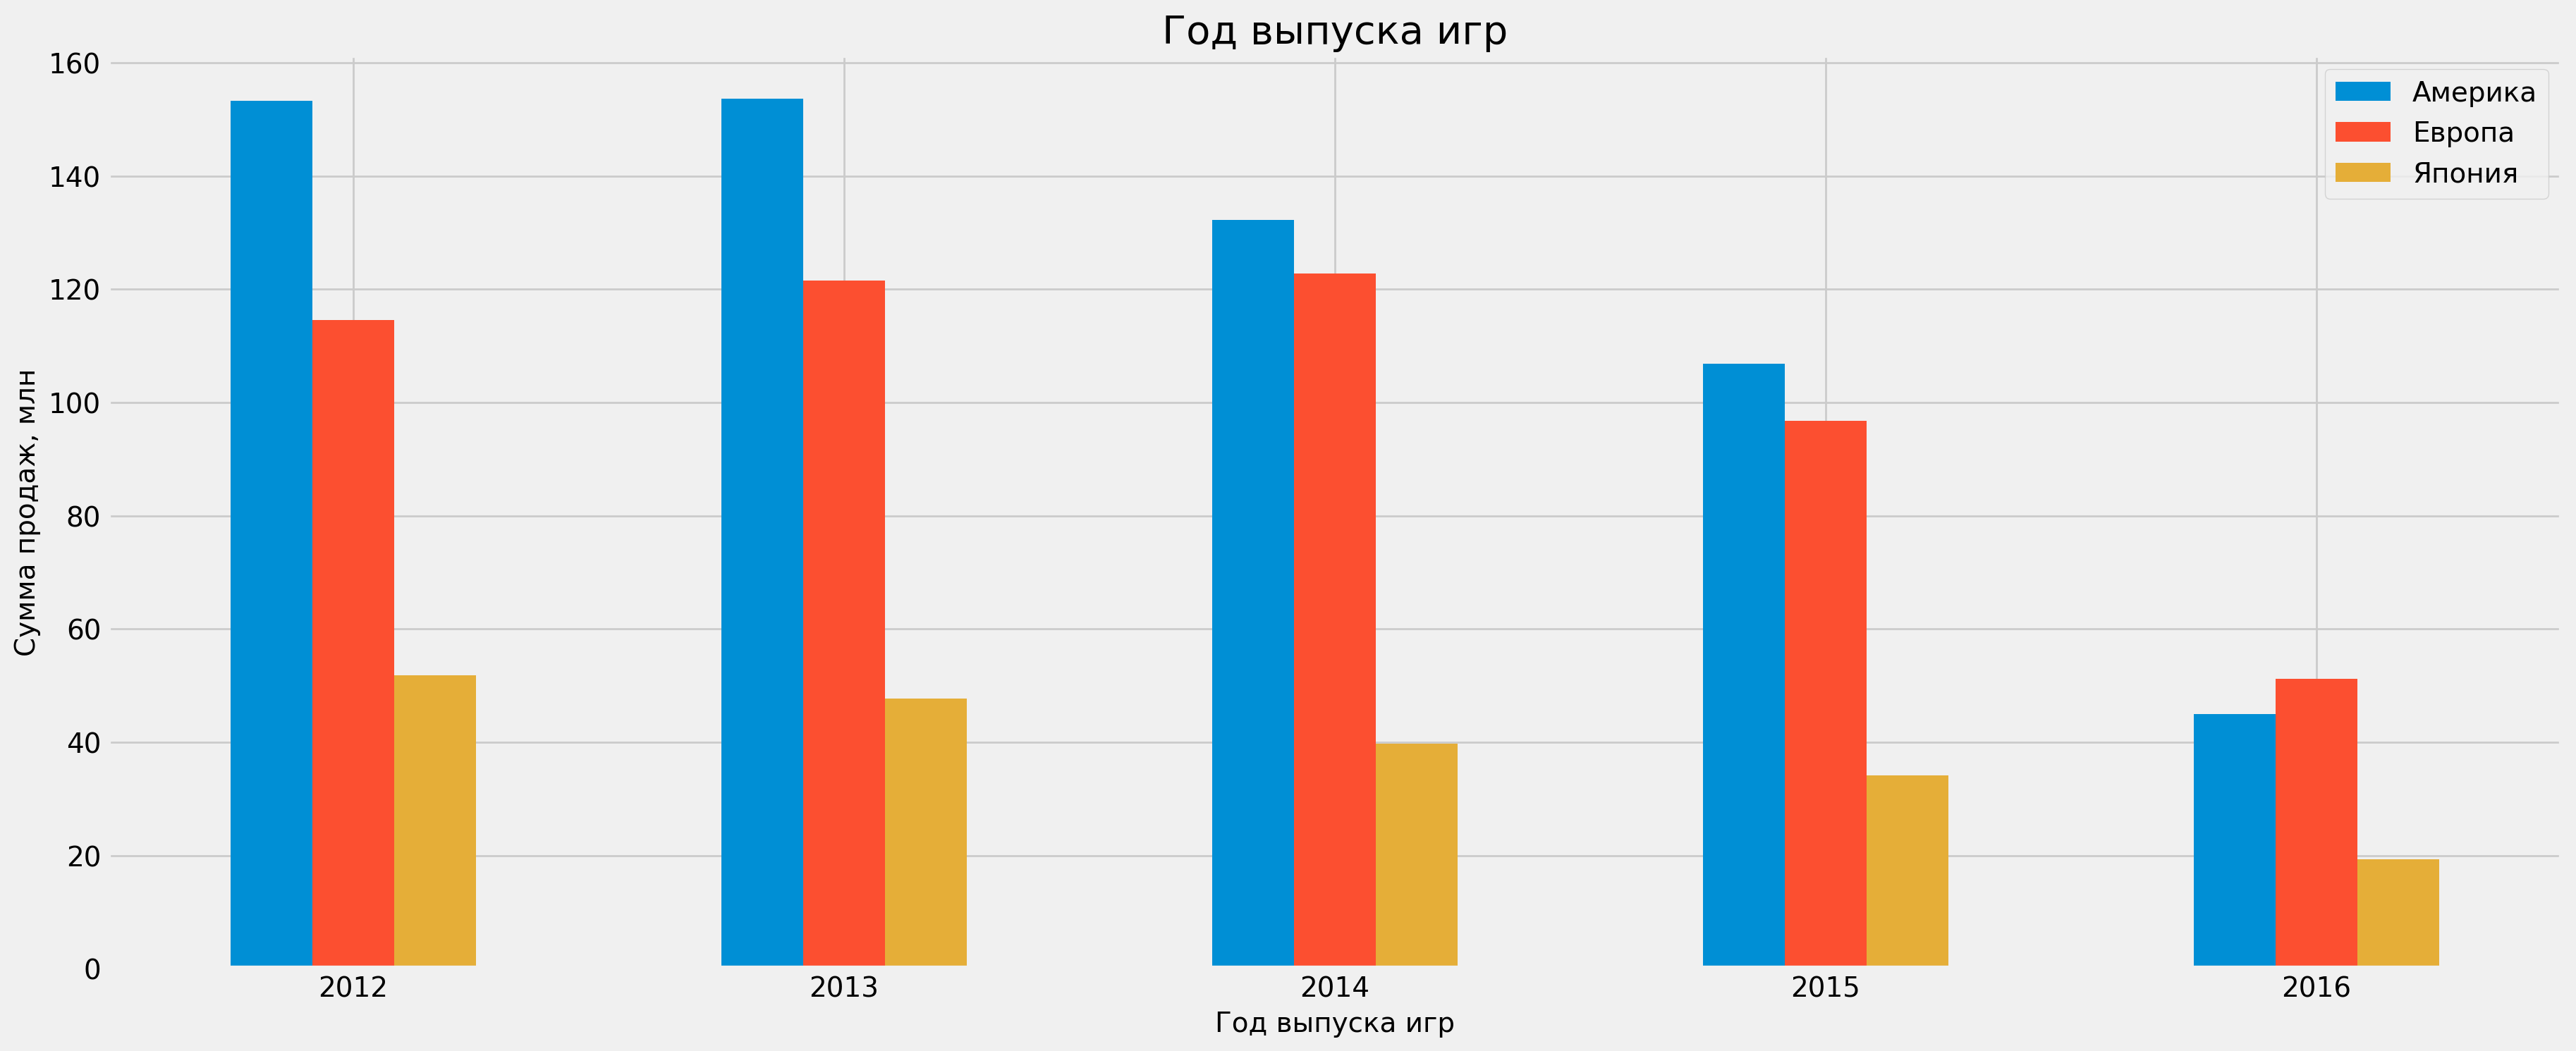

In [60]:
top_country.plot(x='year_of_release',
                 y=['na_sales', 'eu_sales', 'jp_sales'],
                 kind='bar',
                 title='Год выпуска игр',
                 xlabel='Год выпуска игр',
                 ylabel='Сумма продаж, млн')
plt.xticks(rotation=0)
plt.legend(['Америка', 'Европа', 'Япония'])
plt.show();

Наибольшую выручку приносят игры от аудитории Северной Америки и Европы, причём с каждым годом доля Европы становится всё больше, а доля Америки меньше. Продажи в Японии каждый год составляют меньше 15 % от общих продаж.

### Промежуточные выводы:

- Игроки из Северной Америке и Европы схожи по предпочтениям между собой.
- Для игрока из Северной Америке популярной по количеству продаж является платформа Х360, доля продаж составила 23.7 %.
- Наиболее продаваемый жанр для Северной Америки является Action, на него приходится 30.1 % всех продаж.
- Больше всего выпускается и продаётся игр с рейтингом М (для взрослых с 17 лет), их доля составила 39.2 %.
- Для игрока из Европы популярной по количеству продаж является платформа PS4, доля продаж составила 27.8 %.
- Наиболее продаваемый жанр для Европы также является Action, на него приходится 31.4 % всех продаж.
- Больше всего выпускается игр с рейтингом М (для взрослых с 17 лет), а по продажам их доля составила 38.3 %.
- Топ-5 платформ по продажам в Японии отличается от топ-5 по миру.
- Для игрока из Японии популярной по количеству продаж является платформа 3DS, доля продаж составила 45.6 %.
- Топ-5 жанров игр по продажам в Японии отличается от топ-5 по миру.
- Наиболее продаваемым жанром в Японии является RPG, на него приходится 34 % всех продаж.
- Более 50 % продаж в Японии приходится на игры без указанного возрастного рейтинга.
- Следующие по продаваемости находятся игры рейтинга Е (для всех возрастов) и Т (для подростков), их доля составляет 13.5-14.7%.
- Доля продаж в Америке и Европе составляет большую часть рынка, доля продаж по Японии за каждый год меньше 15 %.

## Проверка гипотез

Проверка гипотез проводится t-тестом с уровнем статистической значимости 0.05.

In [61]:
# Задаём уровень значимости
alpha = 0.05

### Сравнение рейтингов от пользователей платформ XBox One и PC

Проверим первую гипотезу о том, у какой платформы лучше пользовательские рейтинги: XOne или PC.

<p>Введём нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние значения оценок пользователей для двух платформ XOne и PC равны.}\\
   H_1 :\text{Среднее значение оценок пользователей для двух платформ XOne и PC не равны.}
 \end{cases}
\end{equation*}$

Так как мы сравниваем оценки пользователей для двух разных игровых платформ, то это две генеральные совокупности, которые не зависят друг от друга. Поэтому можно воспользоваться методом для проверки гипотезы о равенстве среднего двух генеральных совокупностей. 

In [62]:
# Задаём уровень значимости и проверяем t-тестом разницу между средними двух выборок
df1 = games_prediction.loc[(games_prediction['platform'] == 'XOne') & \
                           ~(games_prediction['user_score'].isna()), \
                           'user_score']
df2 = games_prediction.loc[(games_prediction['platform'] == 'PC') & \
                           ~(games_prediction['user_score'].isna()), \
                           'user_score']

results = st.ttest_ind(df1, df2)

print('Среднее значение оценки пользователей для платформы XOne: ',
      "{0:.1f}".format(df1.mean()))
print('Среднее значение оценки пользователей для платформы PC: ',
      "{0:.1f}".format(df2.mean()))

print('p-значение:', "{0:.3}".format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')

Среднее значение оценки пользователей для платформы XOne:  6.5
Среднее значение оценки пользователей для платформы PC:  6.4
p-значение: 0.554
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


По результатам t-теста можно сказать, что нулевая гипотеза о равенстве средних для оценки пользователей для двух платформ не была опровергнута. Значит средние значения оценок находятся рядом, в пределах уровня значимости.

### Сравнение рейтингов от пользователей жанров Action и Sports

Проверим первую гипотезу равны ли пользовательские рейтинги для двух жанров: экшен и спортивных.

<p>Введём нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средние значения оценок пользователей для двух жанров игр Action и Sports равны.}\\
   H_1 :\text{Среднее значение оценок пользователей для двух жанров игр Action и Sports не равны.}
 \end{cases}
\end{equation*}$

Так как мы сравниваем оценки пользователей для двух разных жанров игры, то это две генеральные совокупности, которые не зависят друг от друга. Поэтому можно воспользоваться методом для проверки гипотезы о равенстве среднего двух генеральных совокупностей. 

In [63]:
# Задаём уровень значимости и проверяем t-тестом разницу между средними двух выборок
df1 = games_prediction.loc[(games_prediction['genre'] == 'Action') & \
                           ~(games_prediction['user_score'].isna()), \
                           'user_score']
df2 = games_prediction.loc[(games_prediction['genre'] == 'Sports') & \
                           ~(games_prediction['user_score'].isna()), \
                           'user_score']

results = st.ttest_ind(df1, df2)

print('Среднее значение оценки пользователей для жанра Action: ',
      "{0:.1f}".format(df1.mean()))
print('Среднее значение оценки пользователей для жанра Sports: ',
      "{0:.1f}".format(df2.mean()))

print('p-значение:', "{0:.3}".format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')

Среднее значение оценки пользователей для жанра Action:  6.8
Среднее значение оценки пользователей для жанра Sports:  5.5
p-значение: 4.8e-26
Отвергаем нулевую гипотезу: между группами есть значимая разница


По результатам t-теста можно сказать, что нулевая гипотеза о равенстве средних для оценки пользователей двух жанров игры: экшен и спортивные была опровергнута, причём в пользу двусторонней гипотезы. Таким образом, можно отметить, что для жанров Action и Sports пользовательские рейтинги разные.

### Промежуточные выводы:

Было проверено две гипотезы касательно средних пользовательских рейтингов для двух популярных платформ и двух популярных жанров игры. 
- Средние оценки игроков для XBox One и PC не сильно отличаются друг от друга и находятся на одном уровне.
- Для жанров Action и Sports пользовательские рейтинги разные.

## Итоги исследования

Было проведено исследование интернет-магазина Стримчик. Были предоставлены данные о выпущенных играх с 1985 по 2016 года. Необходимо было проанализировать данные и сделать прогноз на 2017 год. 

Перед проверкой гипотез и анализа, данные были подготовлены для корректной работы:
- В таблице находилось 11 столбцов и 1675 записей с данными об играх.
- В таблице не было явных и неявных дубликатов.
- В 5 столбцах были пропуски значений, причём в трёх столбцах (оценка критиков, оценка пользователей, рейтинг игры) пропуски составляли более 40 %.
- Были удалены строчки с пропусками в названии игры и годах релиза, они составили 1.6 % от общего количества данных.
- В столбце с оценкой пользователей встречалась такая аббревиатура, как tbd (детали не известны). Все значения с tbd были заменены на NaN для дальнейшей корректной работы с оценкой пользователей, как с численными значениями.
- В столбце с возрастным рейтингом от ESRB пропуски были заменены на значение "no_ESRB", так как возрастной ценз по данной системе принят в основном в США, Мексике и Канаде, а в Европе принят рейтинг PEGI.
- Значение устаревшего рейтинга K-A было заменено на актуальное E.
- Тип данных в столбце с годом был преобразован к целочисленному типу.
- Был создан отдельный столбец с суммарными продажами по всем регионам.

Была проанализирована общая информация об играх, такая как: количество игр за разные годы, суммарная выручка с разных платформ, влияние на продажи отзывов пользователей и критиков, количество игр по жанрам:
- Был выбран период с 2012 по 2016 год для дальнейшего рассмотрения, как наиболее интересный и релевантный (количество выпускаемых игр находится примерно на одном уровне).
- Было выявлено, что срок жизни платформ составляет 10 лет, максимальные показатели приходятся на 5-6 год жизни.
- Потенциально прибыльными платформами в 2017 году могут являться PS4 и XOne, так как старт продаж игр начался в 2013 году и на 2017 придут пиковые значения.
- Третьей потенциально прибыльной платформой выбрана WiiU, так как для неё спад начался только в 2015 году.
- Среднее значение в 250 тыс проданнных копий игр по миру является хорошим показателем для крупных прибыльных платформ.
- На продажи с платформ имеет слабое влияние оценка критиков, а оценка игроков не оказывает никакого влияния. Только для платформы WiiU появляется небольшое влияние от оценки от пользователей на продажи.
- Наиболее популярными жанрами по количеству выпущенных игр являются: Action, Adventure, Sports, Shooter и Misc.
- Наиболее продаваемыми жанрами по суммарным продажам являются: Action, Shooter, Role-Playing, Sports и Misc.
- Жанры, которые по медианным продажам приносят стабильный доход: Shooter (стабильно более 400 тыс копий), Platform и Sports (в области 220 тыс копий). Также в пятёрку лидеров входят Role-Playing и Racing с 140 тыс копиями.
- По медианным продажам Action находится на 7 месте из 12 с 120 тыс проданными копиями.

Был проанализирован портрет игрока по каждому из трёх регионов отдельно (Северная Америка, Европа и Япония):
- Игроки из Северной Америке и Европы схожи по предпочтениям между собой.
- Для игрока из Северной Америке популярной по количеству продаж является платформа Х360, доля продаж составила 23.7 %.
- Наиболее продаваемый жанр для Северной Америки является Action, на него приходится 30.1 % всех продаж.
- Больше всего выпускается и продаётся игр с рейтингом М (для взрослых с 17 лет), их доля составила 39.2 %.
- Для игрока из Европы популярной по количеству продаж является платформа PS4, доля продаж составила 27.8 %.
- Наиболее продаваемый жанр для Европы также является Action, на него приходится 31.4 % всех продаж.
- Больше всего выпускается игр с рейтингом М (для взрослых с 17 лет), а по продажам их доля составила 38.3 %.
- Топ-5 платформ по продажам в Японии отличается от топ-5 по миру.
- Для игрока из Японии популярной по количеству продаж является платформа 3DS, доля продаж составила 45.6 %.
- Топ-5 жанров игр по продажам в Японии отличается от топ-5 по миру.
- Наиболее продаваемым жанром в Японии является RPG, на него приходится 34 % всех продаж.
- Более 50 % продаж в Японии приходится на игры без указанного возрастного рейтинга.
- Следующие по продаваемости находятся игры рейтинга Е (для всех возрастов) и Т (для подростков), их доля составляет 13.5-14.7%.
- Доля продаж в Америке и Европе составляет большую часть рынка, доля продаж по Японии за каждый год меньше 15 %.

Было проверено две гипотезы касательно средних пользовательских рейтингов для двух популярных платформ и двух популярных жанров игры:
- Средние оценки игроков для XBox One и PC не сильно отличаются друг от друга и находятся на одном уровне.
- Средние пользовательские рейтинги игр жанра Action и Sports разные.

Таким образом, можно подвести общий итог:
- Потенциально прибыльными платформами в 2017 году могут являться PS4 и XOne, так как старт продаж игр начался в 2013 году и на 2017 придут пиковые значения.
- Третьей потенциально прибыльной платформой может стать WiiU, так как для неё спад начался только в 2015 году.
- В 2017 году не ожидается резкого роста или спада в количестве выпущенных игр, он должен остаться на уровне 2015-2016 годов.
- Необходимо в первую очередь ориентироваться на Европейский рынок и пользователей из Северной Америки, так как у них схожие показатели по предпочитаемым платформам, жанрам игр и возрастным рейтингам игры, к тому же продажи в Японии составляют не более 15 % от продаж по всему миру.
- Наиболее популярным жанром является Action, количество выпускаемых игр в этом жанре и суммарное количество проданных копий весьма велико, но при этом по медианным продажам он находится на 7 месте из 12 с 120 тыс проданных копий игр.
- Жанр Shooter входит в пятёрку по количеству выпускаемых игр, и при этом его медианные продажи составляют 400 тыс копий, в отличие от жанра Action. Жанр Shooter является стабильным по доходу, можно делать ставку на него.
- Необходимо делать ставку на платформы PS4 и XBox One, так как это популярные платформы в Америке и Европе, и продажи с этих платформ в 2017 году должны вырасти.